#### To use the Random Forest Survival analysis you will need to use the Pysurvival package.
To install this package please follow the instructions from this site https://square.github.io/pysurvival/installation.html
##### For MacOS users:
You will need to add two more lines besides the recommended 2 as shown below:
###### Note: please check which version of gcc do you have as it might be different from 9.3.0.



### To use the Random Forest Survival analysis we need to load the data and remove the colinear features

In [1]:
import numpy as np
import pandas as pd
import math
import statistics
import os
import pysurvival
import subprocess
import scipy.io

from pysurvival.utils.display import correlation_matrix
from pysurvival.models.survival_forest import RandomSurvivalForestModel
from pysurvival.utils.metrics import concordance_index, integrated_brier_score
from pysurvival.utils.display import compare_to_actual, KaplanMeierModel 



from sklearn.model_selection import StratifiedKFold
from statistics import mean 
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


#path to c-index R script
command ='Rscript'
path2script ='cindex.R'
cmd = [command, path2script]
ciFileName = 'ci.csv'

C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\rckyh\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
def cox_feature_select(data):    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()

    #computing max numer of samples 
    num_samples = data.shape[0]
    max_num_features = math.ceil(num_samples/10)
    print("max =" + str(max_num_features))
    print(data)
    cph = CoxPHFitter()
    cph.fit(data, duration_col = time_column, event_col=event_column)  

    #getting coefficients
    hr = abs(cph.params_)

    filtered_hr = hr.nlargest(n=max_num_features, keep='first')
    index_names = filtered_hr.index

    col_names = []
    for x in range(1,len(index_names)):
        col_names.append(index_names[x])

    col_names.append(time_column)
    col_names.append(event_column)

    filtered_data = data.filter(items=col_names, axis=1)
    print('Final dataset: \n', filtered_data)
    
    return filtered_data

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True
            
    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [21]:
# feature selection function by VIF and removing low variance features

def feature_select(file_name, feature_select = 1):
    data = pd.read_csv(file_name)

    if 'FFLP' in data.columns:
        data['time column']= data['FFLP_in_months']
        data['event column']= data['FFLP']
        data = data.drop(columns = ['FFLP','FFLP_in_months'])

    elif 'AnyHepaticProgression' in data.columns:
        data['time column']= data['TimeToAnyHepaticProgression']
        data['event column']= data['AnyHepaticProgression']
        data = data.drop(columns = ['AnyHepaticProgression','TimeToAnyHepaticProgression'])

    data1=data.drop(columns=['filename'])
    lola=data1.iloc[:,0:255]

    # no feature selection selected, just retured formatted dataframe
    if (feature_select == 0):
        return data1
    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data1.columns, [time_column, event_column]).tolist()

    #VIF of 10 means that all the features with R^2 above 0.9 will removed
    X = lola
    data2 = calculate_vif_(X, 10)
    data2[['time column']] = lola[['time column']]


    #removing low variance features
    data_temp = data2
    for cols in data2.columns:
        if np.var(data2[cols]) == 0:
            print('Dropping: ' + cols)
            data_temp = data_temp.drop(columns=cols)

    data2 = data_temp
    
    #feature selecting by taking high odds variables from Cox regression if not enough samples
    print(data2)
    data_temp = cox_feature_select(data2)
    data2 = data_temp
    
    # saving a copy to not repeat feature selection again
    processedFileName = 'filtered_' + file_name
    data2.to_csv(processedFileName, index=False)

    return data2

In [25]:
# Gridsearch funciton for random survival forest

def gridsearch(data, file_name):
    
    num_tree=(10, 15, 20, 50, 100, 200)
    max_depth=(2, 3, 5, 7, 10, 12)
    min_node=(1, 2, 3, 4, 5, 10)
    num_tree_best = 0
    max_depth_best = 0
    min_node_best = 0
    c_index_best = 0
    
    for a in num_tree:
        for b in max_depth:
            for c in min_node:
                (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(file_name, data, a, b, c, 0)
                print(a, b, c, CIAvg)
                if CIAvg > c_index_best:
                    c_index_best = CIAvg
                    num_tree_best = a
                    max_depth_best = b
                    min_node_best = c
                    
    # saving a copy to not repeat grisearch again, invalid for gridsearch within CV
    processedFileName = 'gridsearch_' + file_name           
    toDF = [c_index_best, num_tree_best, max_depth_best, min_node_best]
    gridsearchDF = pd.DataFrame(toDF,columns=['Values'])
    gridsearchDF.to_csv(processedFileName)
    
    return (c_index_best, num_tree_best, max_depth_best, min_node_best)

In [34]:
#set rcorr = 1 to use rcorr C-index and STD
def generate_survival_model(name, data, num_tree_best, max_depth_best, min_node_best, display = 0, rcorr = 0, s = 42):
    # retraining with best gridsearch hyperparameters, manually entering them as variables, probably can automate this from picking out max acc
    # Creating the X, T and E inputs
    
    var_imp_dict = {}
    CI = []
    IBS = []
    STD = []
    predictions = []
    
    time_column='time column'
    event_column='event column'
    features=np.setdiff1d(data.columns, [time_column, event_column]).tolist()
    #X = data[features]
    newX=np.setdiff1d(data.columns, [event_column]).tolist()
    X=data[newX]
    E=data['event column']

    k_folds = 4
    kf=StratifiedKFold(n_splits=k_folds, random_state=s, shuffle=True)
    
    for train_index, test_index in kf.split(X,E):
        
        # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
        # gridsearch_data = pd.concat([X,E], axis=1)
        # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")
        
        X1_train, X1_test=X.loc[train_index], X.loc[test_index]
        X_train, X_test=X1_train[features], X1_test[features]
        T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
        E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
        #fitting survival model
        xst = RandomSurvivalForestModel(num_trees=num_tree_best) 
        
        xst.fit(X_train, T_train, E_train, max_features = 'all', max_depth = max_depth_best,
            min_node_size = min_node_best, num_threads = -1, 
            sample_size_pct = 0.63, importance_mode = 'normalized_permutation',
            seed = s, save_memory=False )

        
        if(rcorr == 0):
            c_index = concordance_index(xst, X_test, T_test, E_test)
            CI.append(c_index)
        else:
            #running R subprocess
            risk = xst.predict_risk(X_test).tolist()
            test_preds = [risk, T_test.tolist(), E_test.tolist()]
            preds_DF = pd.DataFrame(test_preds).transpose()
            preds_DF.to_csv('preds.csv', index=False, header=False)           
            subprocess.run(cmd)
            
            RResults = pd.read_csv('ci.csv')
            c_index = RResults['ci'][0]
            CI.append(c_index)
            STD.append(RResults['std'][0]/2)
        
        ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100)
        IBS.append(ibs)
        
        #displaying curves
        if(display==1):
            results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
                                metrics = ['rmse', 'mean', 'median'])
            pysurvival.utils.display.integrated_brier_score(xst, X_test, T_test, E_test, t_max=100, figure_size=(16,6))
            print('C-index: {:.2f}'.format(c_index))
            print('IBS: {:.2f}'.format(ibs))           
        
        #here we are extracting the actual survival and compared to the predictions for manual analysis
        num_patients = X_test.shape[0]
        preds = np.sum(xst.predict_survival(X_test), 0)/num_patients
        #comparing to actual survival modelled by kaplan meier
        km = KaplanMeierModel()
        km.fit(T_test, E_test, alpha=0.95)
        actuals = km.survival.tolist()
        actual_times = km.times.tolist()

        #the RSF models follows different time buckets, this is rescaling it
        #to follow the original data
        preds_scaled = []
        for t in actual_times:
            min_index = [ abs(a_j_1-t) for (a_j_1, a_j) in xst.time_buckets]
            index = np.argmin(min_index)
            preds_scaled.append( preds[index] )
        
        predictions.append([actuals, preds_scaled, actual_times])
        
        #computing variable importances
        var_imps = xst.variable_importance_table
        var_list = var_imps['feature'].to_list()
        
        if 'imps' in locals():
            garbage=1
            #importance dictionary already made
        else:
            imps = {key:[] for key in var_list}
            pcts = {key:[] for key in var_list}
            
        for var_name in var_list:
            imps[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['importance'].iloc[0])
            pcts[var_name].append(var_imps.loc[var_imps['feature'] == var_name]['pct_importance'].iloc[0])
         
    #computing variable importance statistics
    var_imps_list = []
    for var_name in var_list:
        imp_avg = mean(imps[var_name])
        imp_std = statistics.stdev(imps[var_name])
        pct_avg = mean(pcts[var_name])
        pct_std = statistics.stdev(pcts[var_name])

        var_imps_list.append([var_name, imp_avg, imp_std, pct_avg, pct_std])   
        
    #just printing for now, can use as return value later if you want
    var_imps_df = pd.DataFrame(var_imps_list, columns = ['Variable', 'Imp Avg','Imp Std', 'Pct Avg', 'Pct Std'])
    
    
    if(display == 1):
        print(var_imps_df)

    CIAvg = mean(CI)
    if(rcorr==0):
        CIStd = statistics.stdev(CI)
    else:
        CIStd = mean(STD)    

    IBSAvg = mean(IBS)
    IBSStd = statistics.stdev(IBS)
    
    pysurvival.utils.save_model(xst, r'C:\Users\rckyh\Desktop\repo\liver_mets\\' + name)
    return(CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions)


In [6]:
#merging two dataframes, dropping all except ID column
def df_merge(df1, df2, colName = 'filename'):
    tempDF = df1.merge(df2, left_on=colName, right_on=colName, suffixes=('','_toDelete'))
    cols = [c for c in tempDF.columns if not('_toDelete' in c)]
    merged = tempDF[cols]
    
    return merged

In [15]:
clin_variables_non_dosimetric.columns

Index(['filename', 'Gender', 'Histology', 'HistologyGranular',
       'cM at diagnosis', 'NumLiverLesionsAtDx', 'OtherSitesAtDx',
       'RTtoOtherSites', 'RTnumFx', 'RTFxDeliv', 'RTPlanDose', 'RTDoseDeliv',
       'DosePainting', 'Intended Rx dose', 'Dose per fx', 'PTVvolume (cm^3)',
       'D95 (dose in cGy)', 'LiverLocation2Tx', 'ReTx', 'SurgeryBeforeRT',
       'RFAbeforeRT', 'RFAtoRTlesions', 'Y90BeforeRT', 'EmbolizationBeforeRT',
       'CEAatDx', 'NumLiverLesionsAtRT', 'NumLiverLesionsAtRT.1',
       'OtherSitesAtRT', 'Lesion1Dim1', 'Lesion1Dim2', 'FFLP',
       'FFLP_in_months', 'AnyHepaticProgression',
       'TimeToAnyHepaticProgression'],
      dtype='object')

### Main script starts here

In [16]:
#creating subsets of clinical variables
clin_variables_name = 'clin_variables_all.csv'
clin_variables_all = pd.read_csv(clin_variables_name) 
cols_irrelevant = ['P53', 'BRAF', 'MSS/MSI','RTnumFx', 'RTFxDeliv', 'RTPlanDose', 'RTDoseDeliv',
       'DosePainting', 'Intended Rx dose', 'Dose per fx', 'D95 (dose in cGy)']
cols_imaging = ['filename', 'NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim1', 'Lesion1Dim2',
                'PTVvolume (cm^3)']
cols_dosimetric = ['filename', 'BED (in Gy)','MinDosePTV (cGy)','Dmax (cGy)', 'D95 (% of intended Rx dose)',
                  'SystemicBeforeRT', 'Lines of chemo','PumpBeforeRT', 'CEAatRT', 'KRASmutation']
cols_imaging_no_file_name = ['NumLiverLesionsAtRT', 'OtherSitesAtRT', 'Lesion1Dim1', 'Lesion1Dim2',
                'PTVvolume (cm^3)']
cols_dosimetric_no_file_name = ['BED (in Gy)','MinDosePTV (cGy)','Dmax (cGy)', 'D95 (% of intended Rx dose)',
                  'SystemicBeforeRT', 'Lines of chemo','PumpBeforeRT', 'CEAatRT', 'KRASmutation']
cols_hp = ['AnyHepaticProgression', 'TimeToAnyHepaticProgression']
cols_fflp = ['FFLP_in_months', 'FFLP']


clin_variables_no_mut = clin_variables_all.drop(columns = cols_irrelevant)

clin_variables_non_imaging = clin_variables_no_mut.drop(columns = cols_imaging_no_file_name)
clin_variables_non_imaging_fflp = clin_variables_non_imaging.drop(columns = cols_hp)
clin_variables_non_imaging_hp = clin_variables_non_imaging.drop(columns = cols_fflp)
clin_variables_non_imaging_fflp.to_csv('clin_variables_non_imaging_fflp.csv', index=False)
clin_variables_non_imaging_hp.to_csv('clin_variables_non_imaging_hp.csv', index=False)

clin_variables_imaging_fflp = clin_variables_no_mut[cols_imaging + cols_fflp]
clin_variables_imaging_hp = clin_variables_no_mut[cols_imaging + cols_hp]
clin_variables_imaging_fflp.to_csv('clin_variables_imaging_fflp.csv', index=False)
clin_variables_imaging_hp.to_csv('clin_variables_imaging_hp.csv', index=False)

clin_variables_dosimetric_fflp = clin_variables_no_mut[cols_dosimetric + cols_fflp ]
clin_variables_dosimetric_hp = clin_variables_no_mut[cols_dosimetric + cols_hp ]
clin_variables_dosimetric_fflp.to_csv('clin_variables_dosimetric_fflp.csv', index=False)
clin_variables_dosimetric_hp.to_csv('clin_variables_dosimetric_hp.csv', index=False)

clin_variables_non_dosimetric = clin_variables_no_mut.drop(columns = cols_dosimetric_no_file_name)
clin_variables_non_dosimetric_fflp = clin_variables_non_dosimetric.drop(columns = cols_hp)
clin_variables_non_dosimetric_hp = clin_variables_non_dosimetric.drop(columns = cols_fflp)
clin_variables_non_dosimetric_fflp.to_csv('clin_variables_non_dosimetric_fflp.csv', index=False)
clin_variables_non_dosimetric_hp.to_csv('clin_variables_non_dosimetric_hp.csv', index=False)

clin_variables_all_fflp = clin_variables_no_mut.drop(columns=cols_hp)
clin_variables_all_fflp.to_csv('clin_variables_all_fflp.csv', index=False)
clin_variables_all_hp = clin_variables_no_mut.drop(columns=cols_fflp)
clin_variables_all_hp.to_csv('clin_variables_all_hp.csv', index=False)

#merging clinical variables with liver_plus_gtv, dropping duplicate columns from second dataframe
liver_plus_gtv_fflp = pd.read_csv('liver_plus_gtv.csv')
liver_plus_gtv_hp = pd.read_csv('liver_plus_gtv_hp.csv')

rads_plus_non_imaging_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_non_imaging_fflp)
rads_plus_non_imaging_hp = df_merge(liver_plus_gtv_hp, clin_variables_non_imaging_hp)
rads_plus_non_imaging_fflp.to_csv('rads_plus_non_imaging_fflp.csv', index=False)
rads_plus_non_imaging_hp.to_csv('rads_plus_non_imaging_hp.csv', index=False)

rads_plus_imaging_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_imaging_fflp)
rads_plus_imaging_hp = df_merge(liver_plus_gtv_hp, clin_variables_imaging_hp)
rads_plus_imaging_fflp.to_csv('rads_plus_imaging_fflp.csv', index=False)
rads_plus_imaging_hp.to_csv('rads_plus_imaging_hp.csv', index=False)

rads_plus_dosimetric_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_dosimetric_fflp)
rads_plus_dosimetric_hp = df_merge(liver_plus_gtv_hp, clin_variables_dosimetric_hp)
rads_plus_dosimetric_fflp.to_csv('rads_plus_dosimetric_fflp.csv', index=False)
rads_plus_dosimetric_hp.to_csv('rads_plus_dosimetric_hp.csv', index=False)

rads_plus_non_dosimetric_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_non_dosimetric_fflp)
rads_plus_non_dosimetric_hp = df_merge(liver_plus_gtv_hp, clin_variables_non_dosimetric_hp)
rads_plus_non_dosimetric_fflp.to_csv('rads_plus_non_dosimetric_fflp.csv', index=False)
rads_plus_non_dosimetric_hp.to_csv('rads_plus_non_dosimetric_hp.csv', index=False)

all_fflp = df_merge(liver_plus_gtv_fflp, clin_variables_all_fflp)
all_fflp.to_csv('all_fflp.csv', index=False)
all_hp = df_merge(liver_plus_gtv_hp, clin_variables_all_hp)
all_hp.to_csv('all_hp.csv', index=False)

In [17]:
# Loading all the data
# Single run of all datasets below, separate single-use code at bottom

#outcome as local progression
gtv_fflp = 'gtv.csv'
liver_sub_gtv_fflp = 'liver_sub_gtv.csv'
liver_plus_gtv_fflp = 'liver_plus_gtv.csv'

#outcome defined as any hepatic progression
gtv_hp = 'gtv_hp.csv'
liver_sub_gtv_hp = 'liver_sub_gtv_hp.csv'
liver_plus_gtv_hp = 'liver_plus_gtv_hp.csv'

#clinical vairables
clin_variables_imaging_fflp = 'clin_variables_imaging_fflp.csv'
clin_variables_non_imaging_fflp = 'clin_variables_non_imaging_fflp.csv'
clin_variables_dosimetric_fflp = 'clin_variables_dosimetric_fflp.csv'
clin_variables_imaging_hp = 'clin_variables_imaging_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'
clin_variables_dosimetric_hp = 'clin_variables_dosimetric_hp.csv'
clin_variables_non_imaging_hp = 'clin_variables_non_imaging_hp.csv'
clin_variables_all_fflp = 'clin_variables_all_fflp.csv'
clin_variables_all_hp = 'clin_variables_all_hp.csv'


#combination
rads_plus_imaging_fflp = 'rads_plus_imaging_fflp.csv'
rads_plus_non_imaging_fflp = 'rads_plus_non_imaging_fflp.csv'
rads_plus_dosimetric_fflp = 'rads_plus_dosimetric_fflp.csv'
rads_plus_imaging_hp = 'rads_plus_imaging_hp.csv'
rads_plus_non_imaging_hp = 'rads_plus_non_imaging_hp.csv'
rads_plus_dosimetric_hp = 'rads_plus_dosimetric_hp.csv'

#reviewer A comments
clin_variables_non_dosimetric_fflp = 'clin_variables_non_dosimetric_fflp.csv'
clin_variables_non_dosimetric_hp = 'clin_variables_non_dosimetric_hp.csv'
rads_plus_non_dosimetric_fflp = 'rads_plus_non_dosimetric_fflp.csv'
rads_plus_non_dosimetric_hp = 'rads_plus_non_dosimetric_hp.csv'
#EVERYTHING
all_fflp = 'all_fflp.csv'
all_hp = 'all_hp.csv'

data_list = list()
#removing hp ones
# data_list.extend((gtv_fflp, liver_sub_gtv_fflp, liver_plus_gtv_fflp, gtv_hp, liver_sub_gtv_hp, liver_plus_gtv_hp,
#                  clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, clin_variables_dosimetric_fflp,
#                  clin_variables_imaging_hp, clin_variables_non_imaging_hp, clin_variables_dosimetric_hp,
#                  rads_plus_imaging_fflp, rads_plus_non_imaging_fflp, rads_plus_dosimetric_fflp,
#                  rads_plus_imaging_hp, rads_plus_non_imaging_hp, rads_plus_dosimetric_hp,
#                  clin_variables_all_fflp, clin_variables_all_hp, all_fflp, all_hp))
data_list.extend((gtv_fflp, liver_sub_gtv_fflp, liver_plus_gtv_fflp,
                 clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, clin_variables_dosimetric_fflp,
                 rads_plus_imaging_fflp, rads_plus_non_imaging_fflp, rads_plus_dosimetric_fflp,
                 clin_variables_all_fflp, clin_variables_non_dosimetric_fflp, rads_plus_non_dosimetric_fflp))

In [35]:
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(data_name, filtered_data, 
                                                                                        num_tree_best, max_depth_best, 
                                                                                      min_node_best,display=0)
    
    
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD'])

print(results_DF)

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/gtv.csv.zip

 

Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_sub_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/liver_sub_gtv.csv.zip

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/liver_plus_gtv.csv.zip

 

Process

Final dataset: 
     EmbolizationBeforeRT  RFAtoRTlesions  RTtoOtherSites  NumLiverLesionsAtRT  \
0                      0               0               1                    1   
1                      0               0               1                    1   
2                      0               0               0                    1   
3                      0               1               0                    2   
4                      0               1               0                    2   
..                   ...             ...             ...                  ...   
89                     0               0               2                    4   
90                     0               0               0                    2   
91                     0               1               0                    2   
92                     0               0               0                    1   
93                     0               0               1                    3   

    LiverL

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
15 3 1 0.5804950760004973
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
15 3 2 0.596472504770526
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
15 3 3 0.5982795948413886
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
15 3 4 0.6091670325449557
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
15 3 5 0.6229847413516353
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
15 3 10 0.6231767441365488
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
15 5 1 0.6244345855518612
Saving the model to disk as C:\Users\rckyh\Deskt

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
20 12 2 0.6193131991565234
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
20 12 3 0.5944232984299822
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
20 12 4 0.6255720902848056
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
20 12 5 0.633476386211584
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
20 12 10 0.5949199323938663
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
50 2 1 0.5897276912893725
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
50 2 2 0.5846485950901757
Saving the model to disk as C:\Users\rckyh\

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
100 7 2 0.6254280104631726
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
100 7 3 0.6139140048941605
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
100 7 4 0.6339620695264948
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
100 7 5 0.6362253556910733
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
100 7 10 0.5983423139843911
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
100 10 1 0.60431855675385
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_non_dosimetric_fflp.csv.zip
100 10 2 0.6116499561236878
Saving the model to disk as C:\Users\rck

dropping 'original_shape_Maximum2DDiameterColumn' at index: 4
dropping 'original_shape_Flatness' at index: 1
dropping 'original_shape_LeastAxisLength' at index: 1
dropping 'original_shape_Maximum3DDiameter' at index: 4
dropping 'original_shape_Sphericity' at index: 5
dropping 'original_firstorder_10Percentile' at index: 7
dropping 'original_firstorder_90Percentile' at index: 7
dropping 'original_firstorder_Entropy' at index: 7
dropping 'original_shape_SurfaceVolumeRatio' at index: 6
dropping 'original_firstorder_InterquartileRange' at index: 6
dropping 'original_firstorder_Maximum' at index: 7
dropping 'original_shape_SurfaceArea' at index: 5
dropping 'original_firstorder_MeanAbsoluteDeviation' at index: 6
dropping 'original_firstorder_Uniformity' at index: 11
dropping 'original_firstorder_Median' at index: 6
dropping 'original_firstorder_RobustMeanAbsoluteDeviation' at index: 8
dropping 'original_firstorder_Variance' at index: 9
dropping 'original_glcm_Autocorrelation' at index: 9
dro

Final dataset: 
     original_gldm_LowGrayLevelEmphasis  \
0                             0.002035   
1                             0.002196   
2                             0.002387   
3                             0.002387   
4                             0.003092   
..                                 ...   
81                            0.001212   
82                            0.001701   
83                            0.001523   
84                            0.002377   
85                            0.001997   

    original_glszm_GrayLevelNonUniformityNormalized  \
0                                          0.050434   
1                                          0.034676   
2                                          0.035906   
3                                          0.035906   
4                                          0.042461   
..                                              ...   
81                                         0.057931   
82                                    

10 12 10 0.6286237706542492
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
15 2 1 0.5643827030539292
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
15 2 2 0.6180863032942585
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
15 2 3 0.6232768958605202
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
15 2 4 0.6072295962156233
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
15 2 5 0.592544697536478
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
15 2 10 0.5992541776090063
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
15 3 1 0.6294410939712979
Saving the model to disk as C:\Users\rckyh\Desktop\repo

20 10 3 0.614020274854714
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
20 10 4 0.6426340570085005
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
20 10 5 0.5860706116404523
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
20 10 10 0.6033366326004037
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
20 12 1 0.5935472221446221
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
20 12 2 0.6021678040666067
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
20 12 3 0.614020274854714
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
20 12 4 0.6426340570085005
Saving the model to disk as C:\Users\rckyh\Desktop

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
100 7 1 0.6303399540089583
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
100 7 2 0.6202121684393721
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
100 7 3 0.627986371040294
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
100 7 4 0.6311268723757018
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
100 7 5 0.6042033783546206
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
100 7 10 0.5784603289637733
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plus_non_dosimetric_fflp.csv.zip
100 10 1 0.6464091876424376
Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/rads_plu

In [36]:
results_DF.to_csv('results.csv', index=False, header=False)
results_DF

Data  Best Gridsearch CI    CI Avg  \
0                                  gtv.csv            0.675486  0.581679   
1                        liver_sub_gtv.csv            0.660133  0.524072   
2                       liver_plus_gtv.csv            0.675743  0.625970   
3          clin_variables_imaging_fflp.csv            0.667342  0.644154   
4      clin_variables_non_imaging_fflp.csv            0.662902  0.652200   
5       clin_variables_dosimetric_fflp.csv            0.717649  0.672888   
6               rads_plus_imaging_fflp.csv            0.611448  0.590494   
7           rads_plus_non_imaging_fflp.csv            0.605703  0.561288   
8            rads_plus_dosimetric_fflp.csv            0.731730  0.713410   
9              clin_variables_all_fflp.csv            0.624283  0.603291   
10  clin_variables_non_dosimetric_fflp.csv            0.653599  0.653599   
11       rads_plus_non_dosimetric_fflp.csv            0.658967  0.658967   

      CI STD   IBS Avg   IBS STD  
0   0.026375  0.229176  0.053108  
1   0.023870  0.194058  0.020135  
2   0.056191  0.217613  0.036284  
3   0.062462  0.182129  0.022631  
4   0.061739  0.203808  0.042188  
5   0.125651  0.183916  0.029022  
6   0.063477  0.208363  0.034118  
7   0.045496  0.232831  0.039496  
8   0.091046  0.194092  0.029429  
9   0.073408  0.200338  0.006386  
10  0.093440  0.230195  0.034334  
11  0.081699  0.230794  0.035077

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



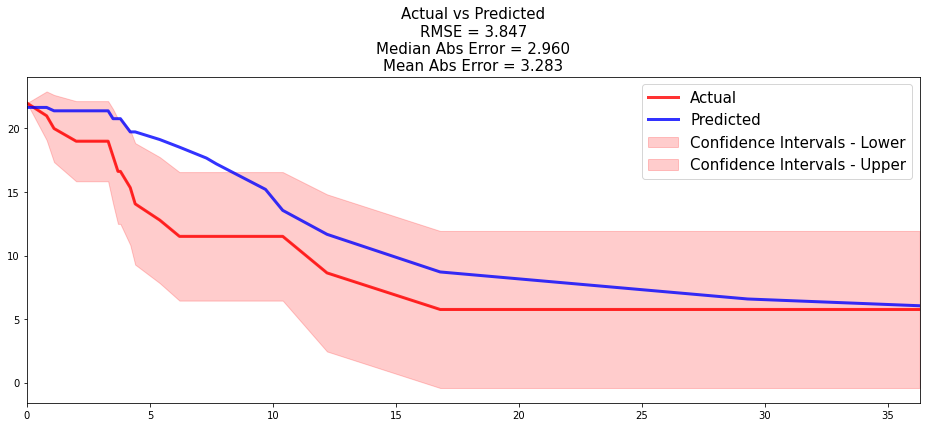

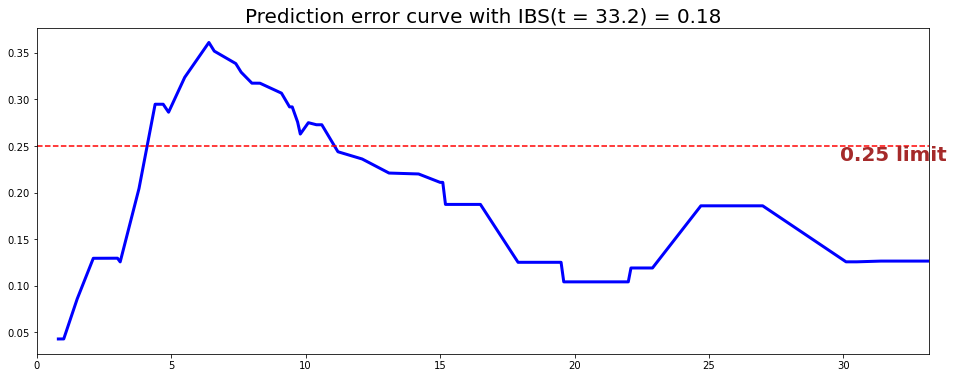

C-index: 0.57
IBS: 0.18


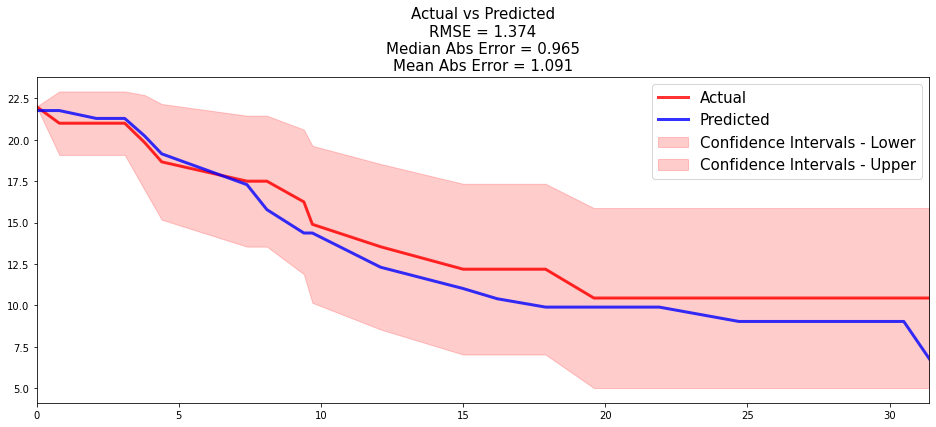

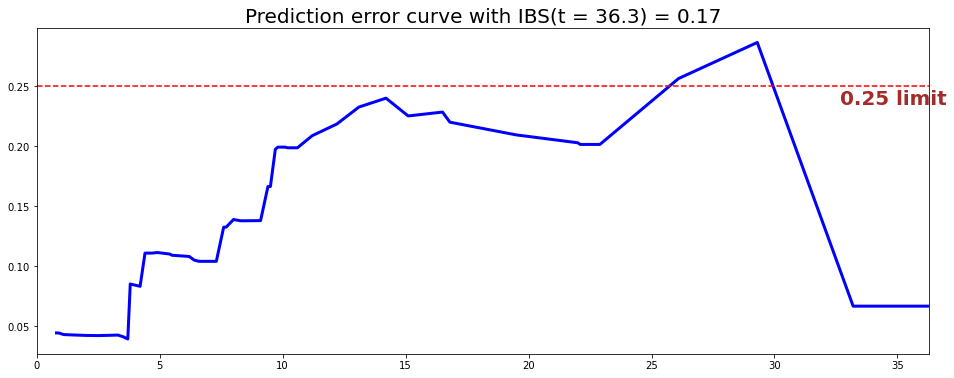

C-index: 0.71
IBS: 0.17


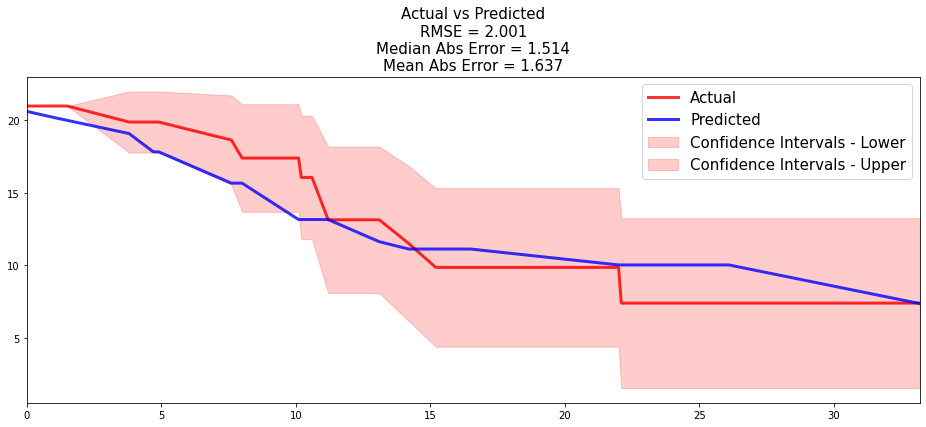

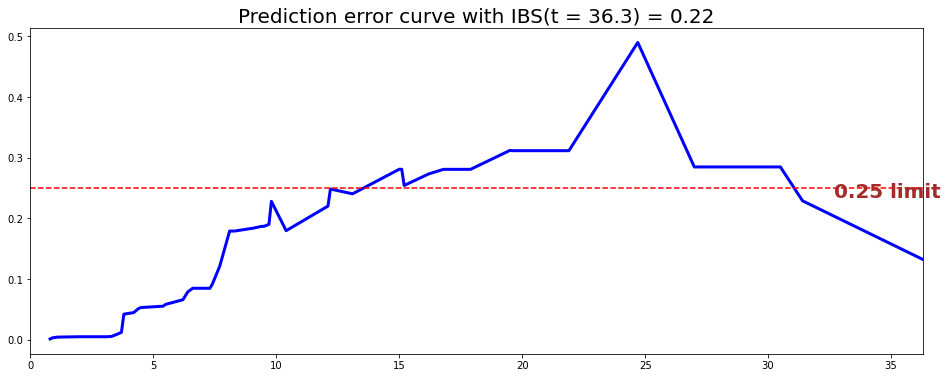

C-index: 0.56
IBS: 0.22


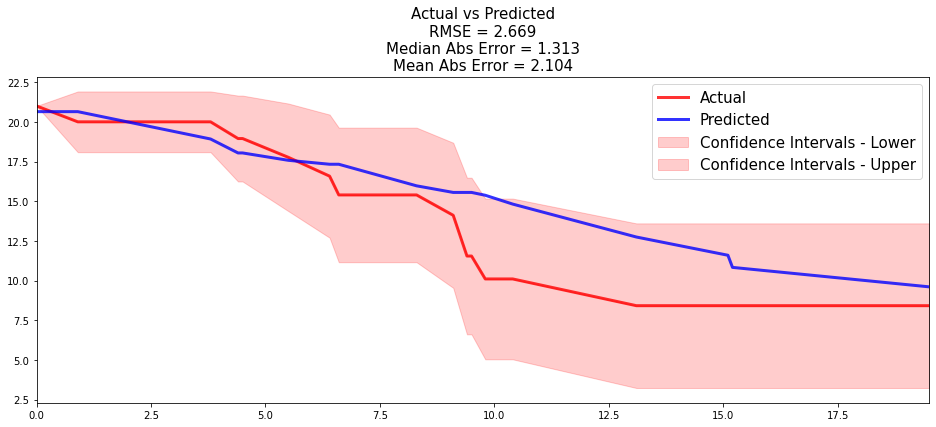

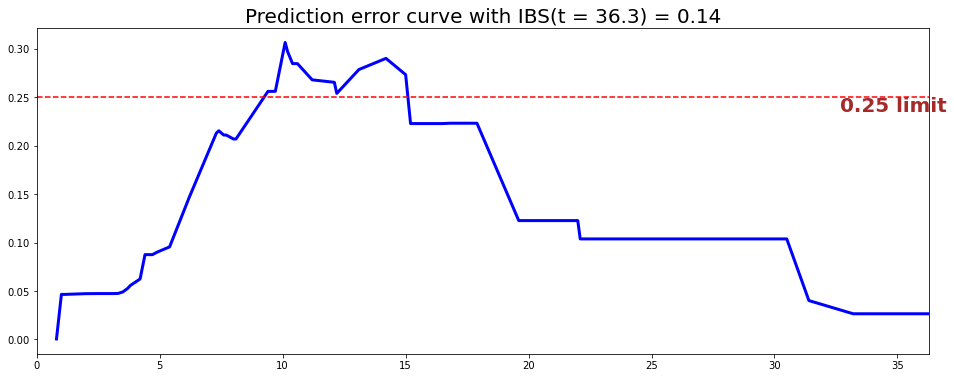

C-index: 0.57
IBS: 0.14
                                            Variable   Imp Avg   Imp Std  \
0                     original_shape_MajorAxisLength  2.489034  1.120674   
1       original_glszm_LargeAreaLowGrayLevelEmphasis  0.627995  1.225479   
2                   original_glcm_DifferenceVariance  0.908853  1.533961   
3                         original_glcm_ClusterShade -0.092937  0.185874   
4                            original_shape_Flatness -0.263523  0.527046   
5                            original_ngtdm_Strength  1.234794  1.229303   
6                       original_firstorder_Skewness  0.366305  0.836442   
7                       original_firstorder_Kurtosis -0.772462  0.516105   
8  original_gldm_LargeDependenceLowGrayLevelEmphasis -0.705151  0.753836   
9       original_glszm_SmallAreaLowGrayLevelEmphasis -0.626037  0.740739   

    Pct Avg   Pct Std  
0  0.374659  0.131958  
1  0.146491  0.155519  
2  0.189803  0.145447  
3  0.000000  0.000000  
4  0.000000  0.0000

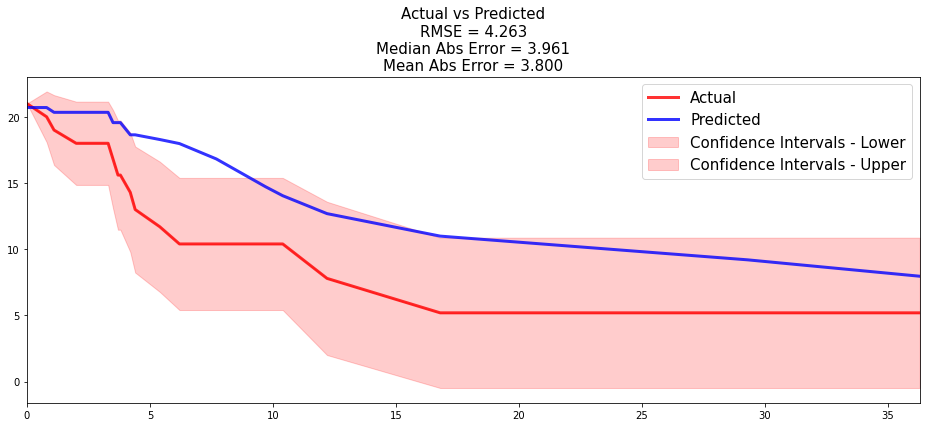

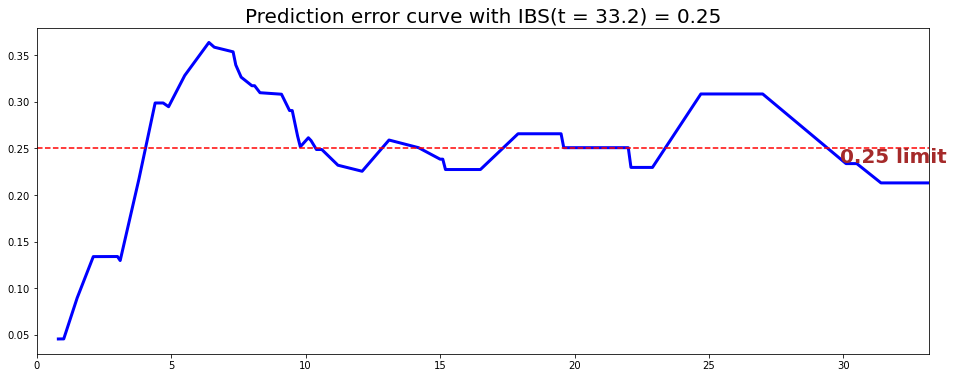

C-index: 0.58
IBS: 0.25


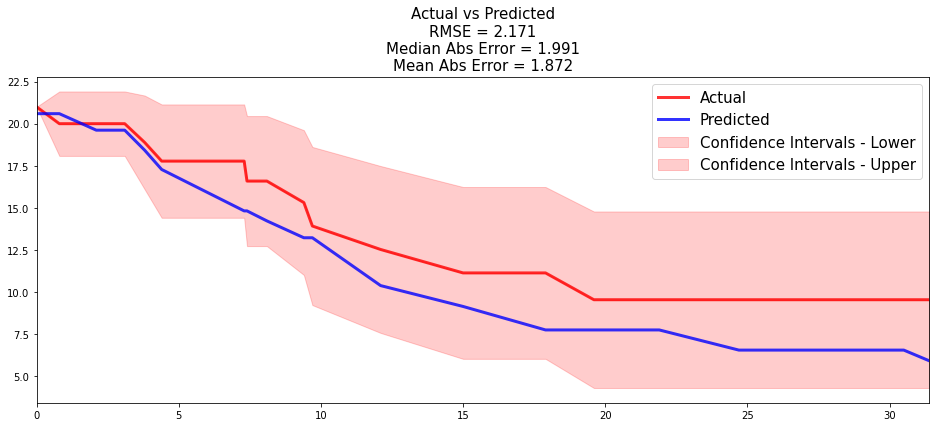

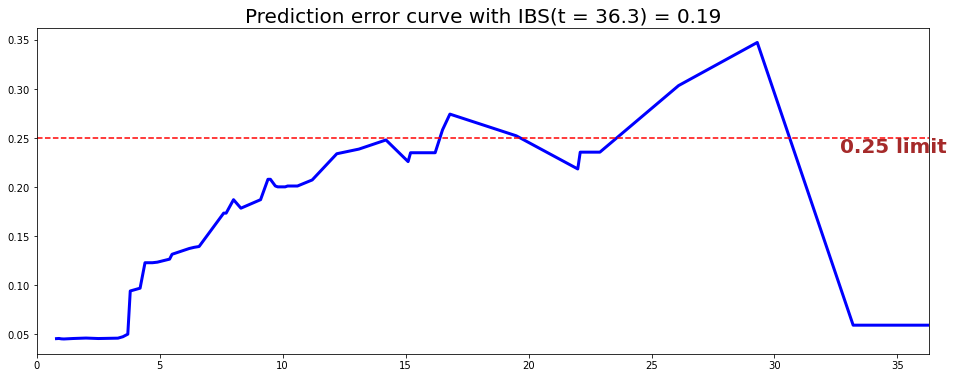

C-index: 0.62
IBS: 0.19


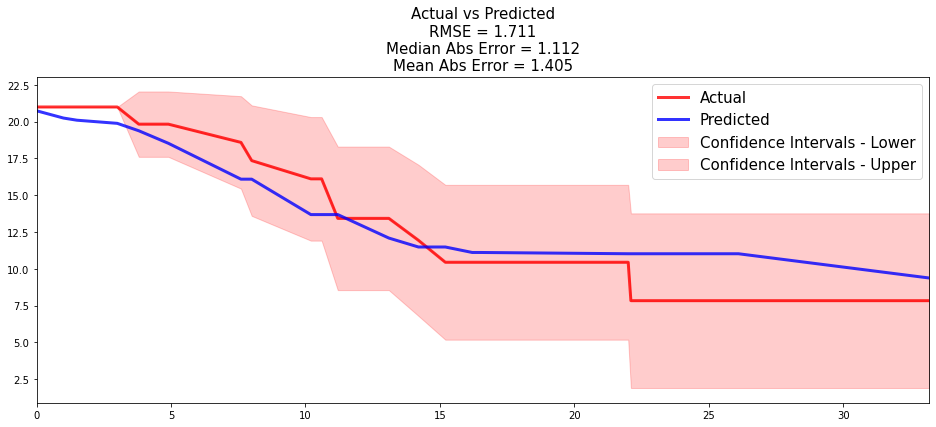

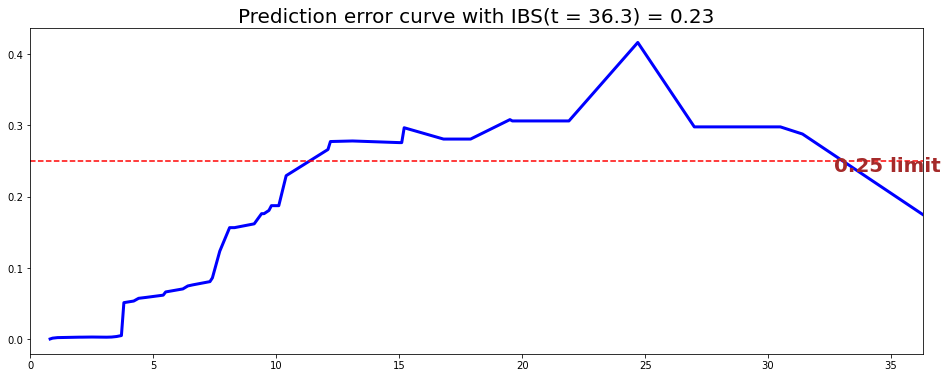

C-index: 0.63
IBS: 0.23


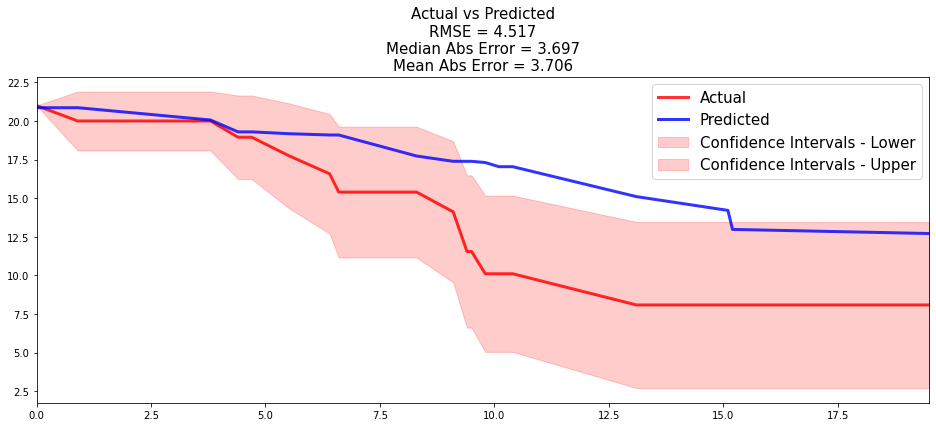

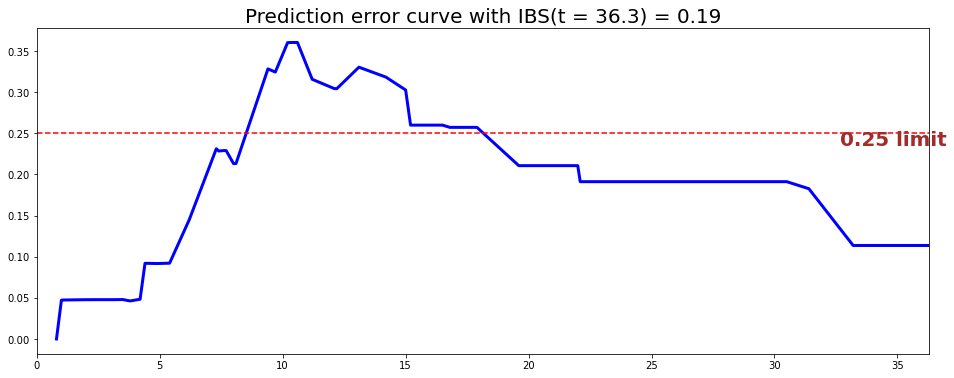

C-index: 0.54
IBS: 0.19
                                            Variable   Imp Avg   Imp Std  \
0                                         Unnamed: 0  2.247239  1.406596   
1                            original_ngtdm_Strength  0.509214  1.284129   
2  original_gldm_LargeDependenceHighGrayLevelEmph... -0.139926  0.428722   
3               original_glszm_SizeZoneNonUniformity  0.008233  0.987315   
4                    original_glcm_ClusterProminence -0.519141  1.084489   
5                       original_firstorder_Skewness  0.729866  1.489068   
6       original_glszm_LargeAreaLowGrayLevelEmphasis -1.207721  0.538990   

    Pct Avg   Pct Std  
0  0.435530  0.218825  
1  0.142000  0.151163  
2  0.020772  0.031564  
3  0.071411  0.114583  
4  0.073598  0.147196  
5  0.256689  0.232304  
6  0.000000  0.000000  

 

Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hy

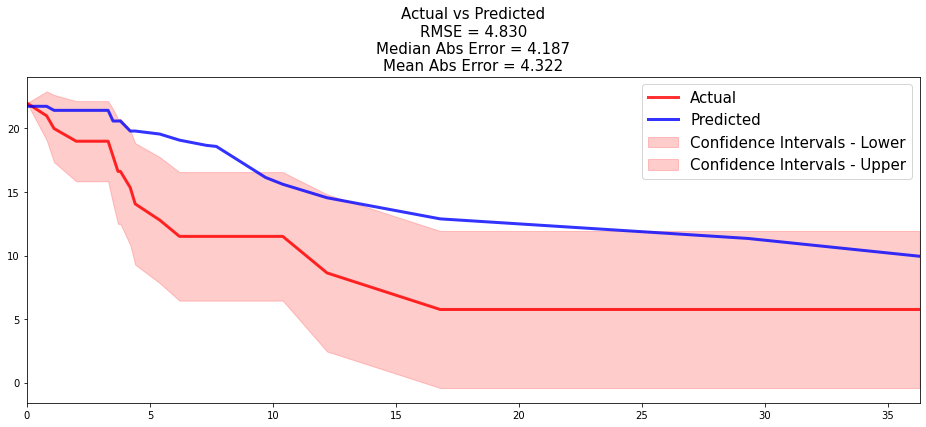

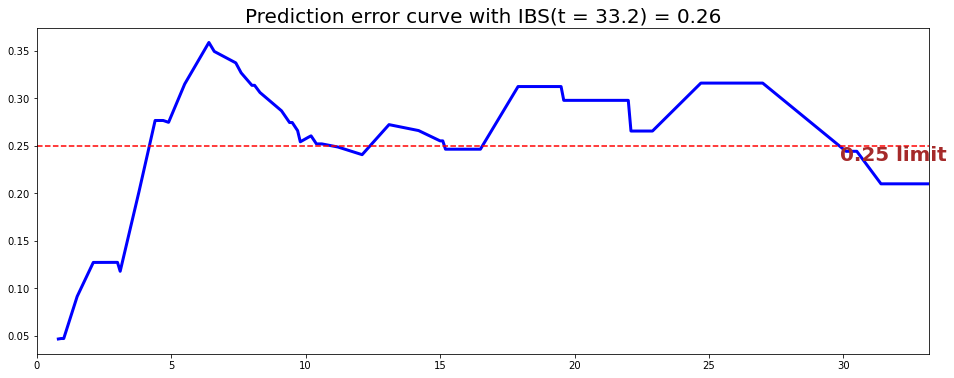

C-index: 0.65
IBS: 0.26


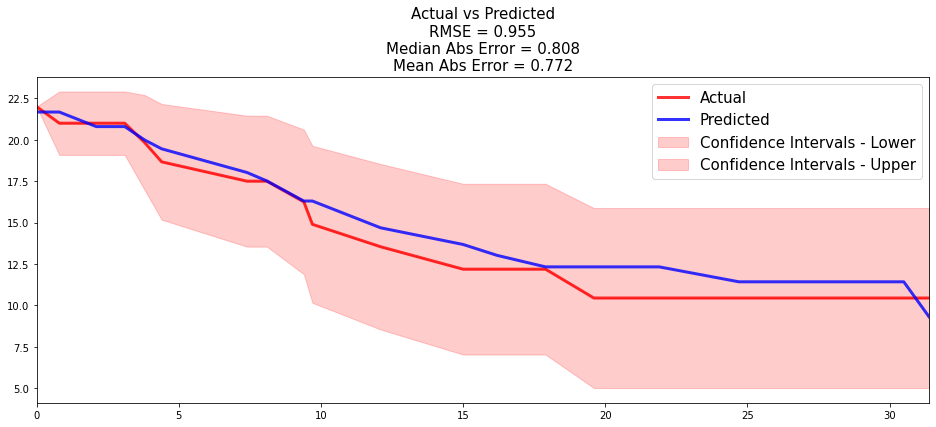

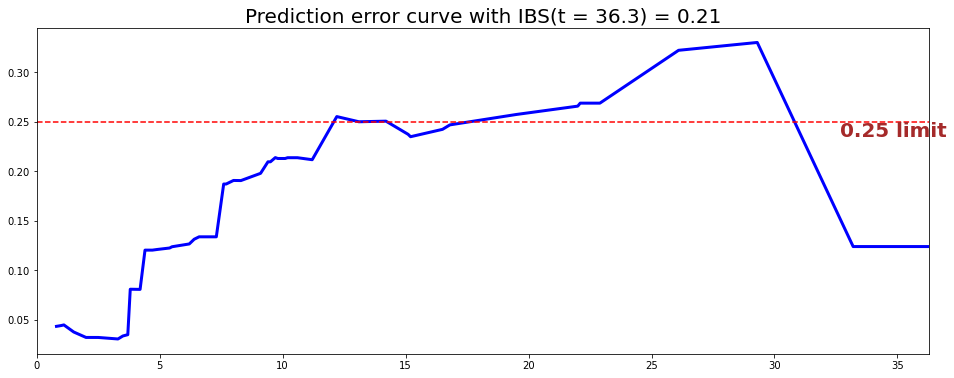

C-index: 0.62
IBS: 0.21


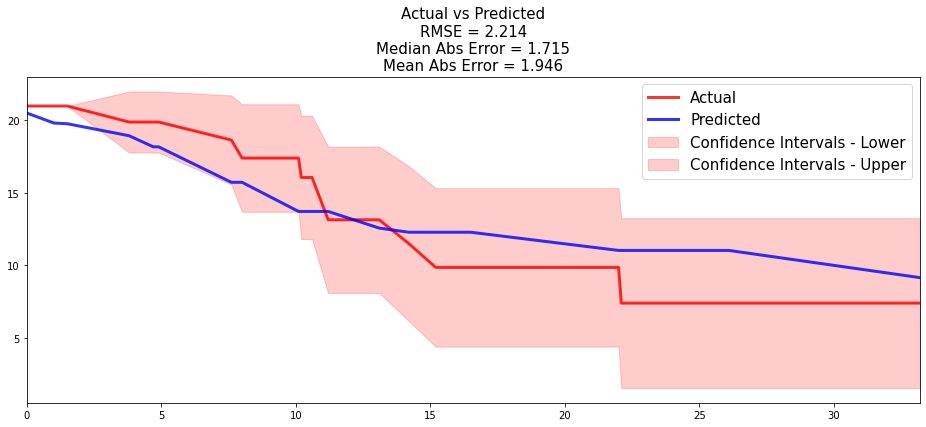

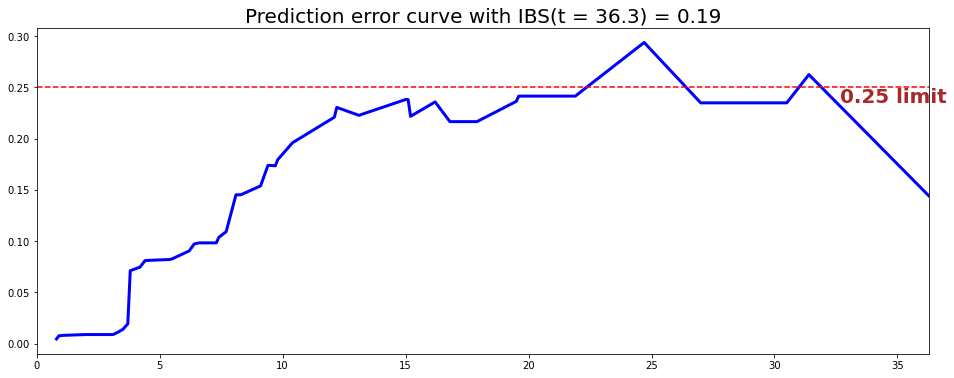

C-index: 0.76
IBS: 0.19


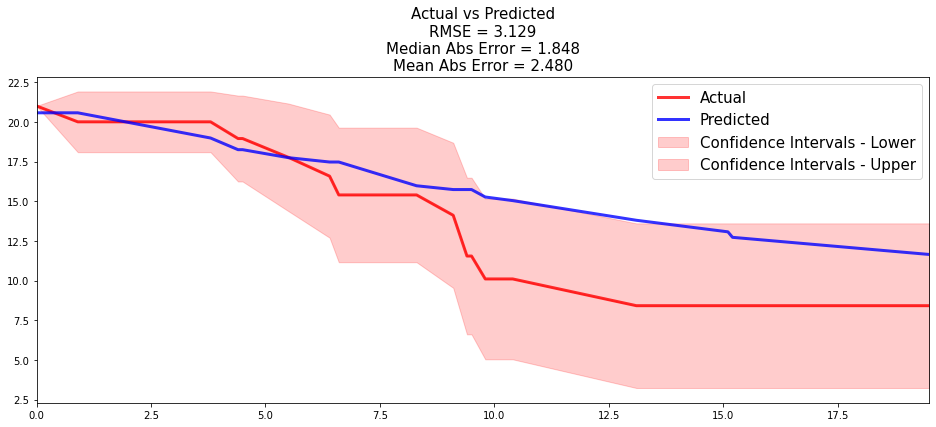

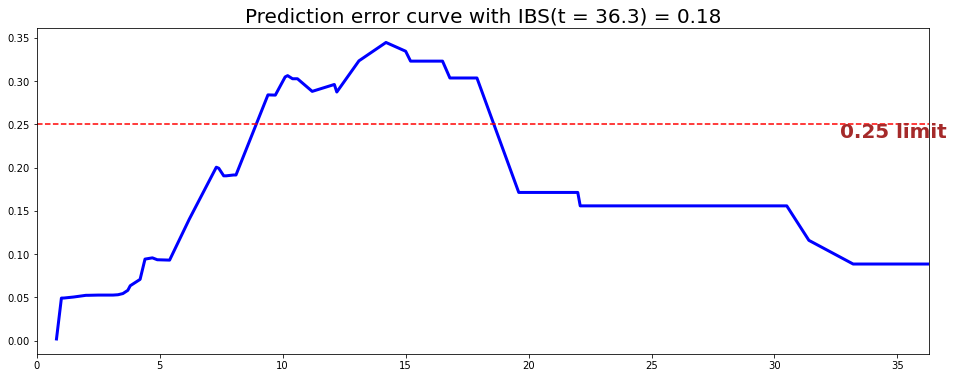

C-index: 0.61
IBS: 0.18
                                       Variable   Imp Avg   Imp Std   Pct Avg  \
0         original_shape_Maximum2DDiameterSlice  2.806366  1.945710  0.186647   
1                  original_firstorder_Skewness  0.573292  2.082307  0.068982   
2                       original_ngtdm_Strength  3.384469  0.943635  0.238688   
3                       original_ngtdm_Busyness  2.801490  0.286933  0.204744   
4                  original_firstorder_Kurtosis  1.966158  1.259761  0.152892   
5                       original_ngtdm_Contrast  0.470433  0.586738  0.033938   
6  original_glszm_SmallAreaLowGrayLevelEmphasis  1.018472  1.377600  0.079480   
7                    original_glcm_ClusterShade -0.480174  1.539589  0.034629   

    Pct Std  
0  0.116484  
1  0.110942  
2  0.022985  
3  0.039722  
4  0.124436  
5  0.030528  
6  0.065232  
7  0.049113  

 

Processing: gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: gtv

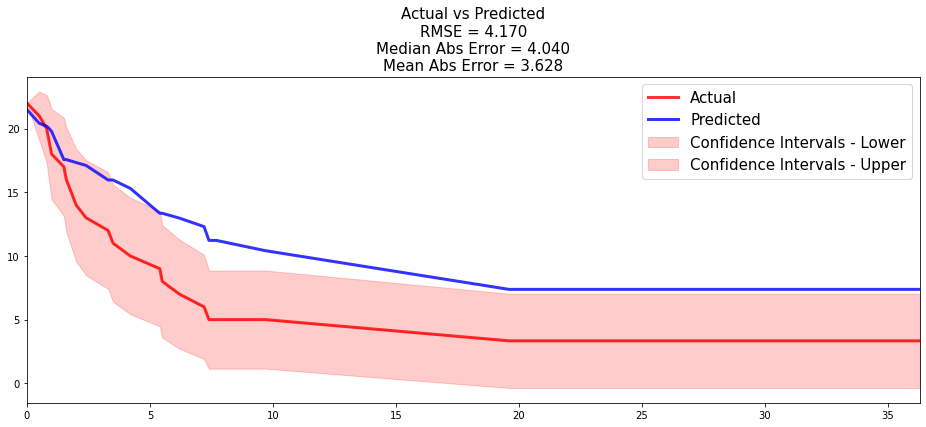

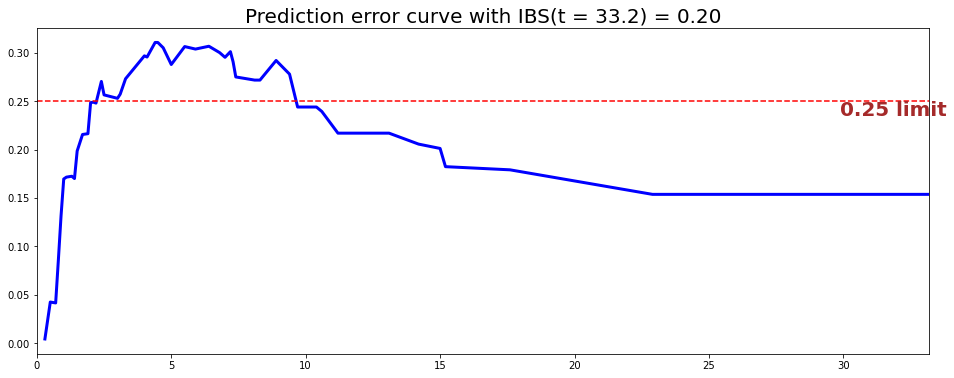

C-index: 0.51
IBS: 0.20


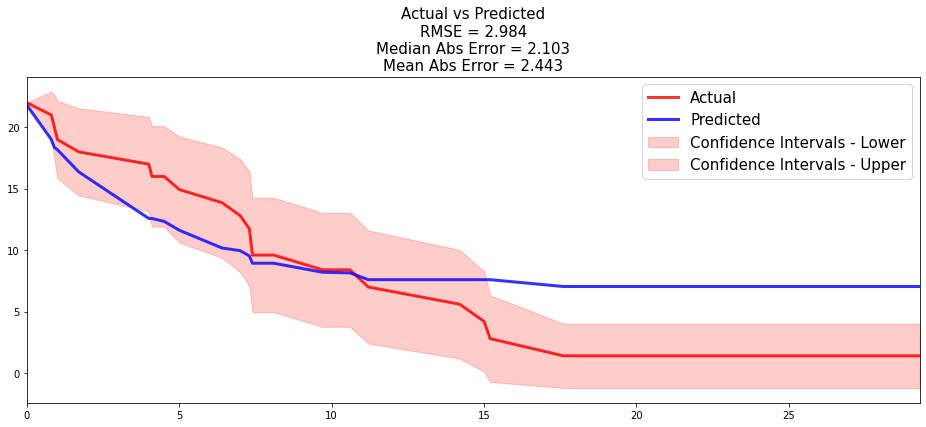

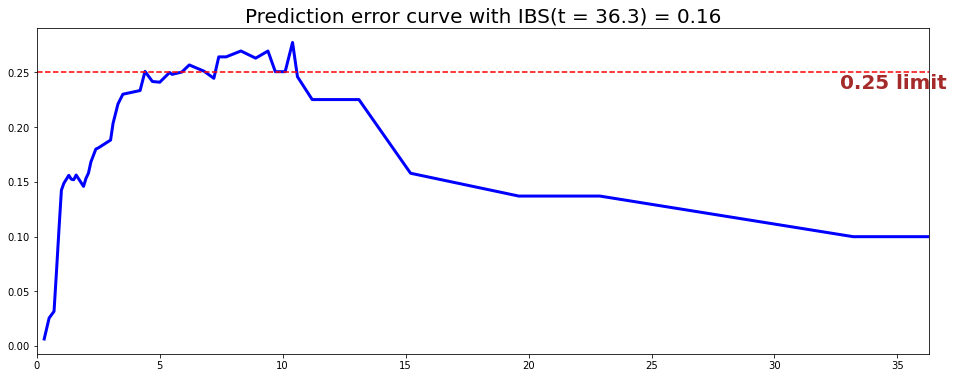

C-index: 0.50
IBS: 0.16


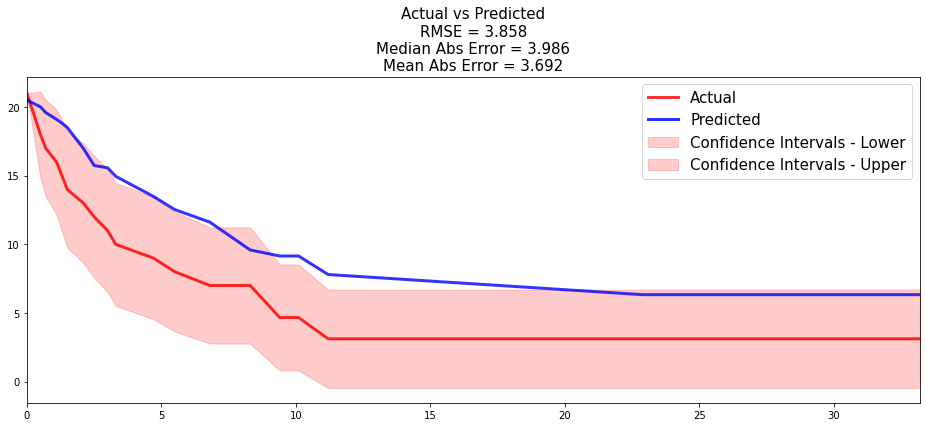

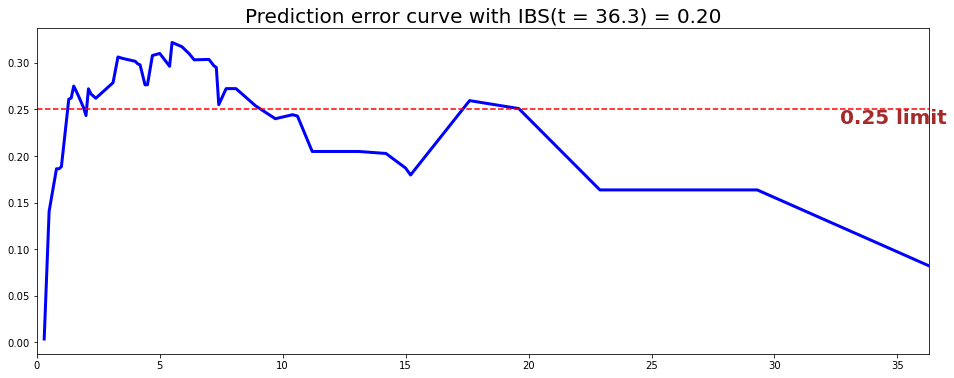

C-index: 0.53
IBS: 0.20


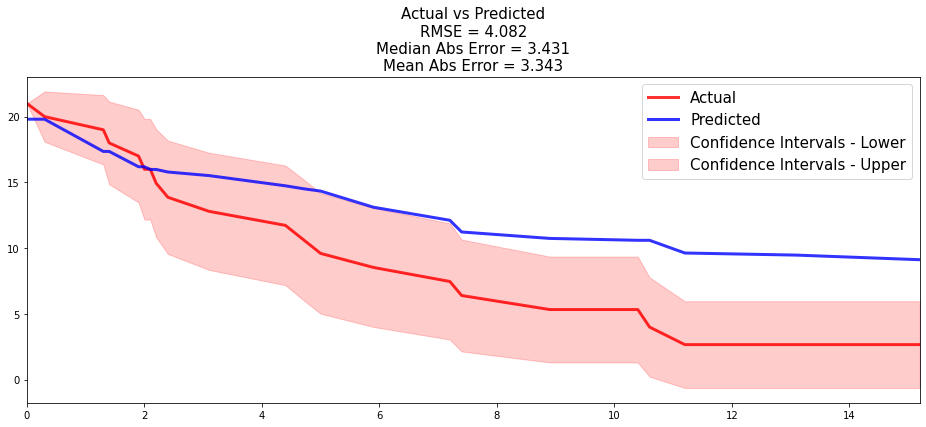

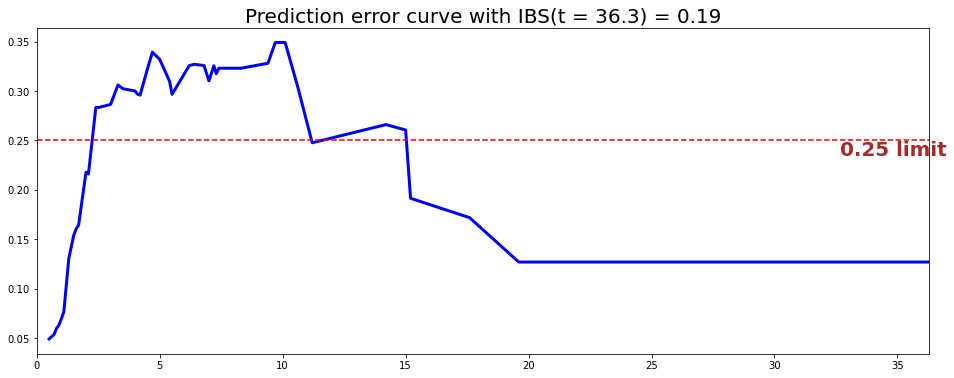

C-index: 0.52
IBS: 0.19
                                            Variable   Imp Avg   Imp Std  \
0       original_glszm_LargeAreaLowGrayLevelEmphasis  0.643059  1.821595   
1       original_glszm_SmallAreaLowGrayLevelEmphasis  0.431109  1.741015   
2                         original_glcm_ClusterShade  0.391962  1.392119   
3  original_gldm_LargeDependenceLowGrayLevelEmphasis -0.155151  0.849840   
4                   original_glcm_DifferenceVariance -0.386321  0.548159   
5                       original_firstorder_Skewness -0.881872  0.741084   
6                   original_firstorder_10Percentile -0.490740  0.852624   
7                     original_shape_MajorAxisLength  0.448050  1.430367   
8                            original_ngtdm_Strength -0.437254  0.588495   
9                       original_firstorder_Kurtosis -0.967070  0.729999   

    Pct Avg   Pct Std  
0  0.169500  0.211850  
1  0.138777  0.169825  
2  0.333802  0.451109  
3  0.051264  0.059786  
4  0.014929  0.0298

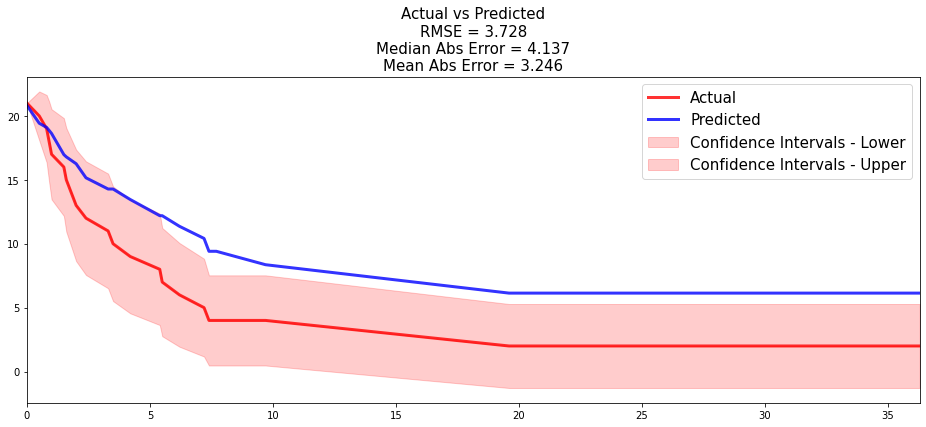

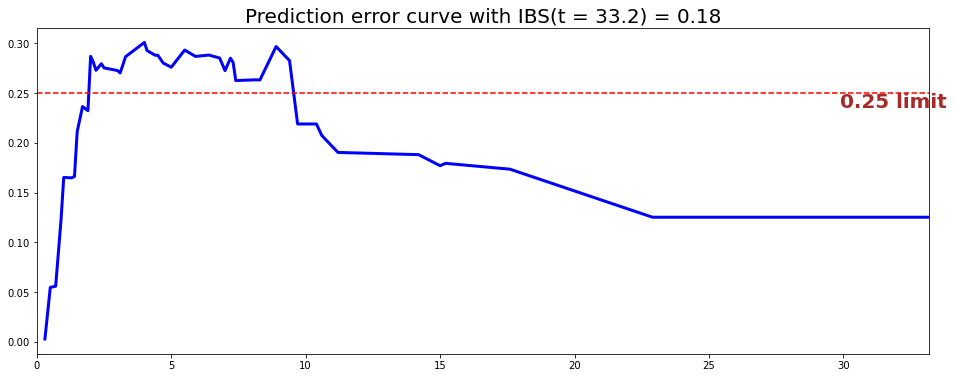

C-index: 0.51
IBS: 0.18


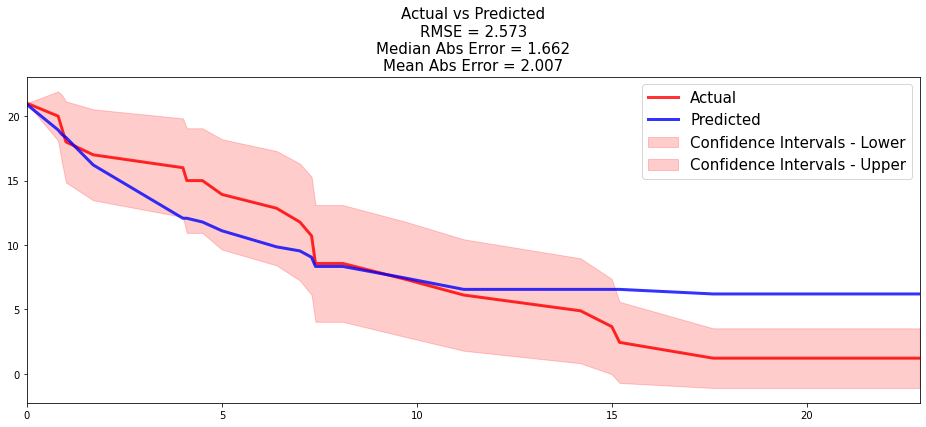

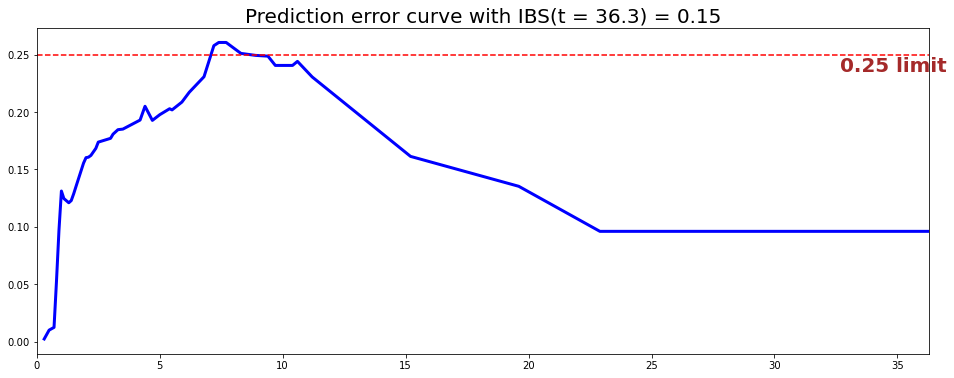

C-index: 0.54
IBS: 0.15


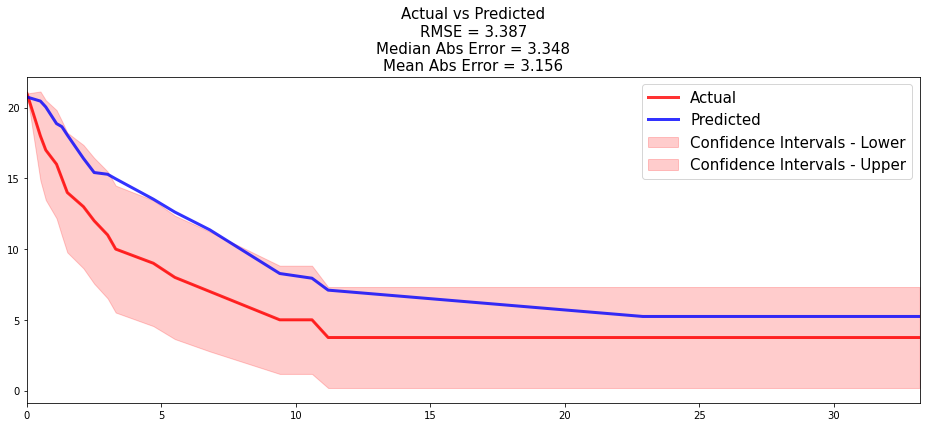

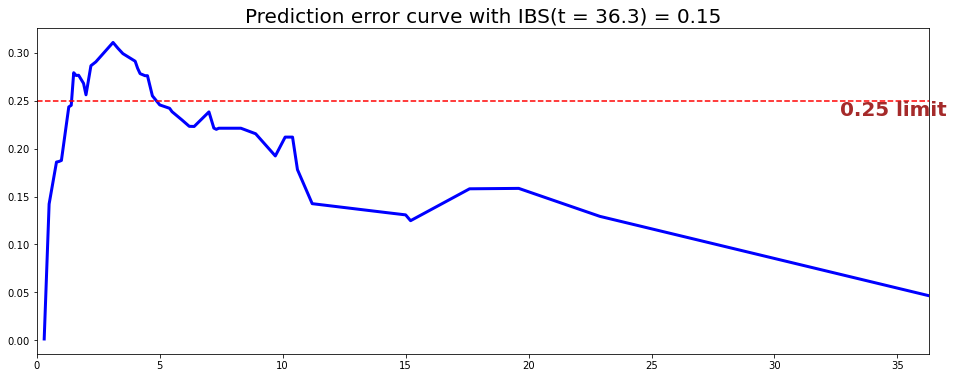

C-index: 0.51
IBS: 0.15


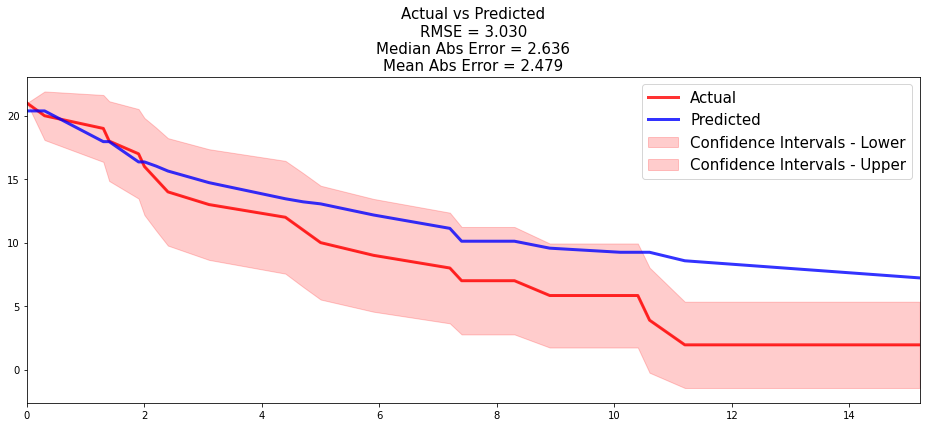

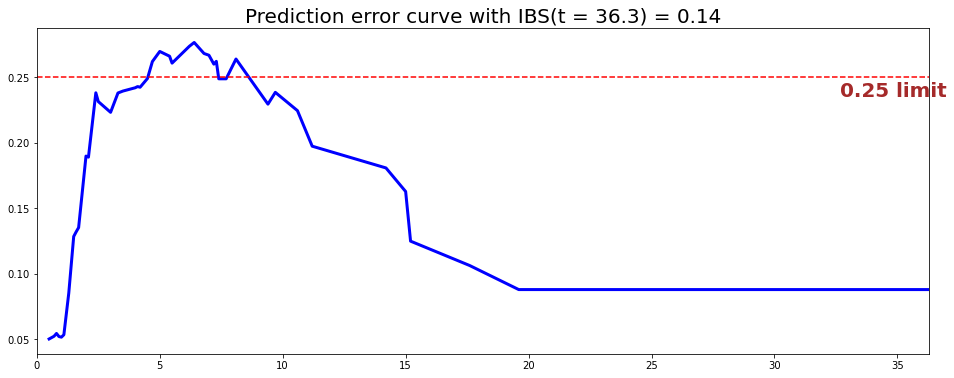

C-index: 0.55
IBS: 0.14
                                            Variable   Imp Avg   Imp Std  \
0  original_gldm_LargeDependenceHighGrayLevelEmph...  0.697866  0.602461   
1       original_glszm_SmallAreaLowGrayLevelEmphasis  0.795206  0.787044   
2                    original_glcm_ClusterProminence  0.427989  1.073604   
3       original_glszm_LargeAreaLowGrayLevelEmphasis  0.714078  1.248534   
4                       original_firstorder_Skewness -0.650209  0.990718   
5               original_glszm_SizeZoneNonUniformity -1.272385  0.496257   

    Pct Avg   Pct Std  
0  0.389521  0.371059  
1  0.202691  0.134178  
2  0.133554  0.165792  
3  0.237171  0.164547  
4  0.037062  0.074125  
5  0.000000  0.000000  

 

Processing: liver_plus_gtv_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



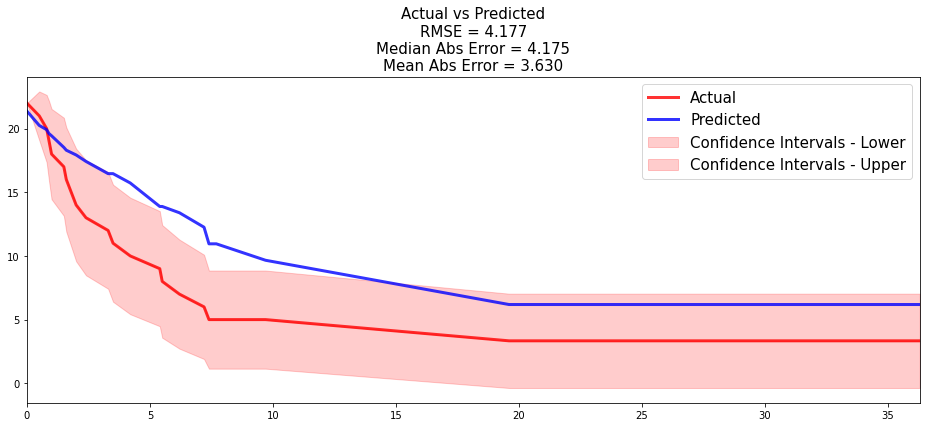

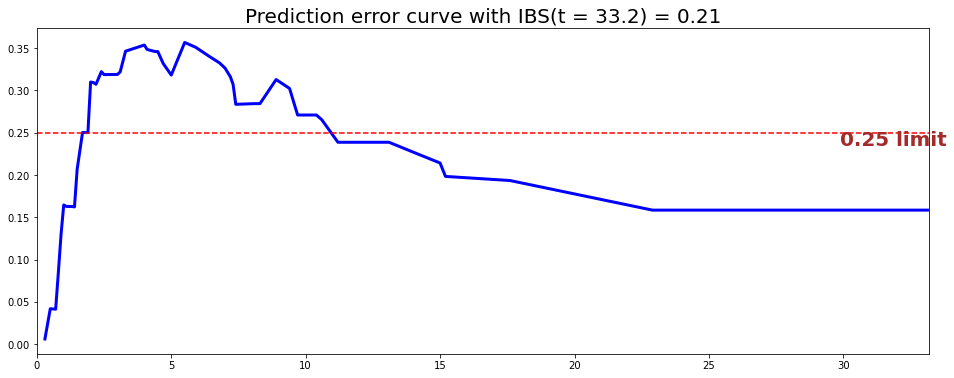

C-index: 0.57
IBS: 0.21


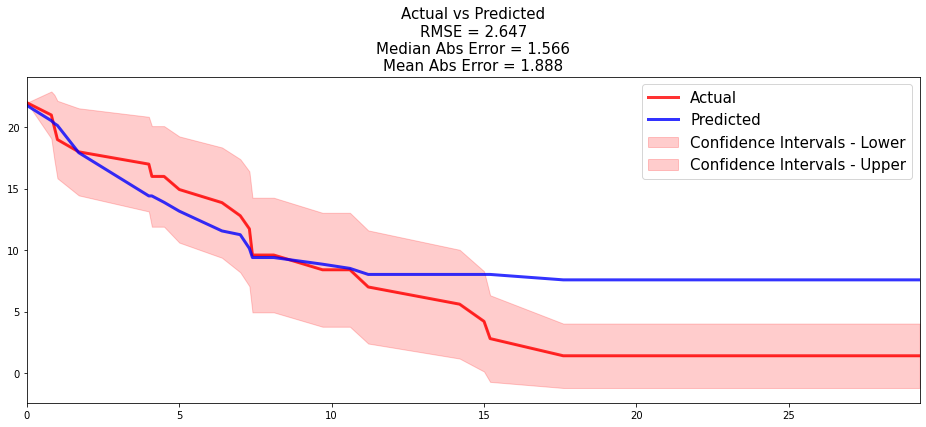

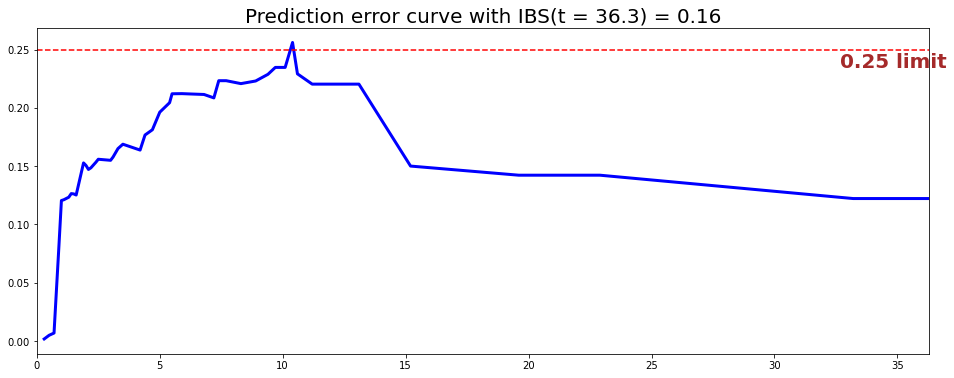

C-index: 0.60
IBS: 0.16


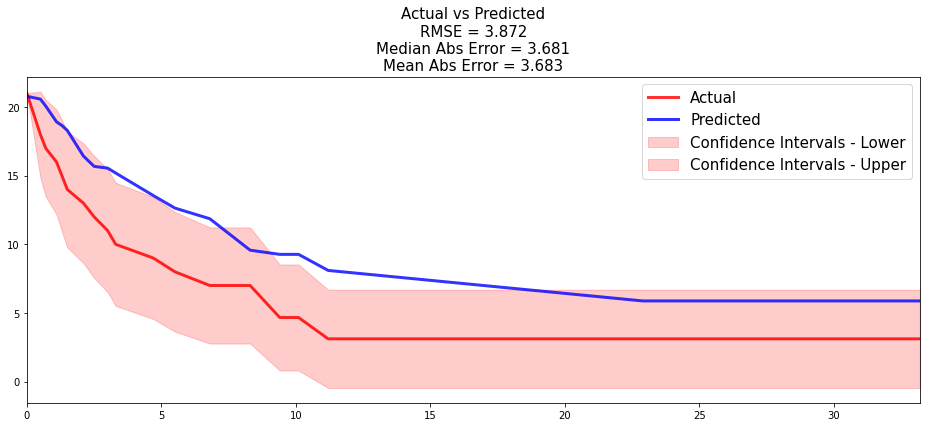

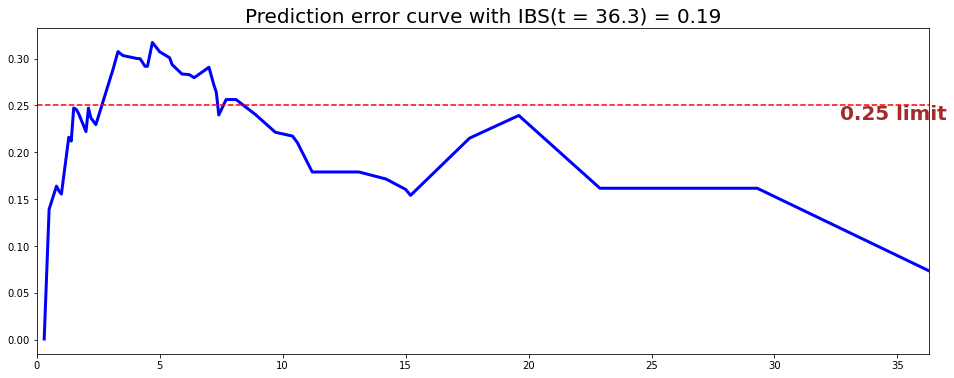

C-index: 0.57
IBS: 0.19


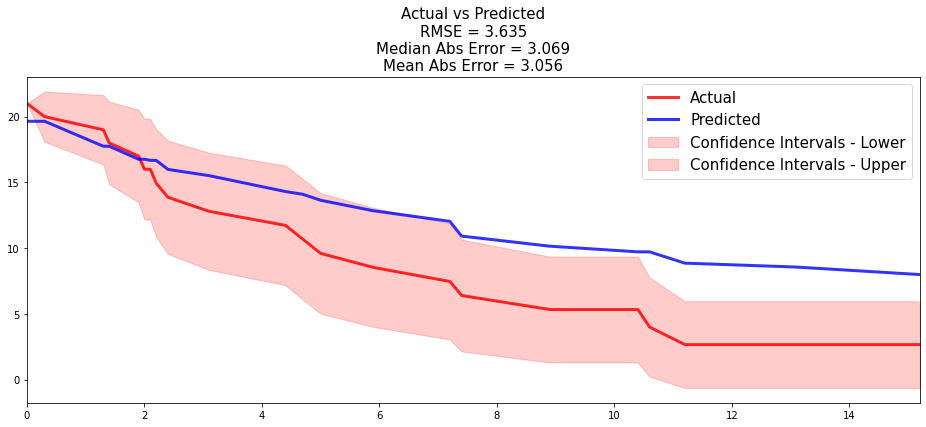

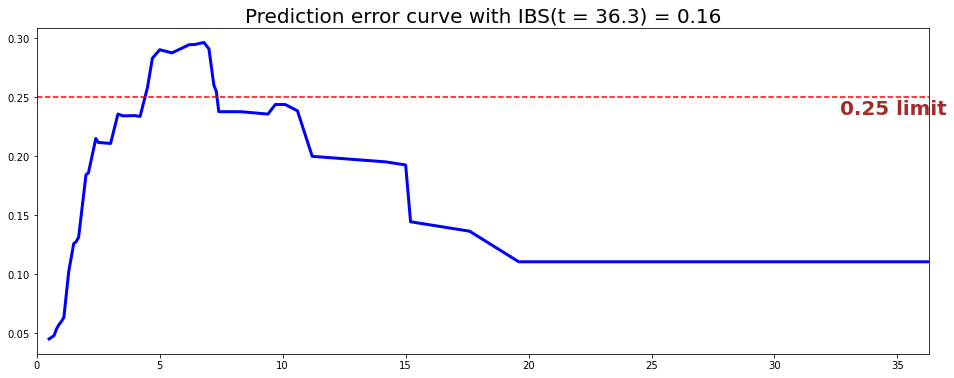

C-index: 0.59
IBS: 0.16
                                            Variable   Imp Avg   Imp Std  \
0                       original_firstorder_Skewness  1.293124  0.558558   
1       original_glszm_LargeAreaLowGrayLevelEmphasis -0.155065  0.940529   
2               original_glszm_SizeZoneNonUniformity -0.691688  0.748969   
3                    original_glcm_ClusterProminence -1.241233  1.823683   
4  original_gldm_LargeDependenceHighGrayLevelEmph... -0.797452  1.587355   

    Pct Avg   Pct Std  
0  0.638492  0.170166  
1  0.138919  0.195871  
2  0.085699  0.171398  
3  0.081377  0.162753  
4  0.055514  0.111027  

 

Processing: clin_variables_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



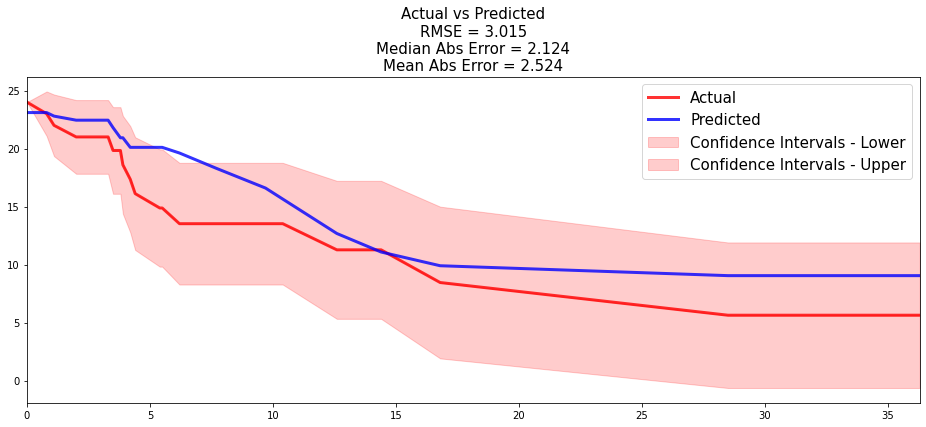

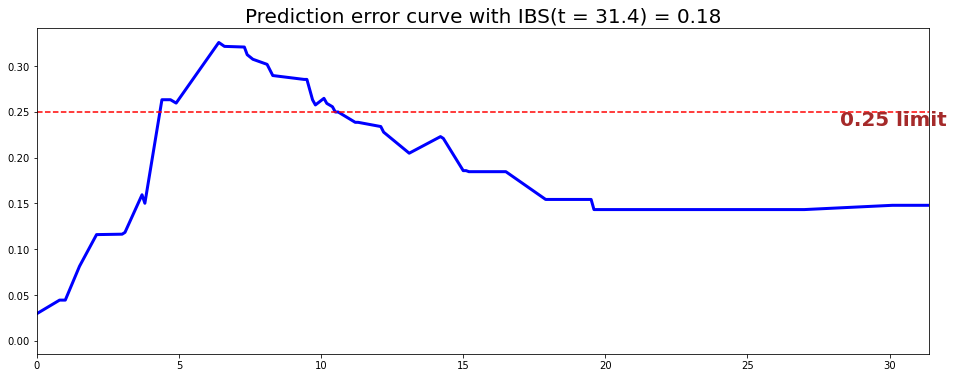

C-index: 0.64
IBS: 0.18


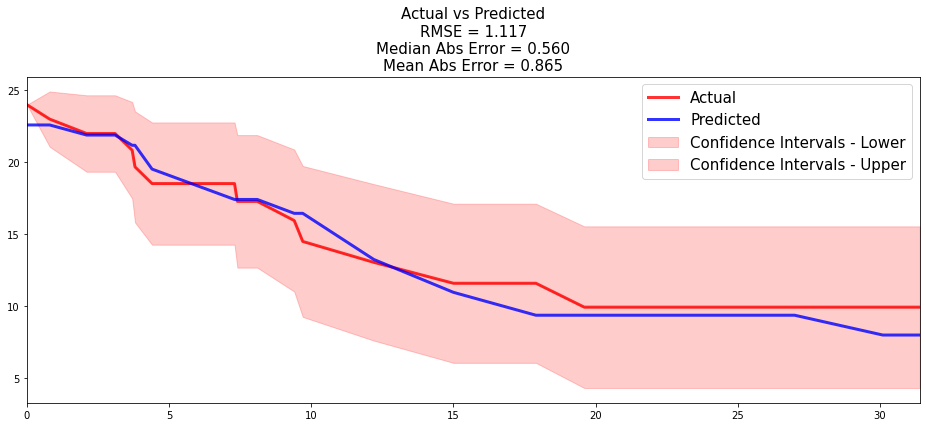

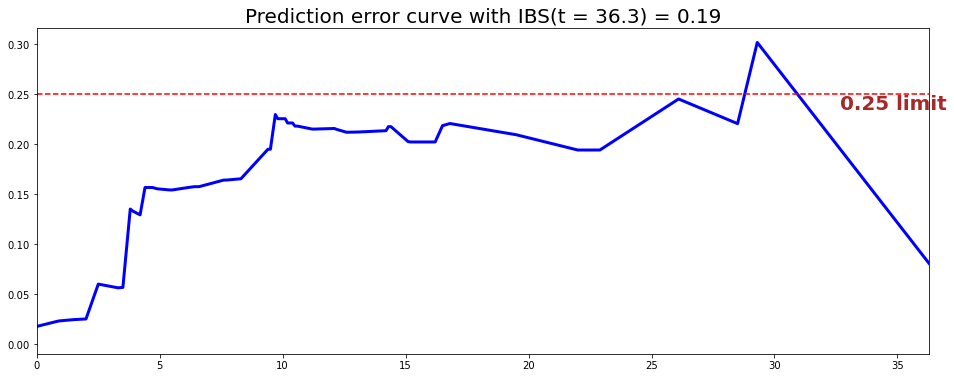

C-index: 0.72
IBS: 0.19


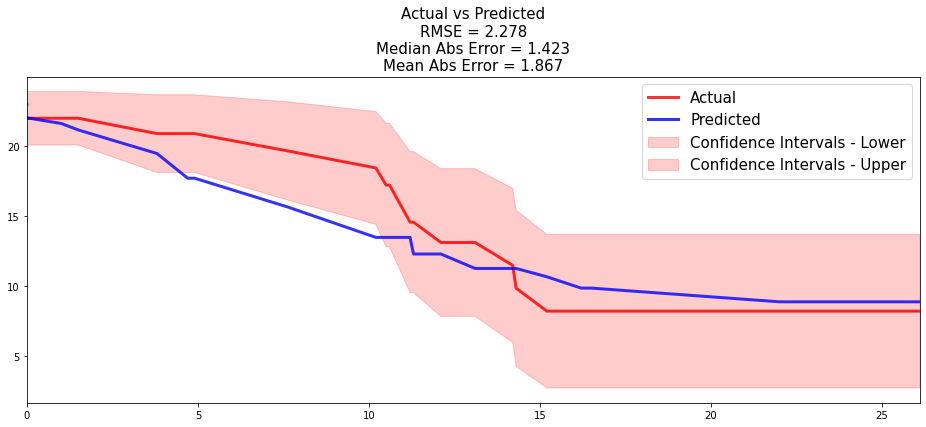

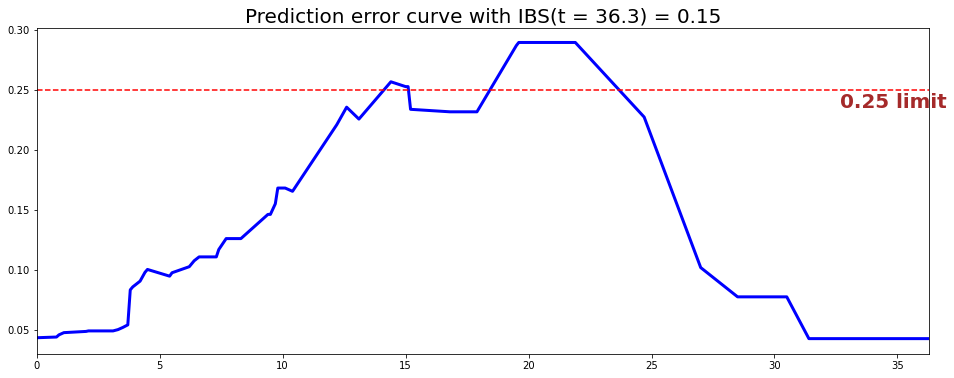

C-index: 0.69
IBS: 0.15


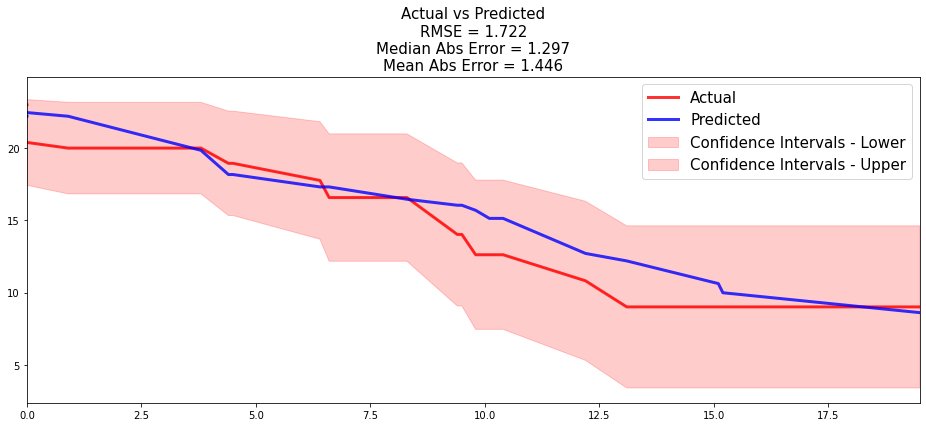

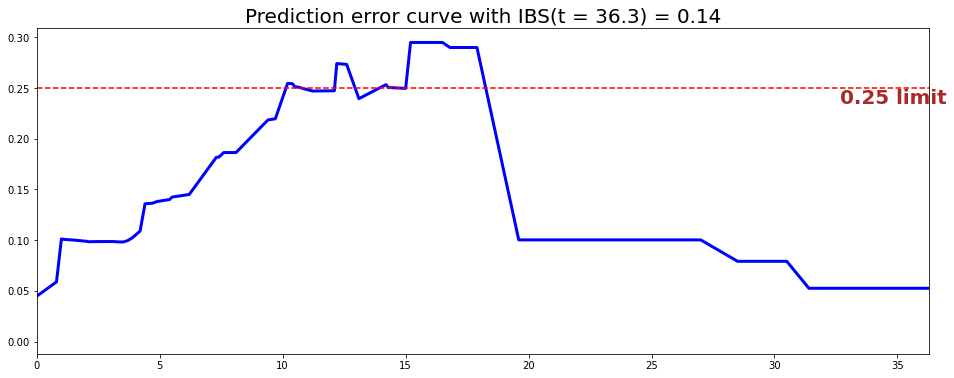

C-index: 0.59
IBS: 0.14
           Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0  PTVvolume (cm^3)  6.065705  1.938846  0.861840  0.162259
1       Lesion1Dim1  0.920021  1.763241  0.125879  0.153605
2    OtherSitesAtRT -1.217057  1.311105  0.012281  0.024562

 

Processing: clin_variables_non_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_non_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



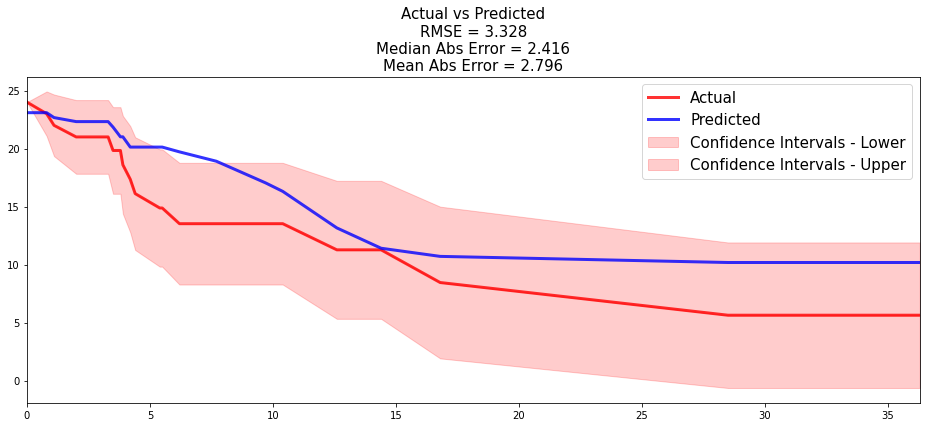

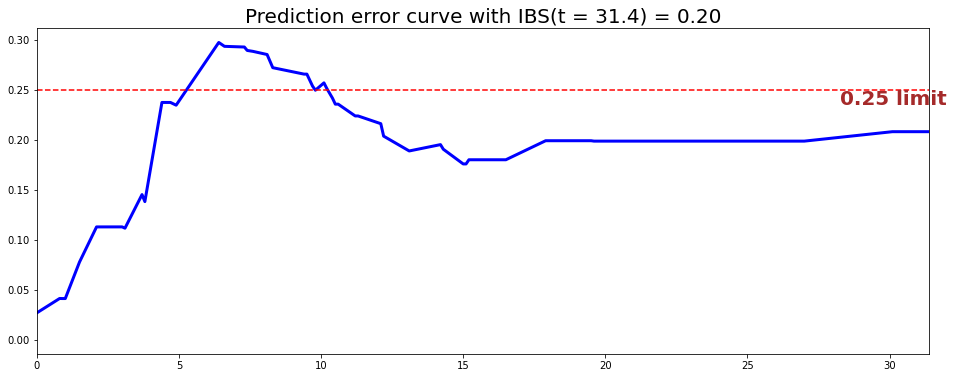

C-index: 0.59
IBS: 0.20


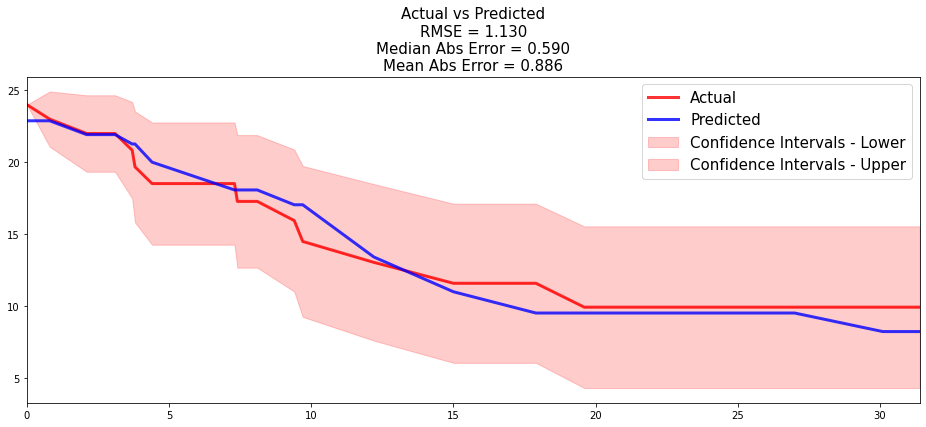

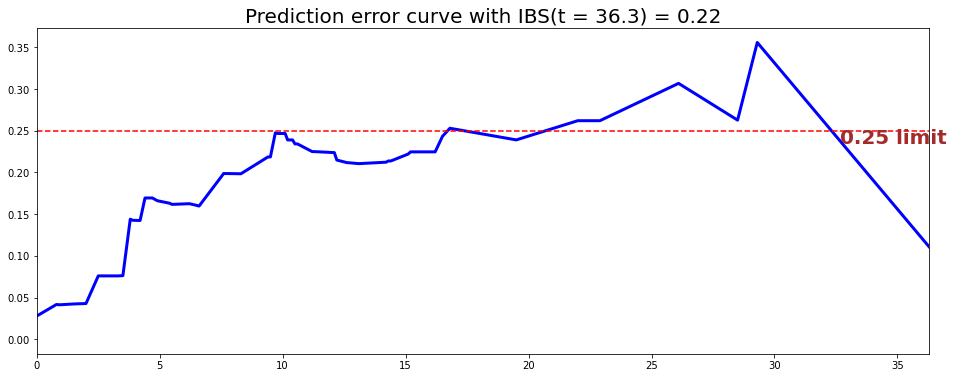

C-index: 0.68
IBS: 0.22


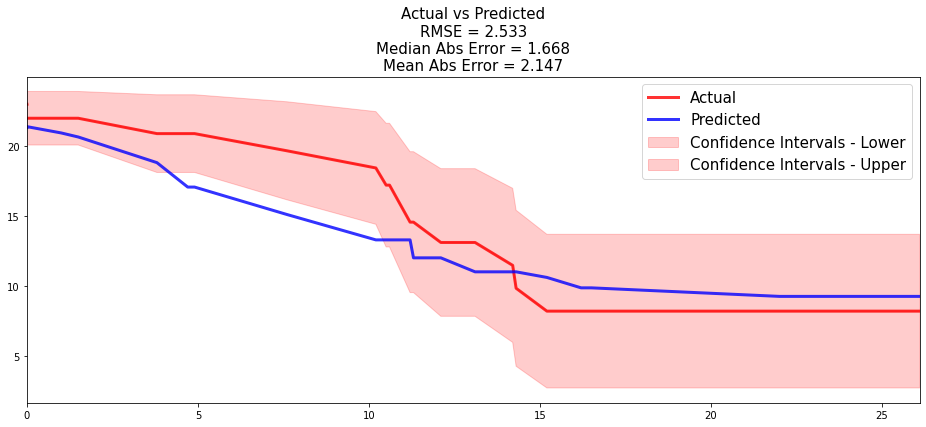

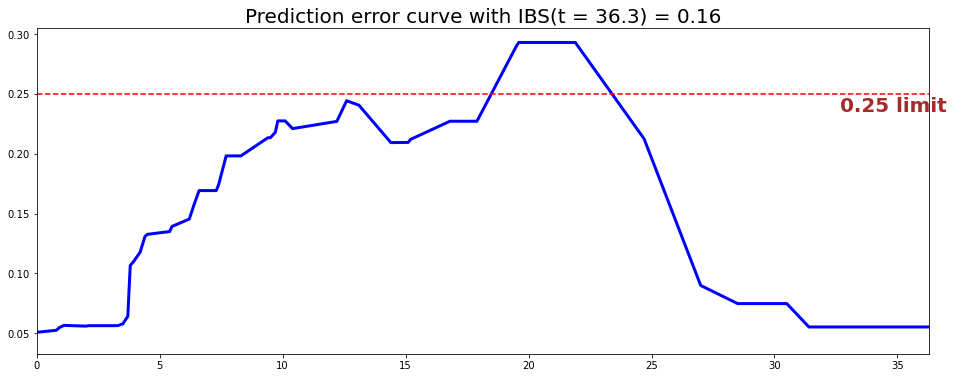

C-index: 0.64
IBS: 0.16


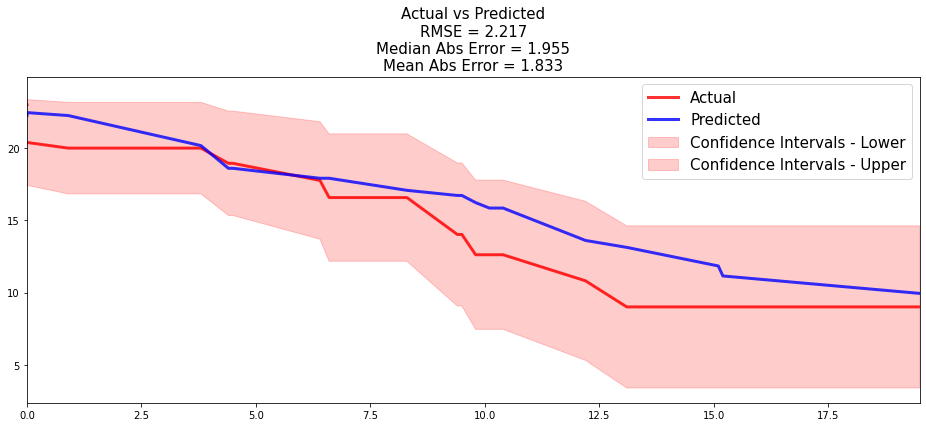

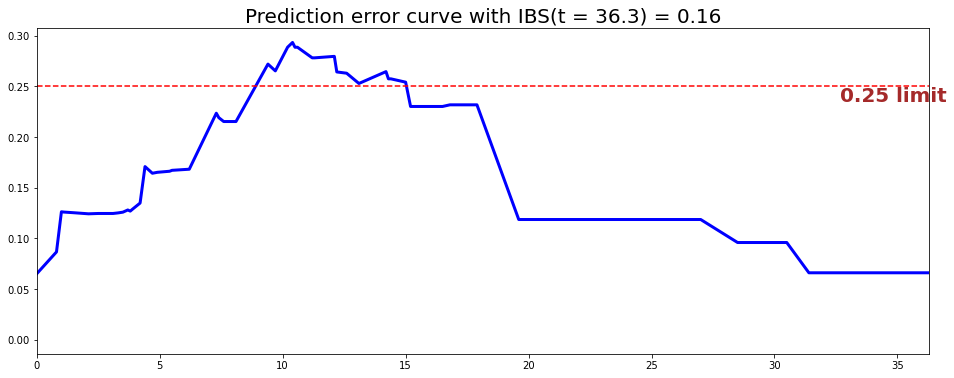

C-index: 0.51
IBS: 0.16
                 Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0          Lines of chemo  5.265216  3.111437  0.502777  0.259157
1   NumLiverLesionsAtRT.1  2.761087  3.661451  0.318742  0.311078
2                  Gender -1.129064  1.946078  0.025978  0.051956
3        LiverLocation2Tx  1.425398  1.119647  0.144541  0.116161
4            KRASmutation -1.372490  1.244604  0.000000  0.000000
5         SurgeryBeforeRT -1.230650  0.874555  0.000000  0.000000
6                    ReTx -0.199802  0.543652  0.004757  0.009514
7    EmbolizationBeforeRT -2.164725  1.866393  0.000000  0.000000
8            PumpBeforeRT -1.543875  0.632465  0.000000  0.000000
9             RFAbeforeRT -1.634949  1.174765  0.003205  0.006410
10        cM at diagnosis -1.608731  0.828948  0.000000  0.000000

 

Processing: clin_variables_dosimetric_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_dosimetric_fflp.csv

Loading

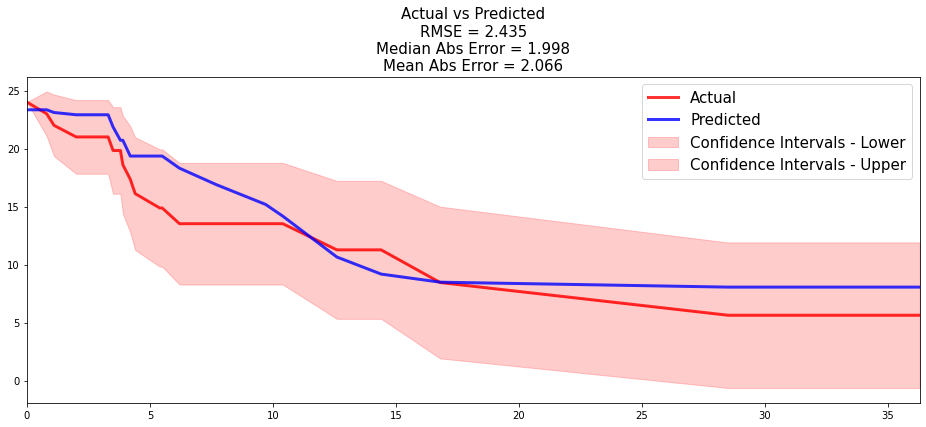

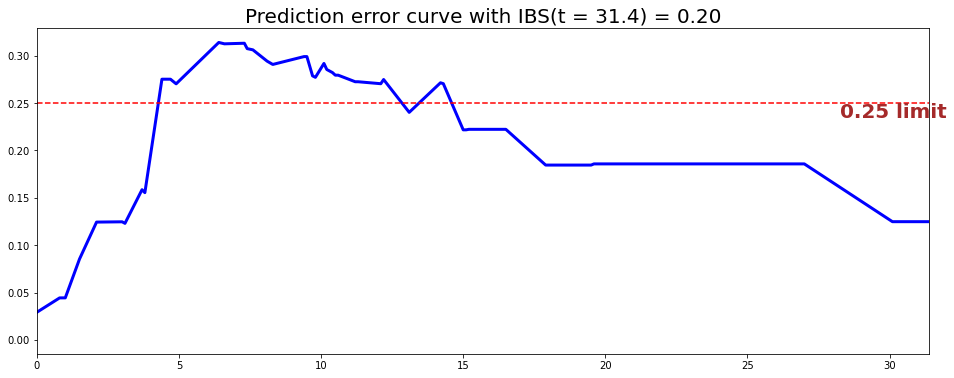

C-index: 0.64
IBS: 0.20


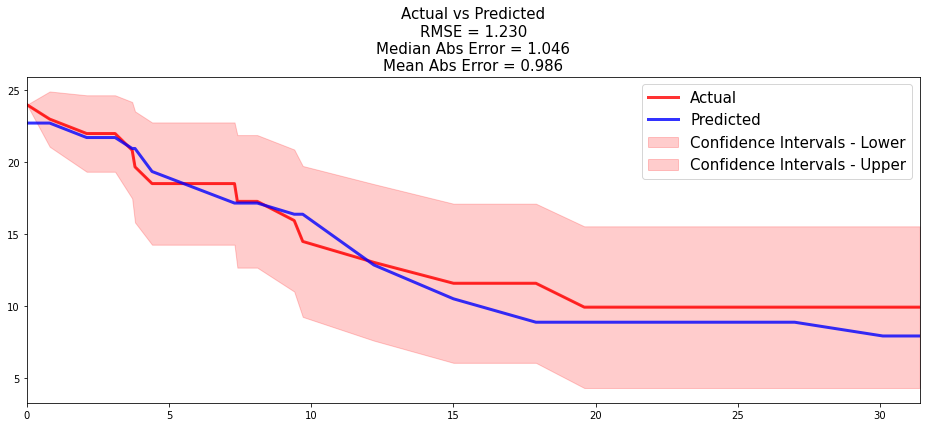

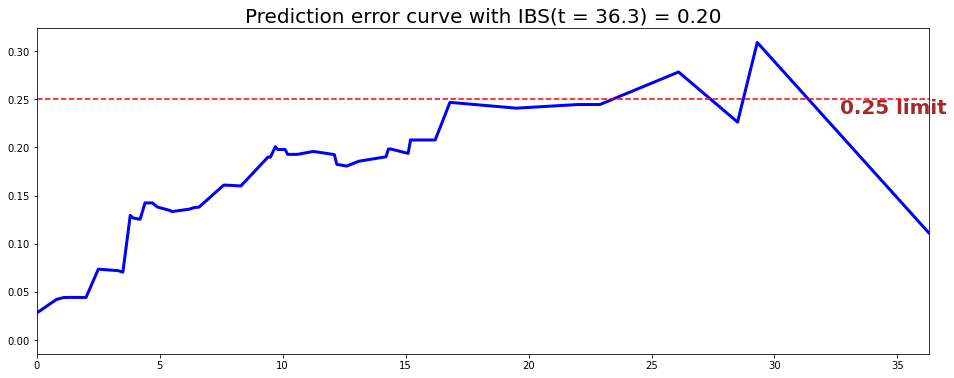

C-index: 0.75
IBS: 0.20


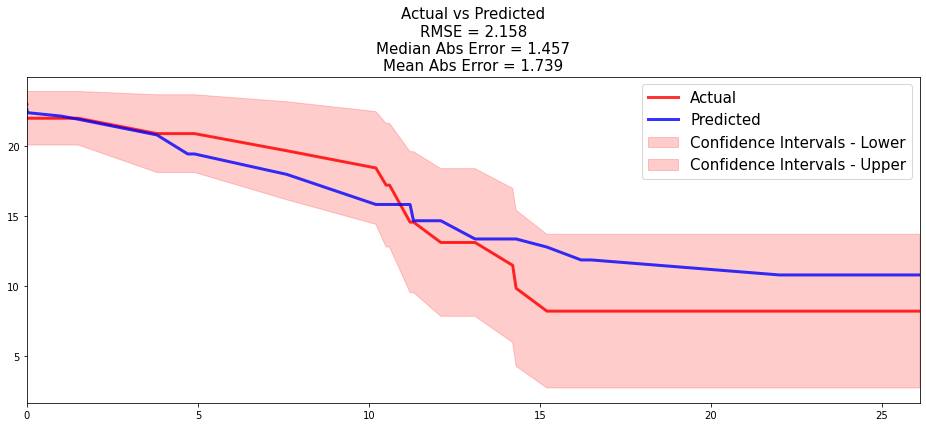

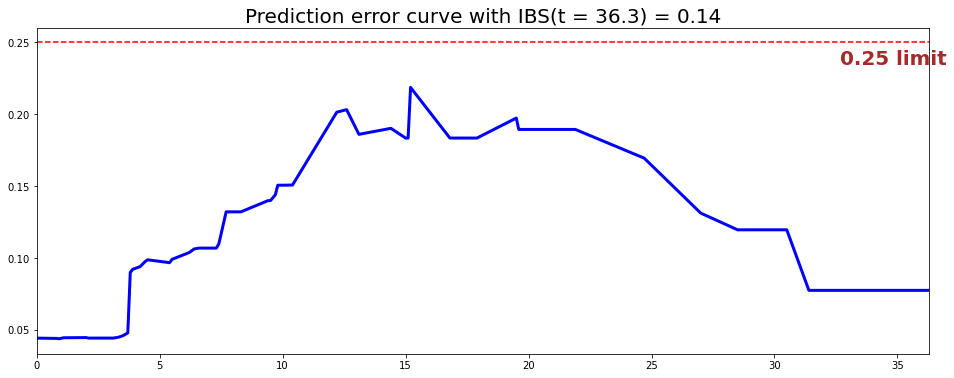

C-index: 0.74
IBS: 0.14


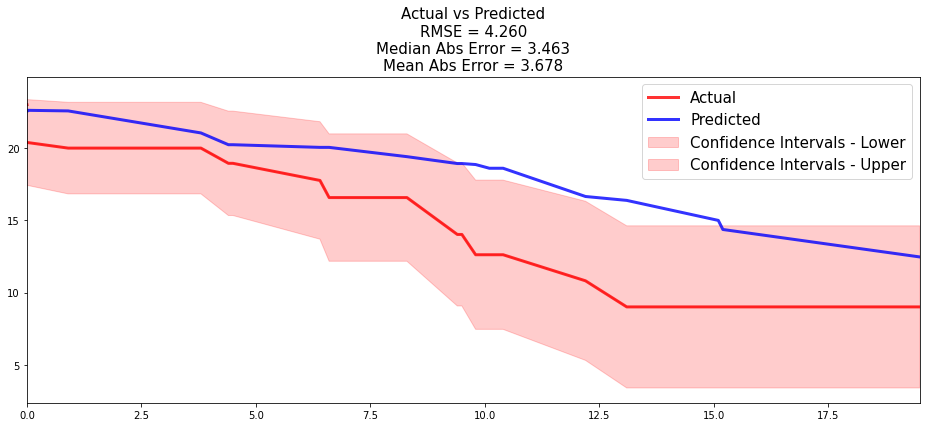

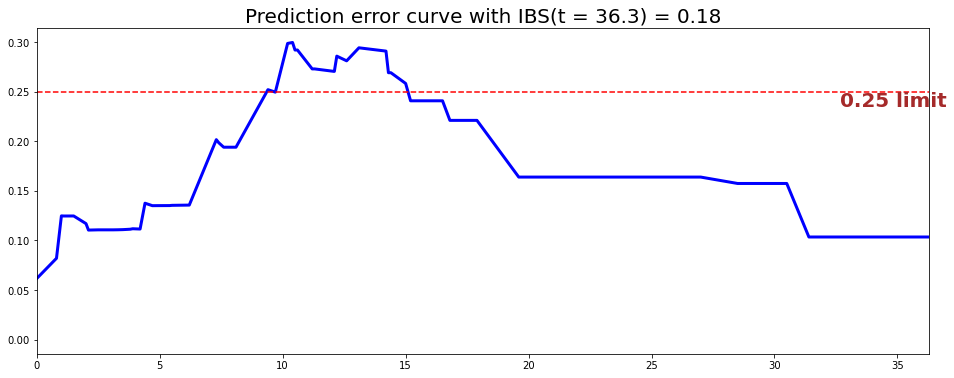

C-index: 0.68
IBS: 0.18
         Variable    Imp Avg   Imp Std   Pct Avg   Pct Std
0      Dmax (cGy)  10.778388  4.886809  0.691939  0.187076
1         CEAatRT   2.437549  2.570865  0.128843  0.110068
2  Lines of chemo   2.233226  1.748222  0.179219  0.173078
3    PumpBeforeRT  -1.015794  0.898544  0.000000  0.000000

 

Processing: clin_variables_imaging_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



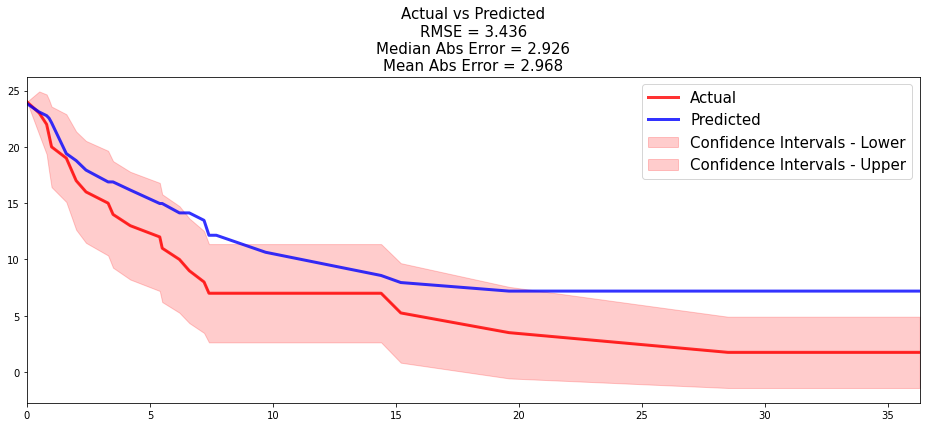

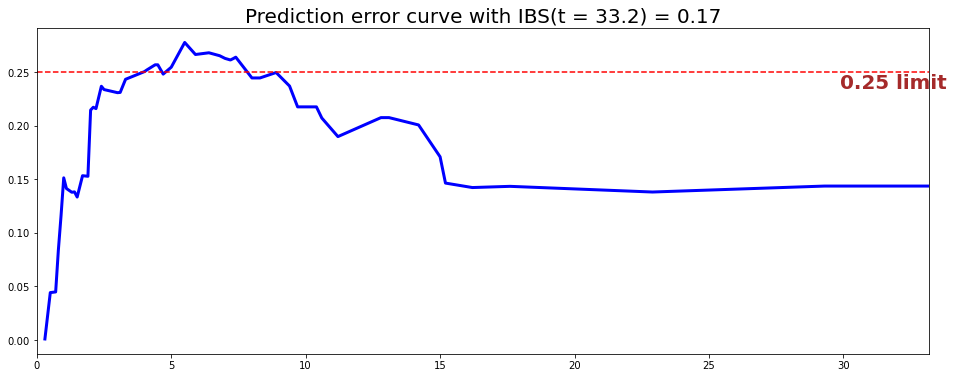

C-index: 0.55
IBS: 0.17


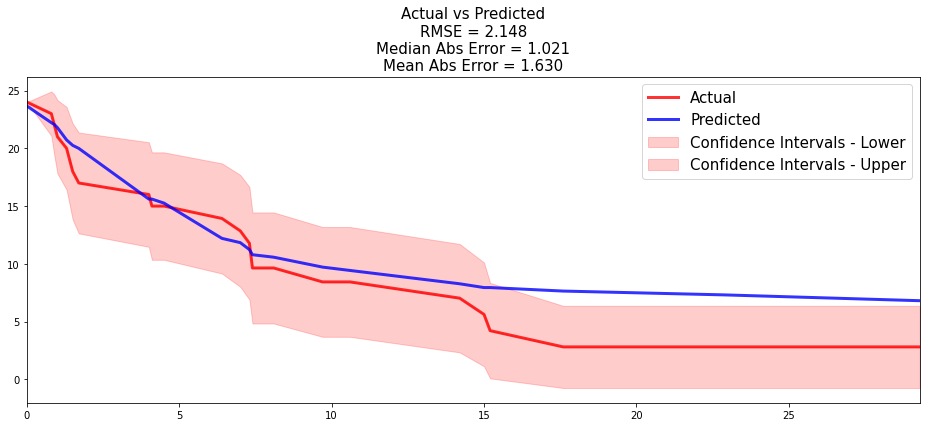

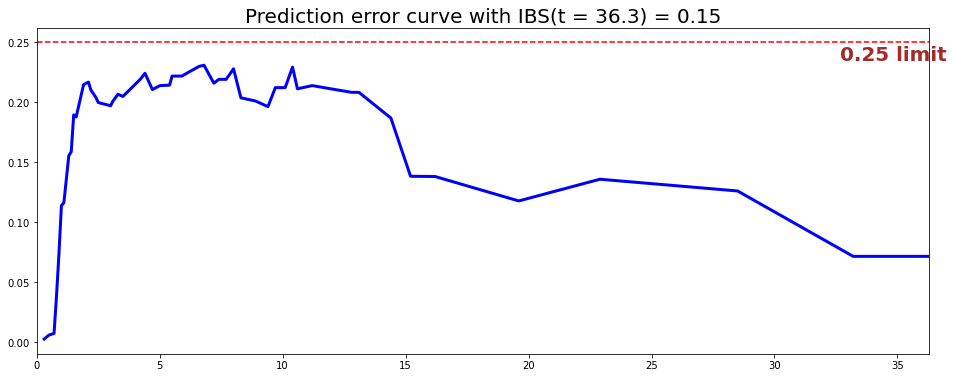

C-index: 0.59
IBS: 0.15


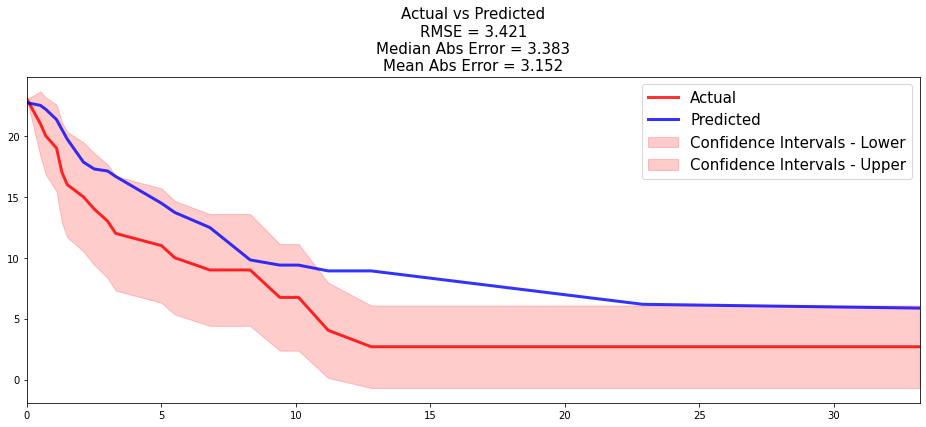

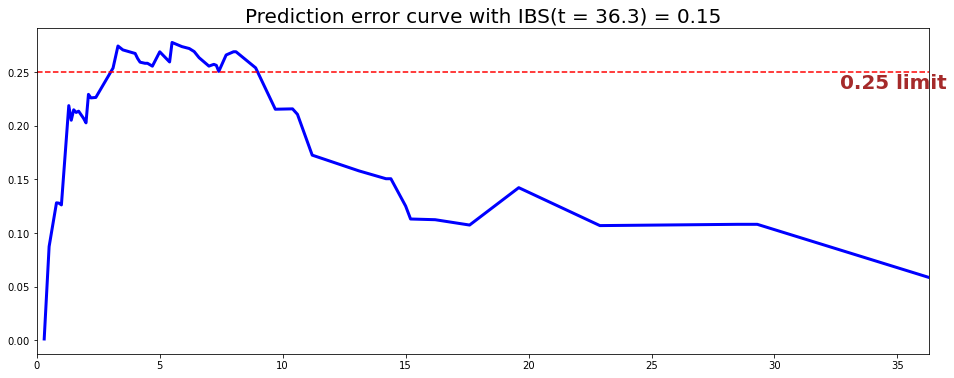

C-index: 0.63
IBS: 0.15


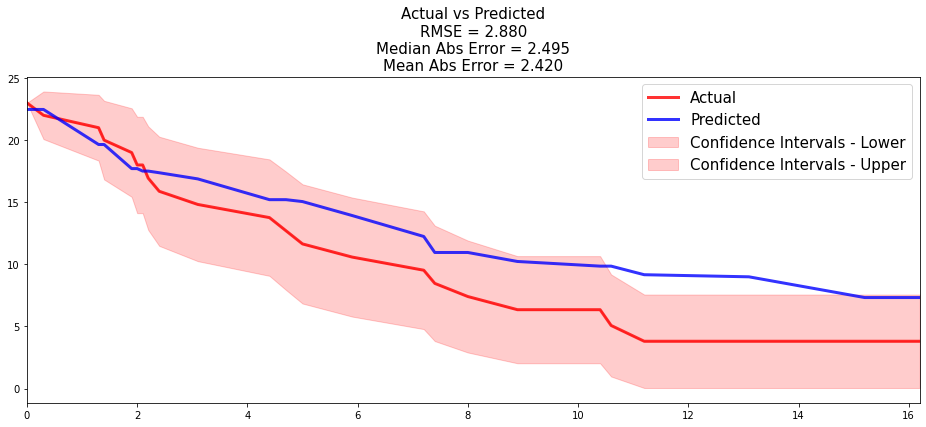

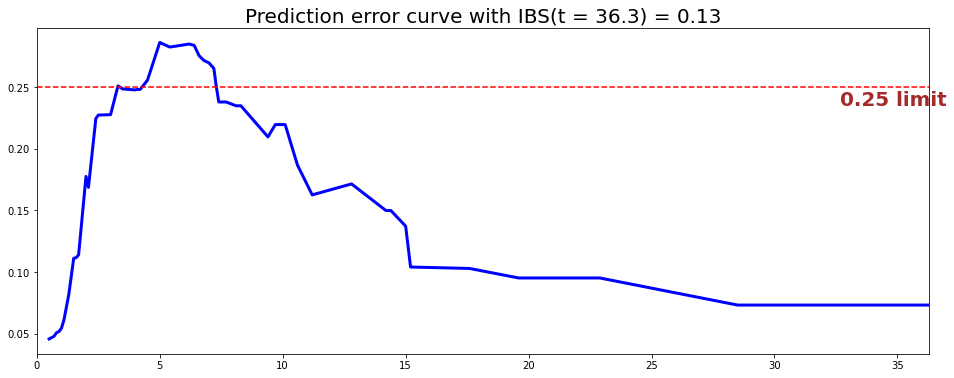

C-index: 0.53
IBS: 0.13
              Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0          Lesion1Dim1  2.359884  1.129695  0.506532  0.283694
1     PTVvolume (cm^3)  1.292529  1.519490  0.266532  0.265161
2  NumLiverLesionsAtRT  1.079708  1.509490  0.226936  0.224516

 

Processing: clin_variables_non_imaging_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_non_imaging_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



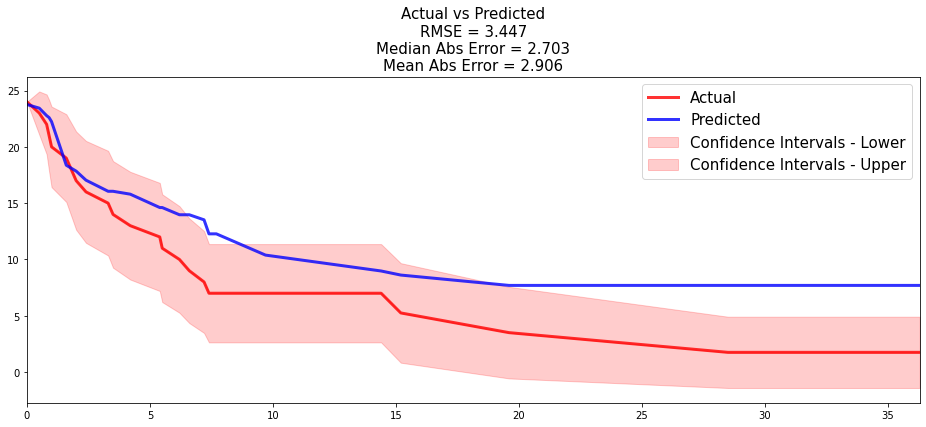

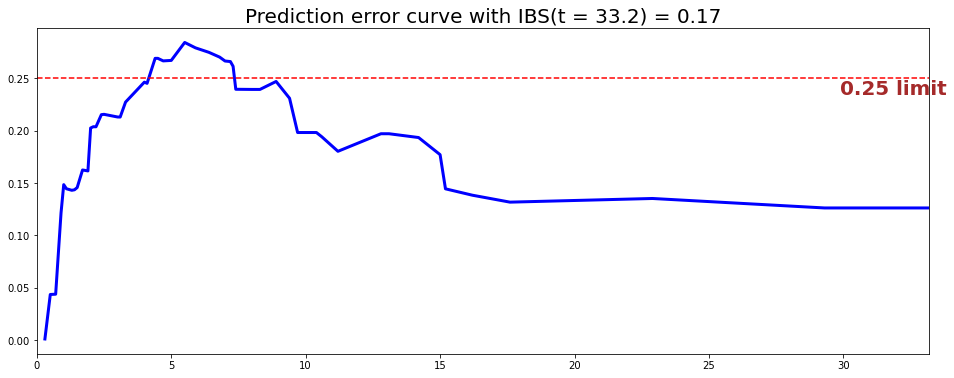

C-index: 0.61
IBS: 0.17


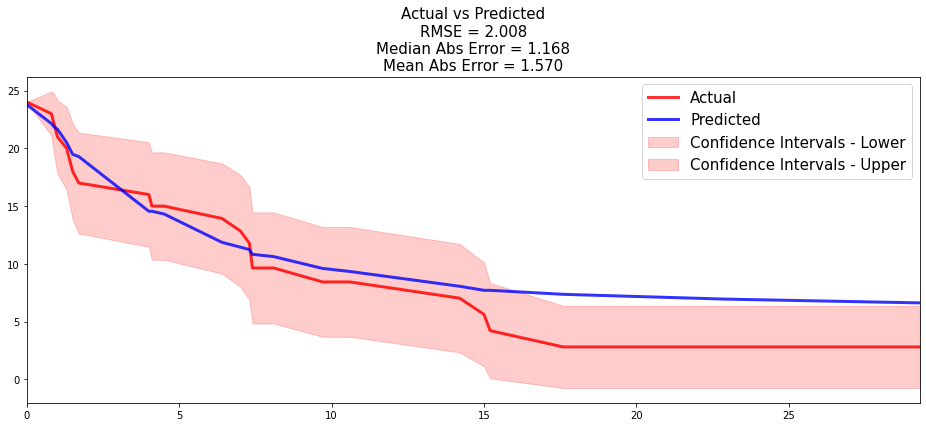

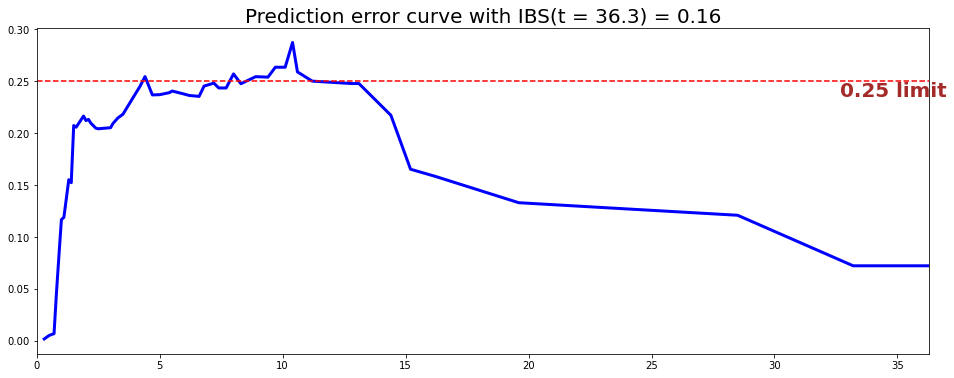

C-index: 0.51
IBS: 0.16


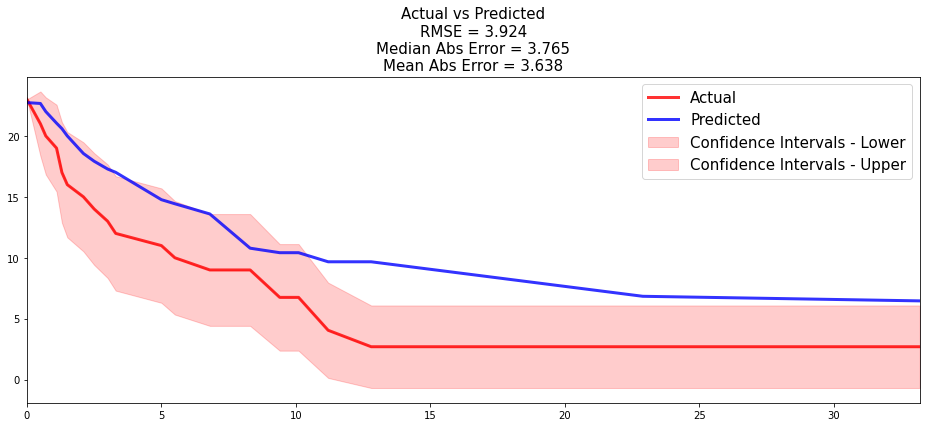

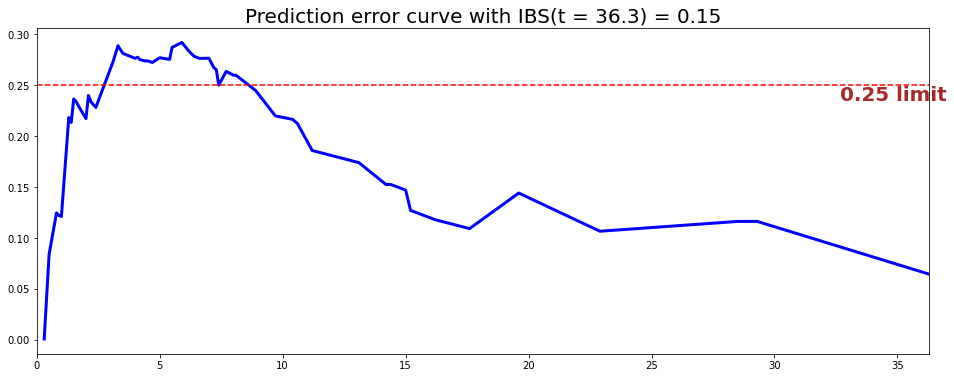

C-index: 0.58
IBS: 0.15


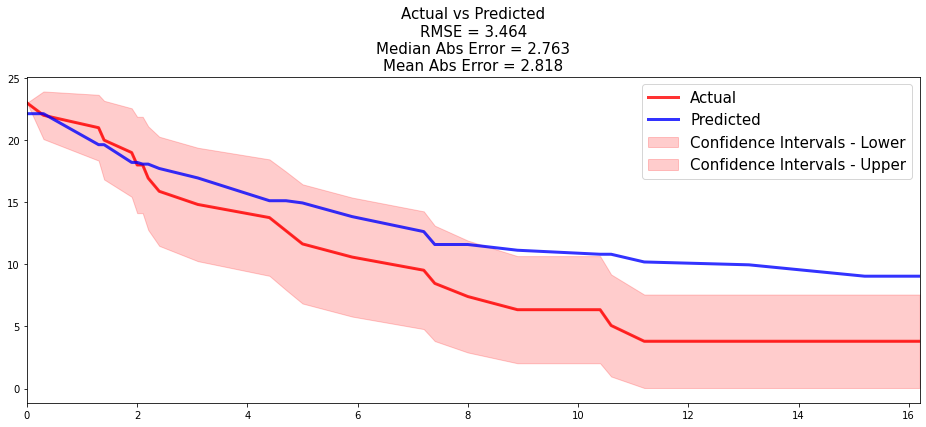

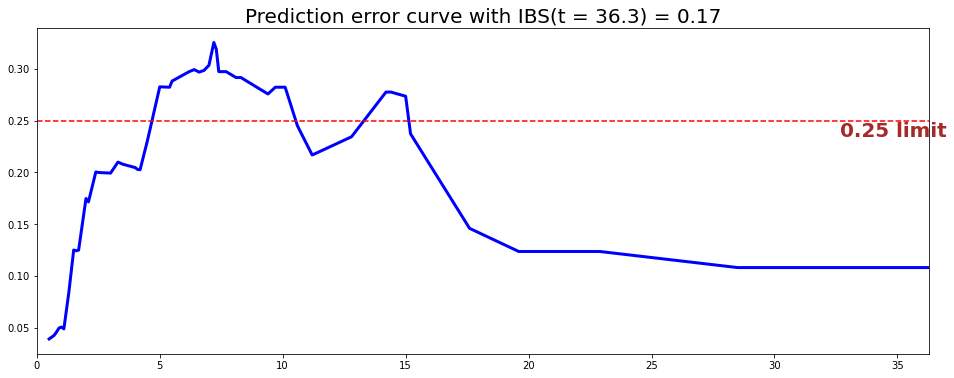

C-index: 0.55
IBS: 0.17
               Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0        Lines of chemo  7.460803  4.346281  0.477673  0.180310
1          PumpBeforeRT  1.280603  2.022429  0.083465  0.101893
2      LiverLocation2Tx  1.258997  1.517200  0.098505  0.087731
3       cM at diagnosis  2.012789  2.548688  0.160045  0.191643
4       SurgeryBeforeRT -0.059739  1.741968  0.049873  0.073837
5           Y90BeforeRT -0.945708  1.337825  0.016153  0.032306
6        RFAtoRTlesions -1.583124  0.959260  0.000000  0.000000
7                  ReTx -0.389377  2.339843  0.058249  0.073430
8           RFAbeforeRT -0.958636  1.245489  0.013726  0.027452
9          DosePainting -1.777104  2.829669  0.042310  0.084619
10  NumLiverLesionsAtDx -3.009347  2.129532  0.000000  0.000000

 

Processing: clin_variables_dosimetric_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_dosimetric_hp.csv

Loading existing gridsearch hyperpa

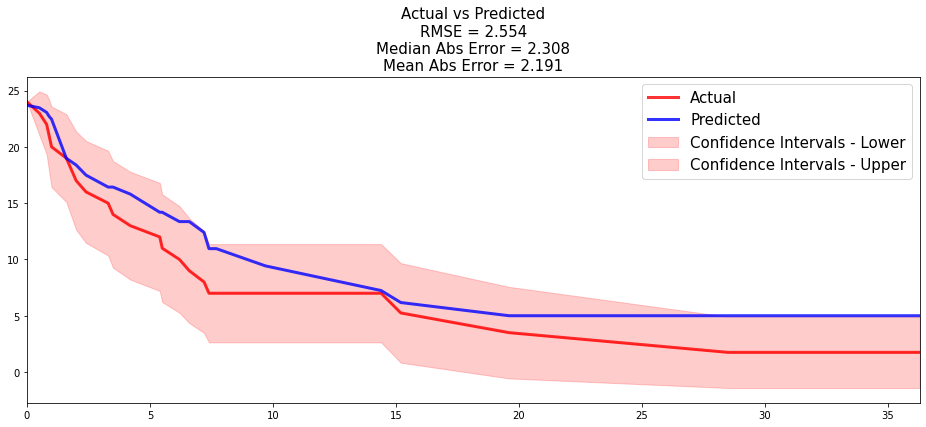

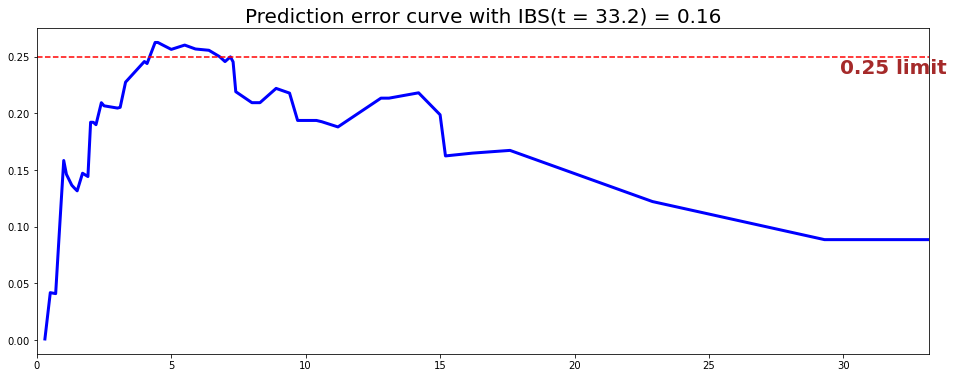

C-index: 0.61
IBS: 0.16


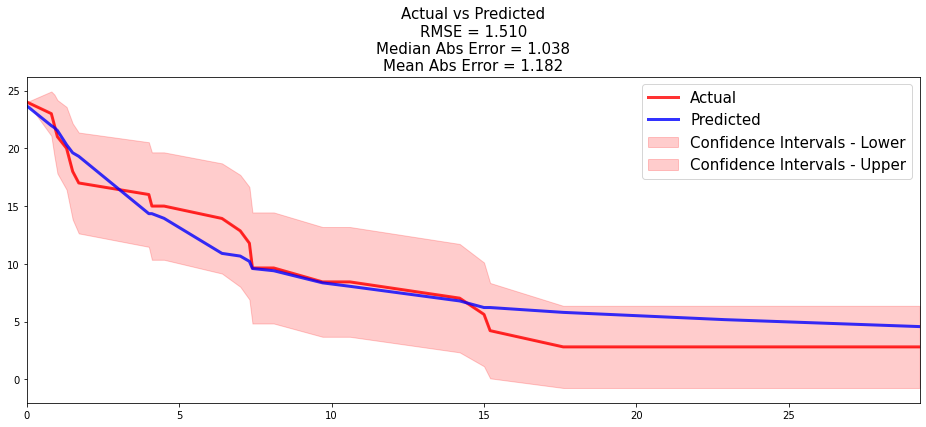

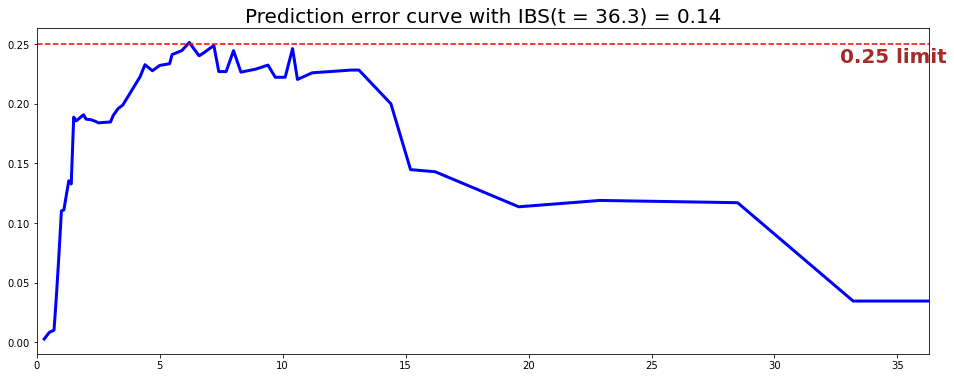

C-index: 0.60
IBS: 0.14


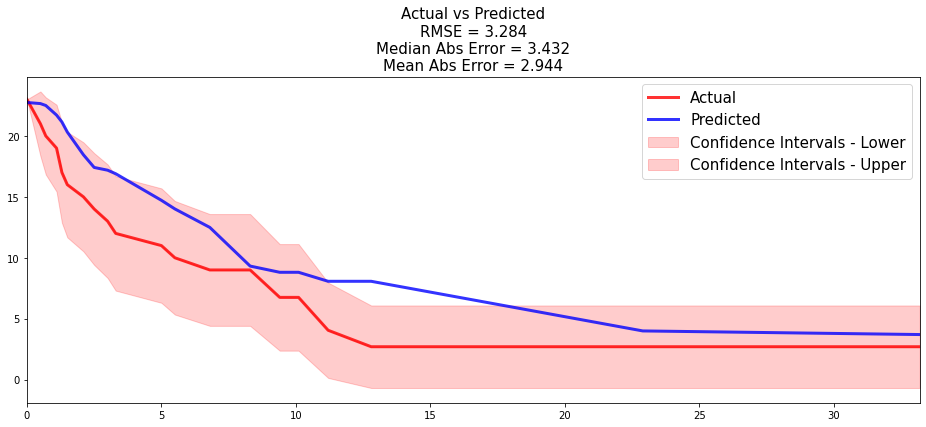

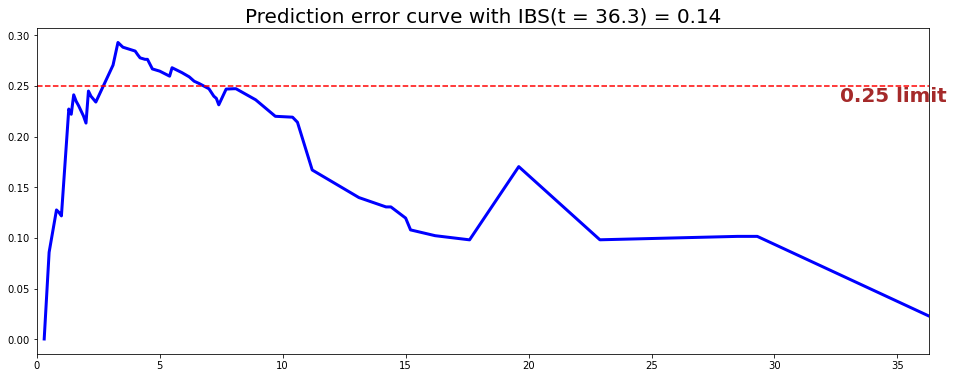

C-index: 0.58
IBS: 0.14


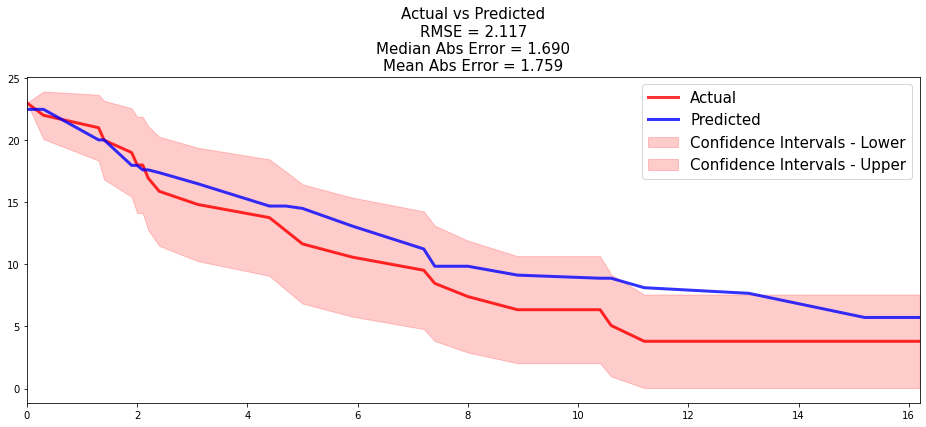

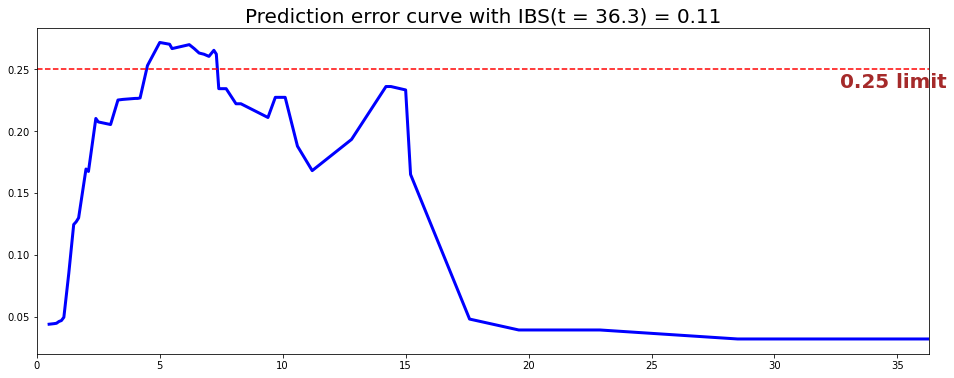

C-index: 0.53
IBS: 0.11
         Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0         CEAatRT  2.734119  1.535762  0.544662  0.079719
1  Lines of chemo  1.962936  0.798219  0.444619  0.093591
2      Dmax (cGy) -0.720074  0.614716  0.000000  0.000000
3    KRASmutation -0.647489  0.880509  0.010719  0.021438

 

Processing: rads_plus_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: rads_plus_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



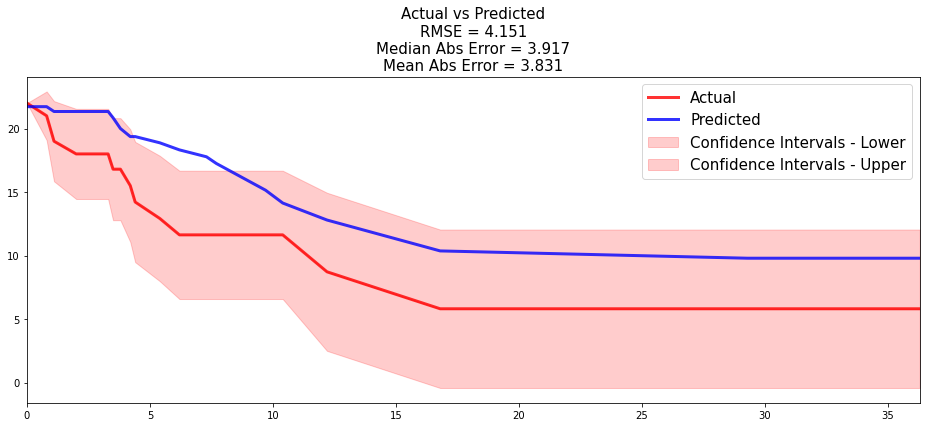

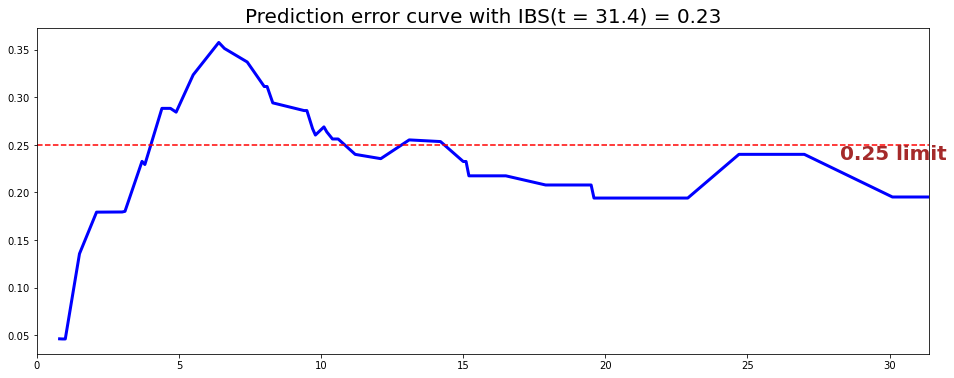

C-index: 0.52
IBS: 0.23


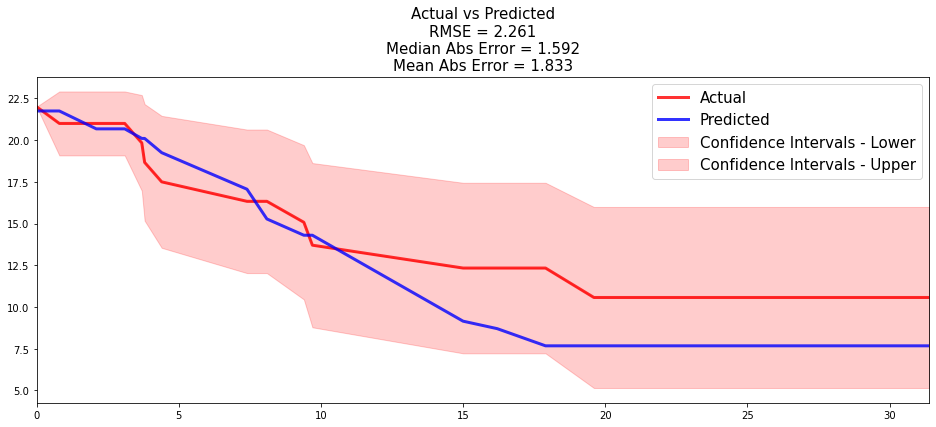

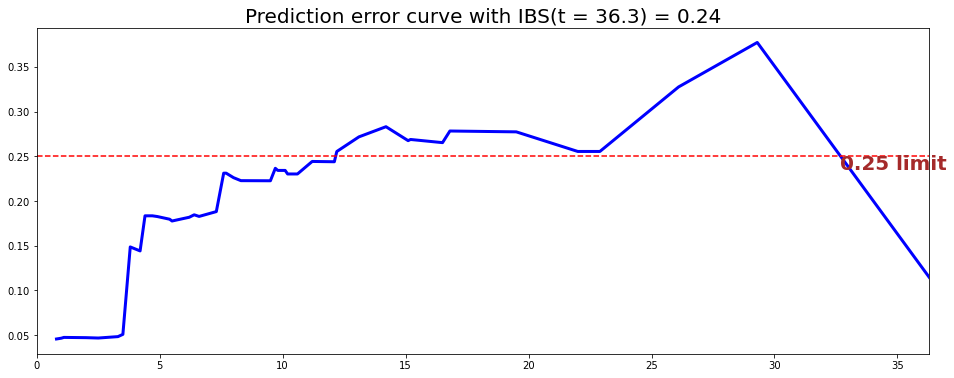

C-index: 0.57
IBS: 0.24


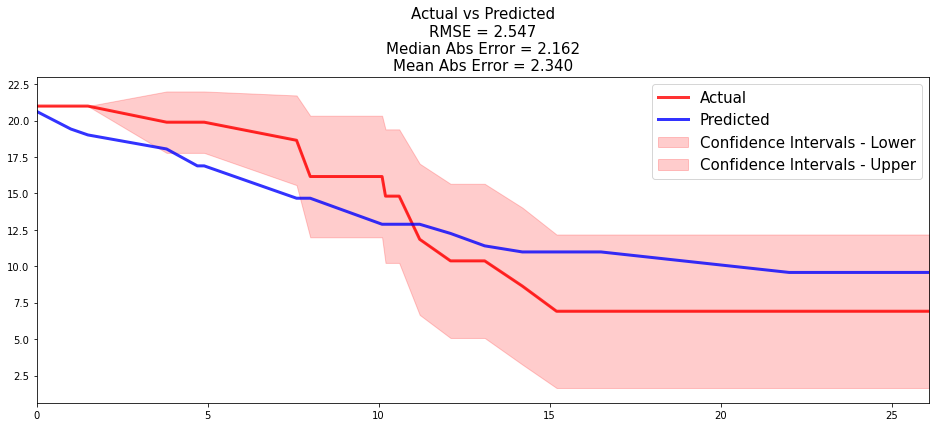

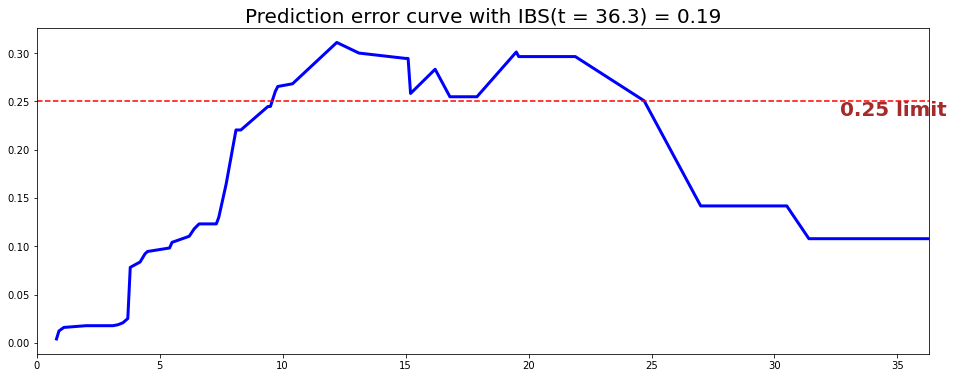

C-index: 0.57
IBS: 0.19


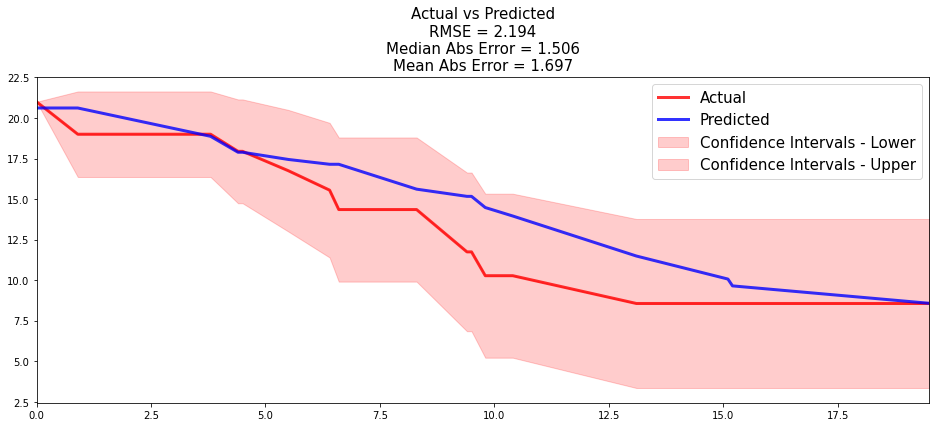

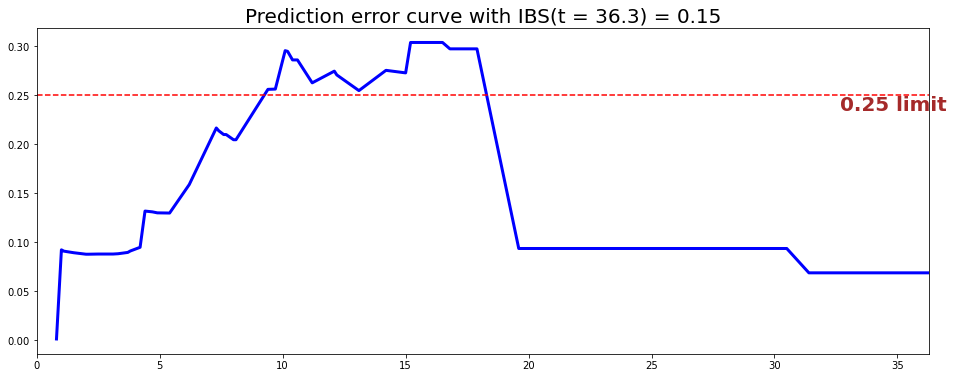

C-index: 0.59
IBS: 0.15
                                            Variable   Imp Avg   Imp Std  \
0                                   PTVvolume (cm^3)  1.419346  0.578532   
1                                     OtherSitesAtRT  0.045985  1.417402   
2               original_glszm_SizeZoneNonUniformity  0.486998  0.787105   
3                       original_firstorder_Skewness -0.470318  1.007555   
4                                        Lesion1Dim2  0.116948  1.289007   
5       original_glszm_LargeAreaLowGrayLevelEmphasis  0.288356  1.326149   
6  original_gldm_LargeDependenceHighGrayLevelEmph... -0.420845  0.579662   
7                                NumLiverLesionsAtRT -0.101339  0.617404   
8                    original_glcm_ClusterProminence -0.325502  0.508171   

    Pct Avg   Pct Std  
0  0.340262  0.066582  
1  0.195192  0.265040  
2  0.107973  0.094023  
3  0.038677  0.077353  
4  0.116699  0.164629  
5  0.119147  0.238294  
6  0.016704  0.033408  
7  0.050092  0.075156  

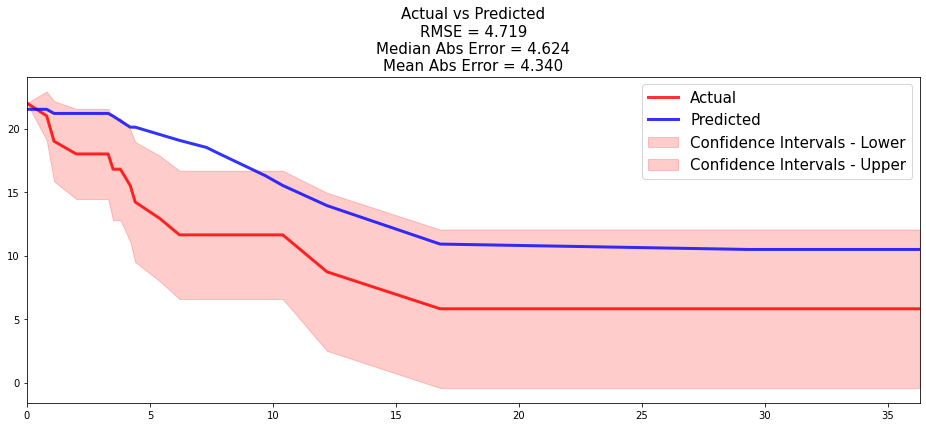

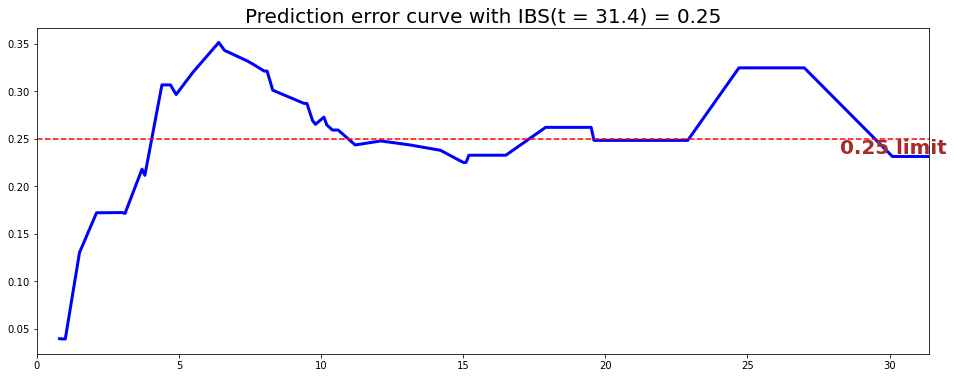

C-index: 0.54
IBS: 0.25


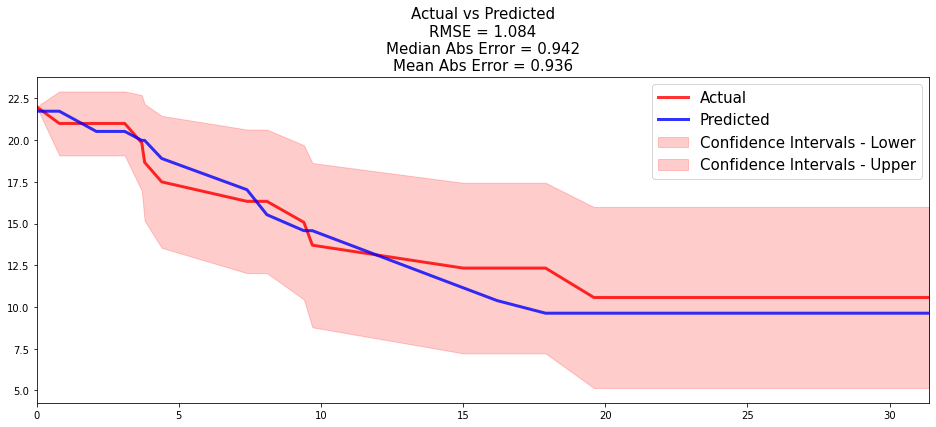

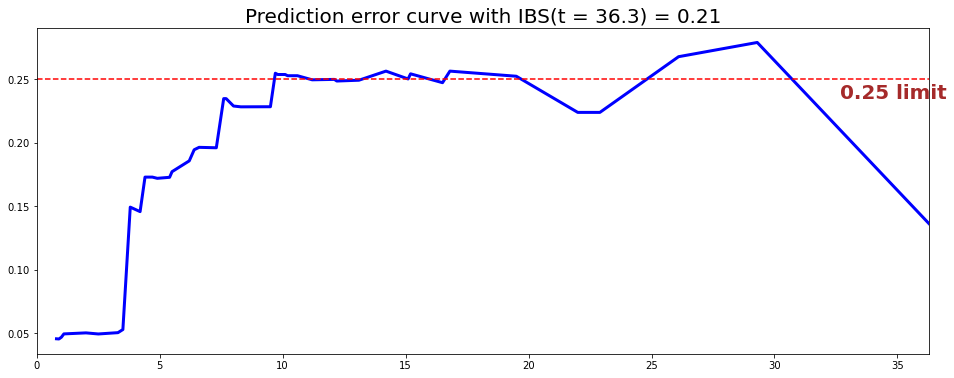

C-index: 0.57
IBS: 0.21


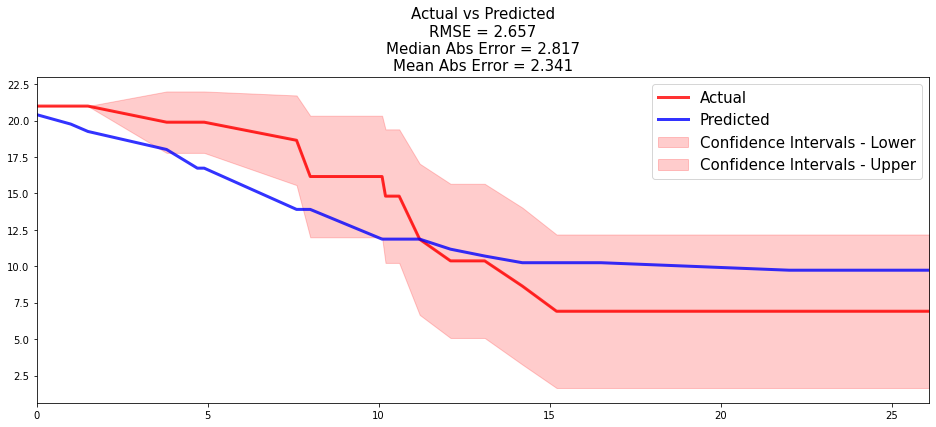

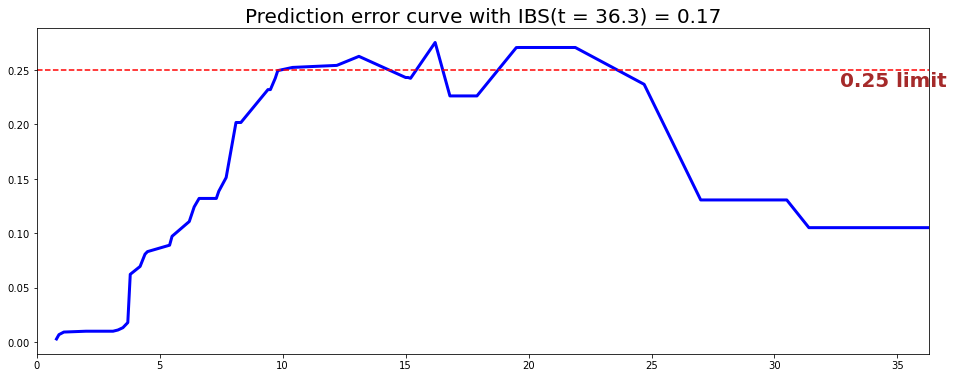

C-index: 0.56
IBS: 0.17


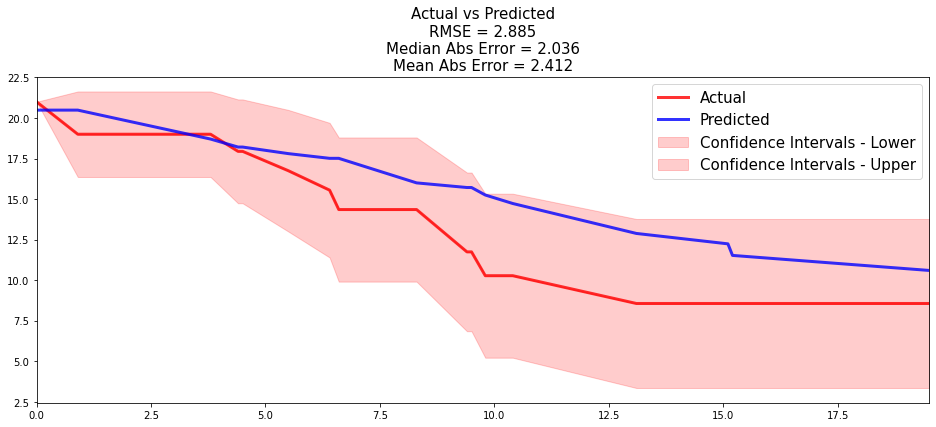

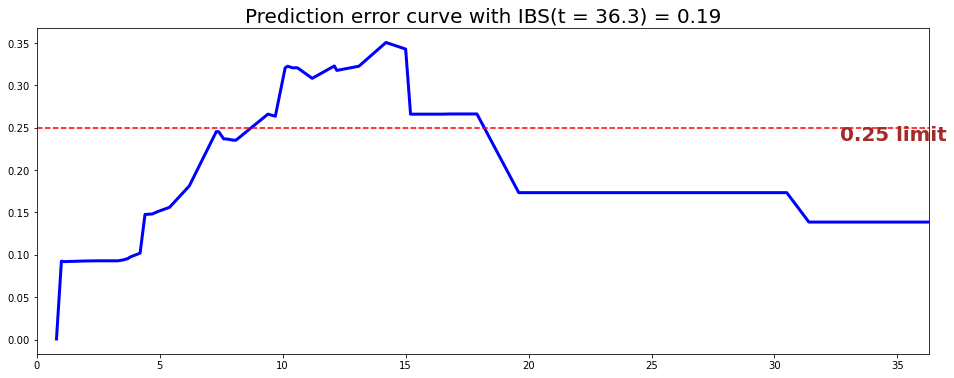

C-index: 0.54
IBS: 0.19
                                          Variable   Imp Avg   Imp Std  \
0  original_glszm_GrayLevelNonUniformityNormalized  0.021130  2.286115   
1   original_glszm_SizeZoneNonUniformityNormalized  0.607899  1.450377   
2                                original_glcm_MCC -0.179620  0.949350   
3     original_glszm_SmallAreaLowGrayLevelEmphasis -0.492467  0.715360   
4                                     DosePainting  0.263523  0.527046   
5                                   RFAtoRTlesions  0.527046  0.608581   
6                                             ReTx  0.000000  0.000000   
7                                 SystemicBeforeRT  0.000000  0.000000   
8                        original_firstorder_Range  0.000000  0.000000   
9                        original_shape_Sphericity -0.480494  1.050115   

    Pct Avg   Pct Std  
0  0.210208  0.245073  
1  0.274082  0.263507  
2  0.071813  0.114212  
3  0.006841  0.013682  
4  0.047321  0.094641  
5  0.342414  0.47

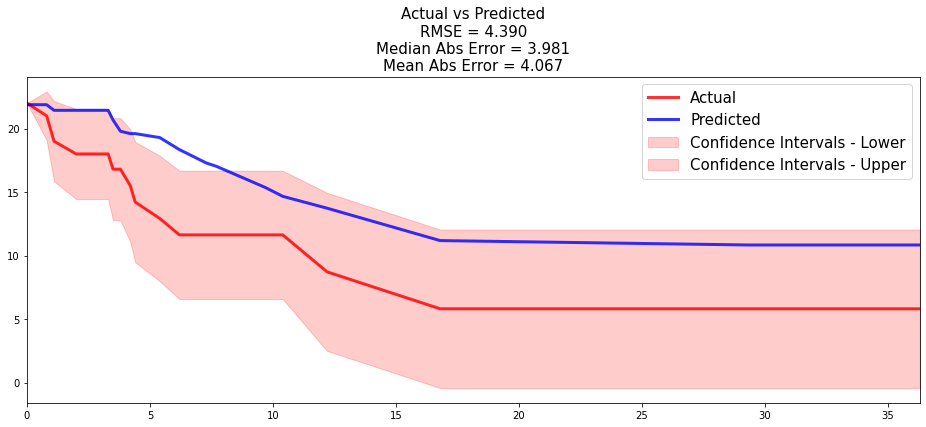

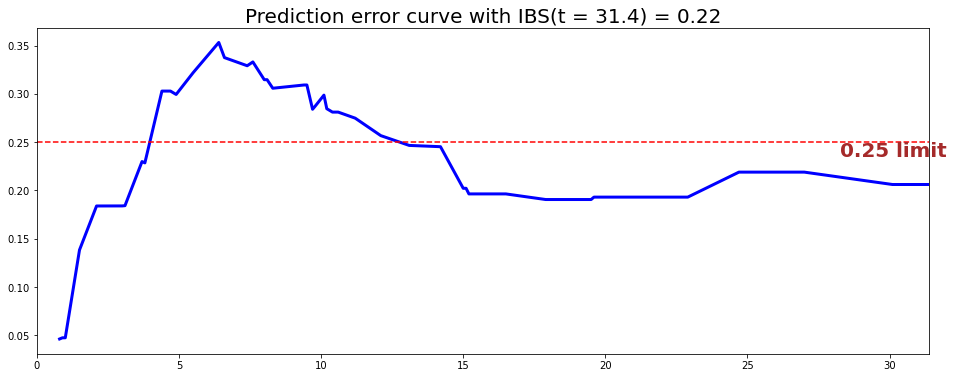

C-index: 0.57
IBS: 0.22


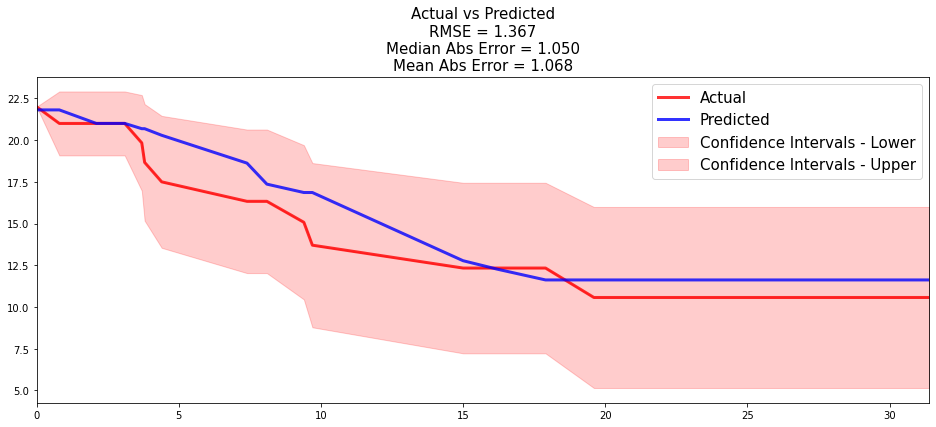

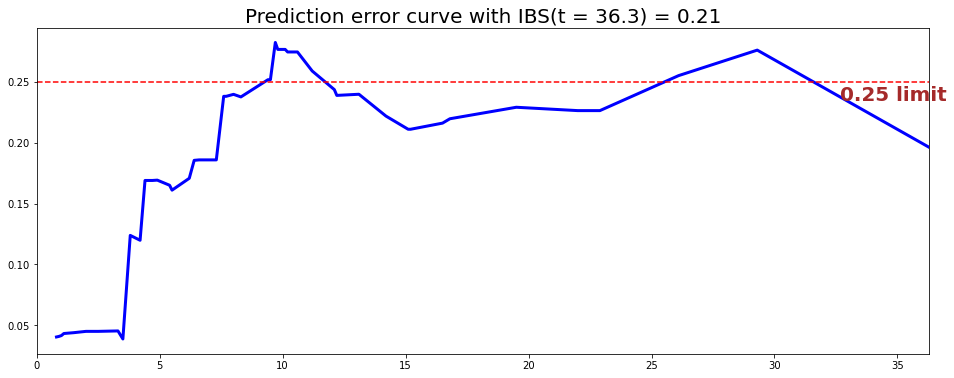

C-index: 0.64
IBS: 0.21


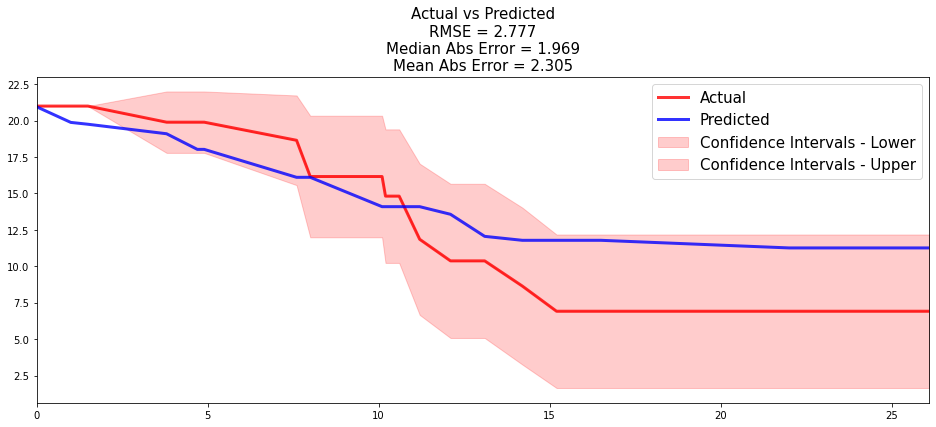

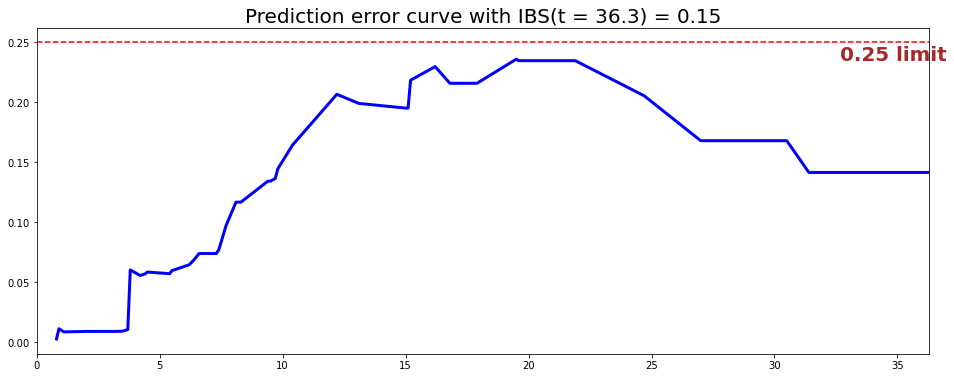

C-index: 0.83
IBS: 0.15


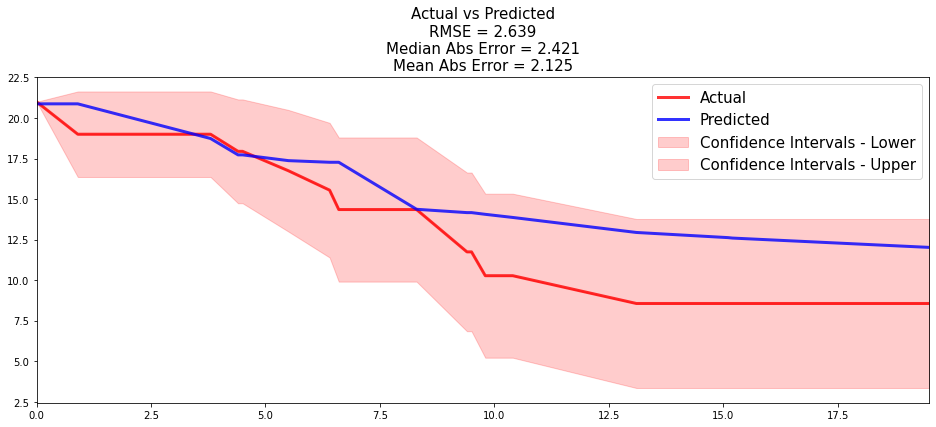

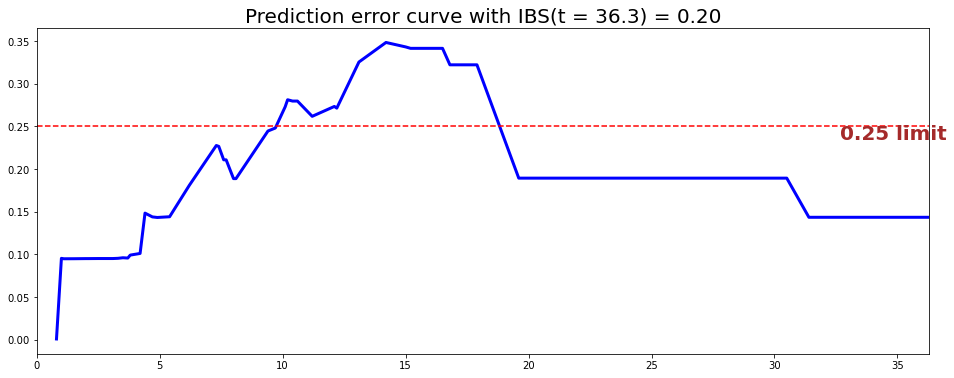

C-index: 0.58
IBS: 0.20
                                       Variable   Imp Avg   Imp Std   Pct Avg  \
0                                    Dmax (cGy)  2.576331  1.271397  0.275133   
1                       original_ngtdm_Strength  1.779810  0.841291  0.185647   
2          original_glszm_SizeZoneNonUniformity  0.790766  1.699705  0.123117   
3                                Lines of chemo  1.144866  0.254003  0.121233   
4                    original_glcm_ClusterShade -0.174899  1.015359  0.033876   
5  original_glszm_LargeAreaLowGrayLevelEmphasis  0.878626  0.954349  0.097673   
6                                  PumpBeforeRT  0.000000  0.000000  0.000000   
7                                       CEAatRT  0.089286  0.780530  0.037377   
8                  original_firstorder_Skewness -0.900928  1.156918  0.014965   
9                                  KRASmutation  0.818336  1.293001  0.110980   

    Pct Std  
0  0.146454  
1  0.082051  
2  0.087006  
3  0.029556  
4  0.043824  


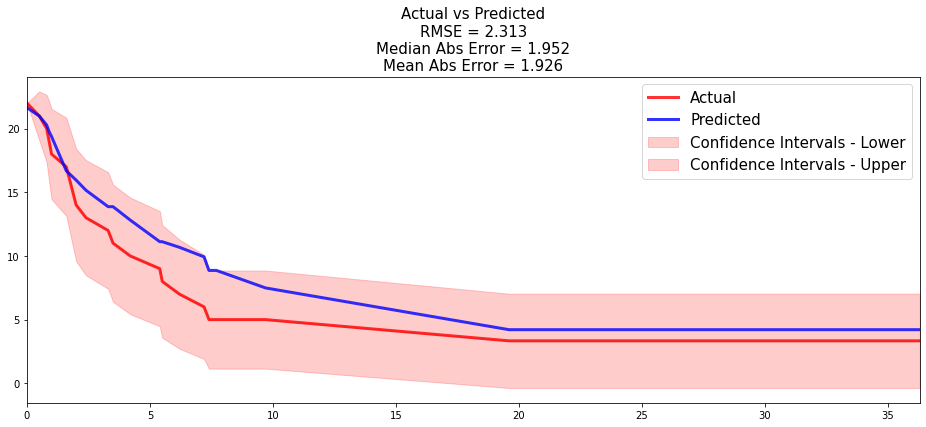

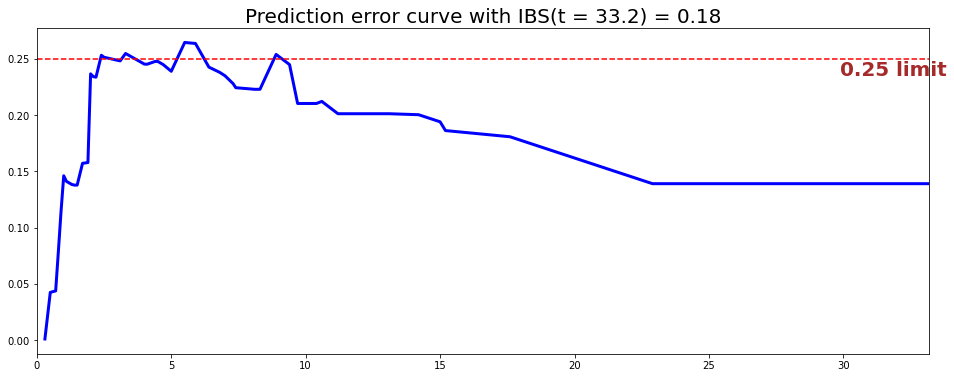

C-index: 0.54
IBS: 0.18


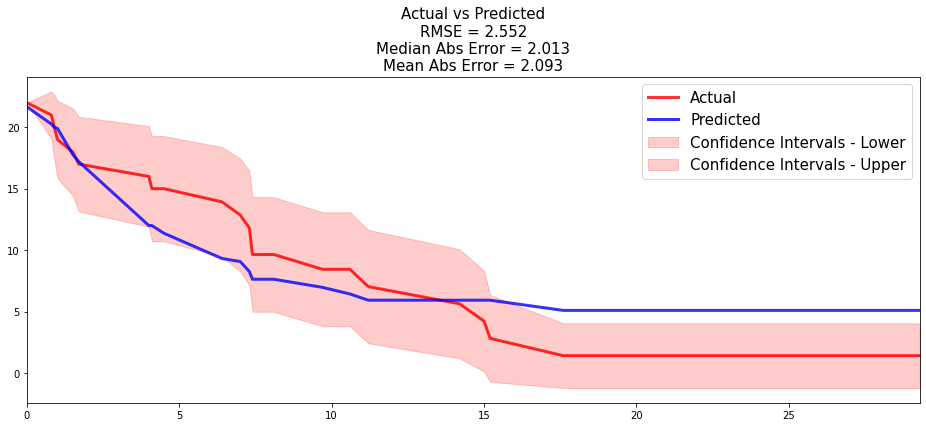

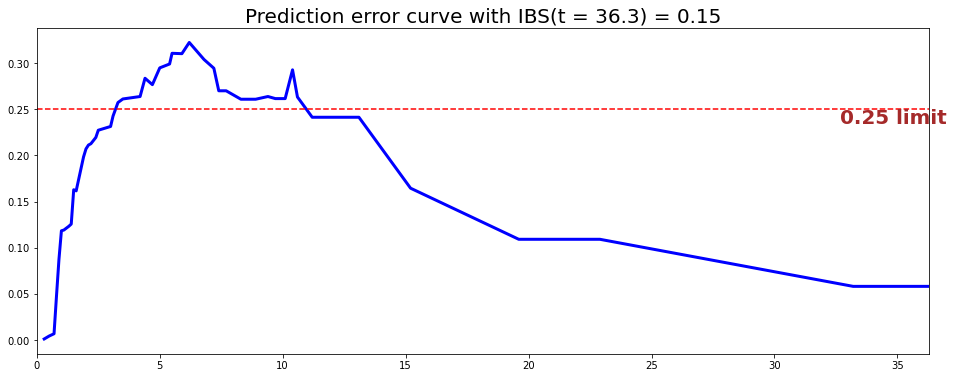

C-index: 0.56
IBS: 0.15


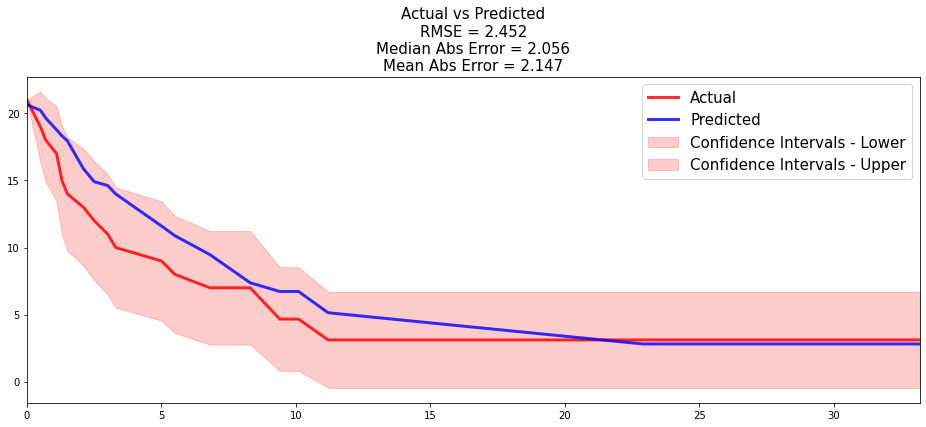

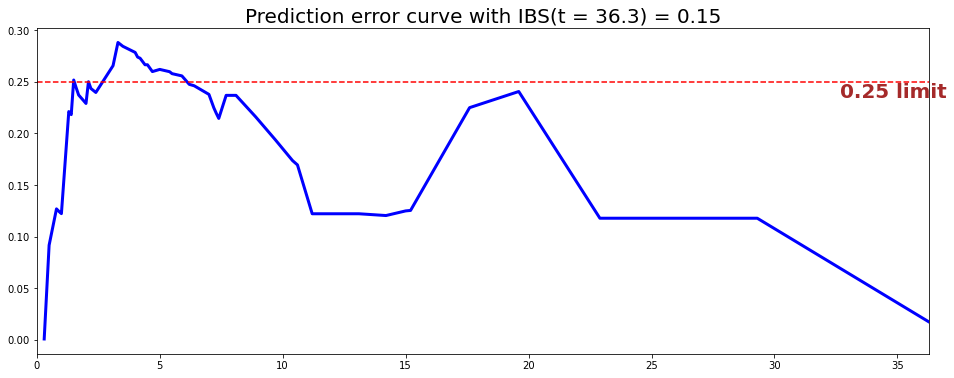

C-index: 0.59
IBS: 0.15


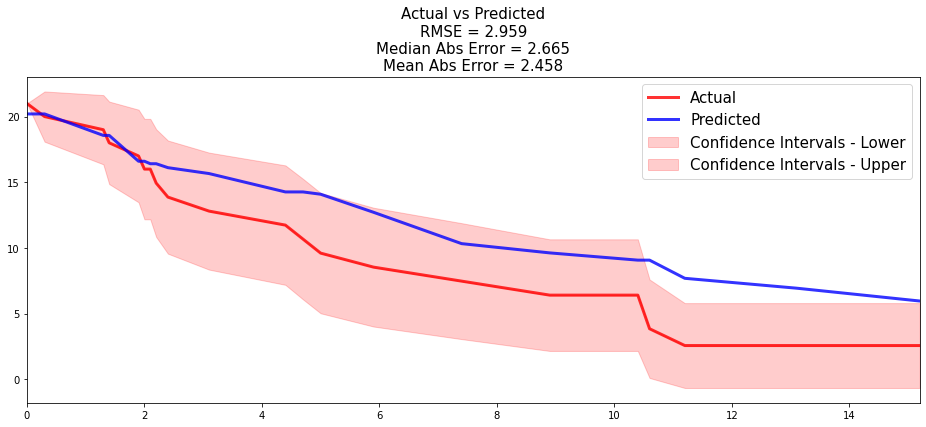

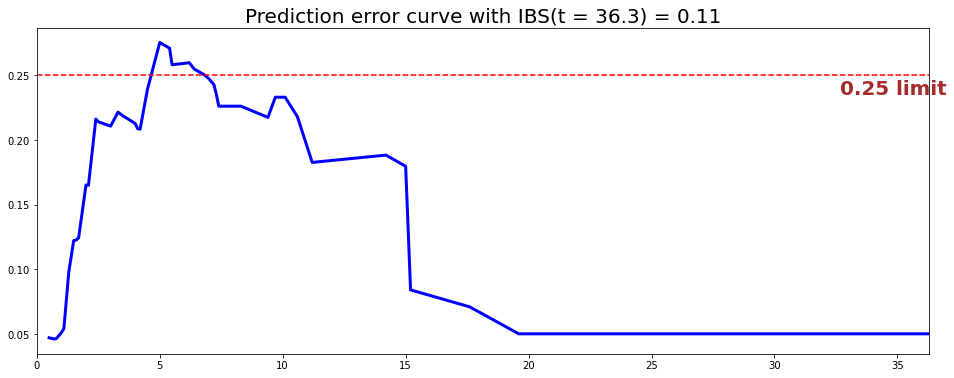

C-index: 0.61
IBS: 0.11
                                            Variable   Imp Avg   Imp Std  \
0                       original_firstorder_Skewness  1.499927  0.515495   
1                                        Lesion1Dim2  0.251636  1.507821   
2  original_gldm_LargeDependenceHighGrayLevelEmph... -0.019760  1.285903   
3       original_glszm_LargeAreaLowGrayLevelEmphasis -0.358312  0.993905   
4                                NumLiverLesionsAtRT  0.263523  0.527046   
5                    original_glcm_ClusterProminence -0.724962  1.260914   
6                                     OtherSitesAtRT  0.383212  1.651090   
7               original_glszm_SizeZoneNonUniformity -0.645175  0.539497   
8                                   PTVvolume (cm^3) -0.757485  1.069177   

    Pct Avg   Pct Std  
0  0.364939  0.177036  
1  0.146108  0.170097  
2  0.101691  0.119316  
3  0.044364  0.088727  
4  0.044555  0.089109  
5  0.044555  0.089109  
6  0.156314  0.196124  
7  0.000000  0.000000  

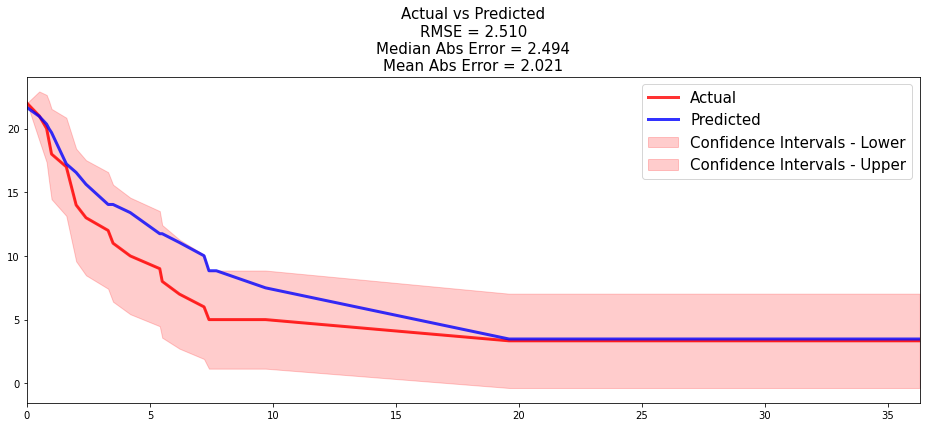

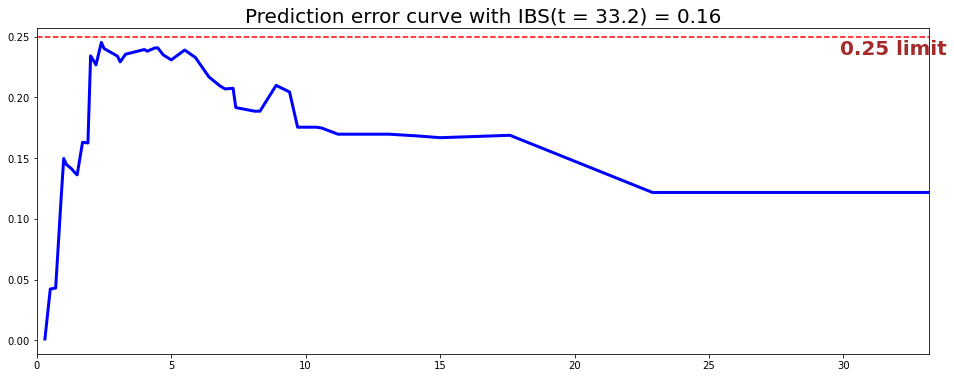

C-index: 0.65
IBS: 0.16


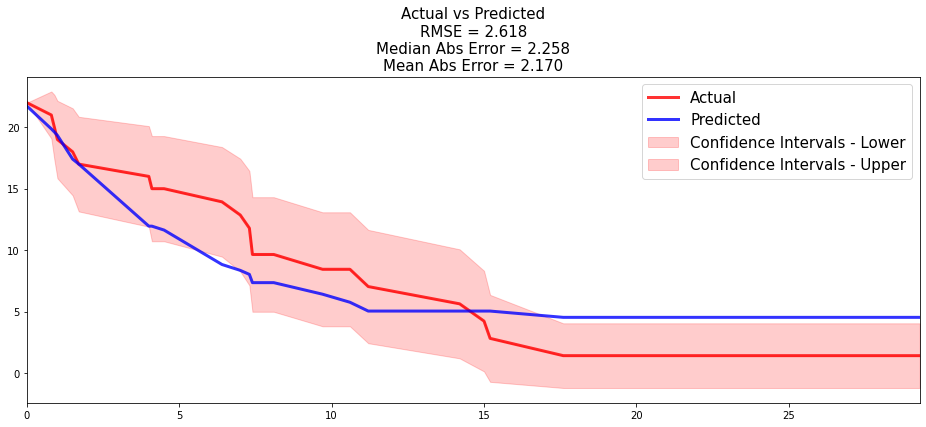

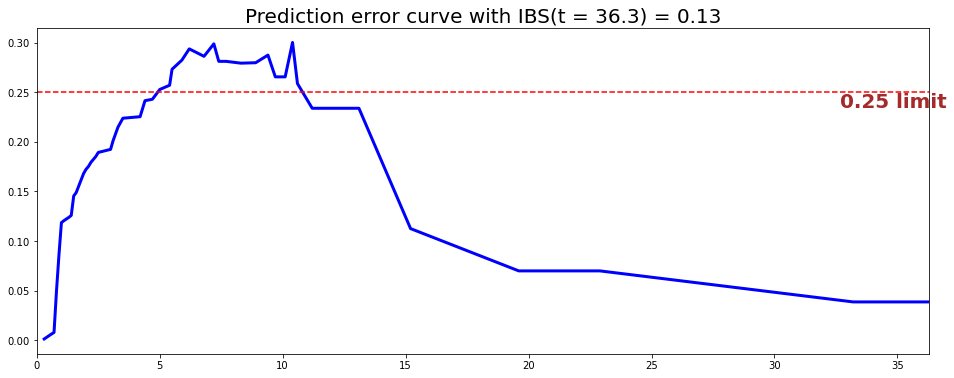

C-index: 0.50
IBS: 0.13


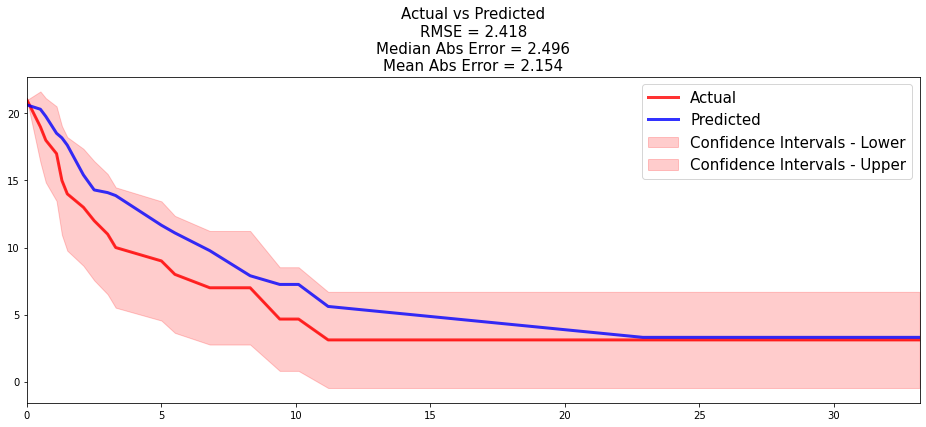

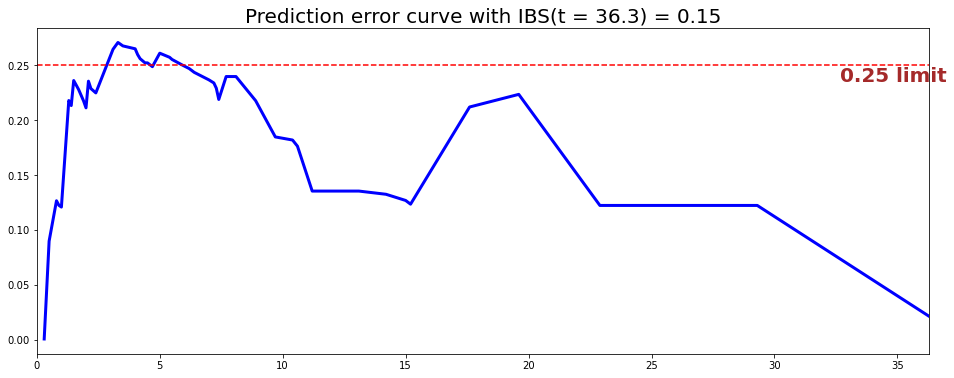

C-index: 0.68
IBS: 0.15


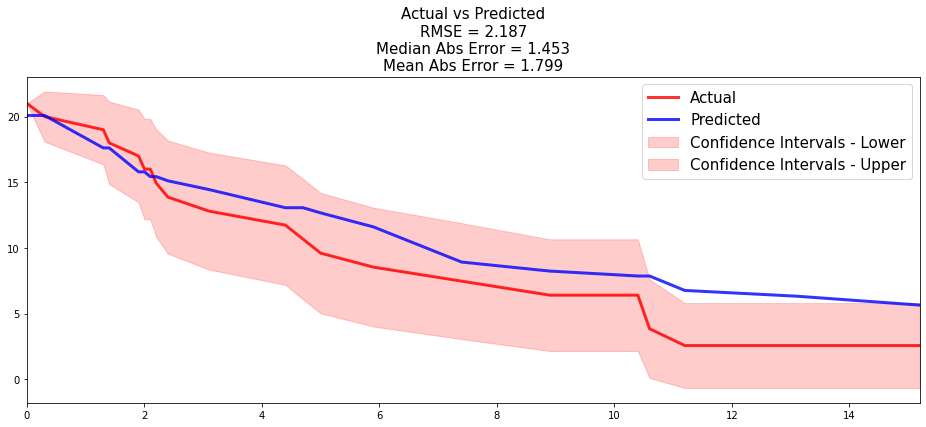

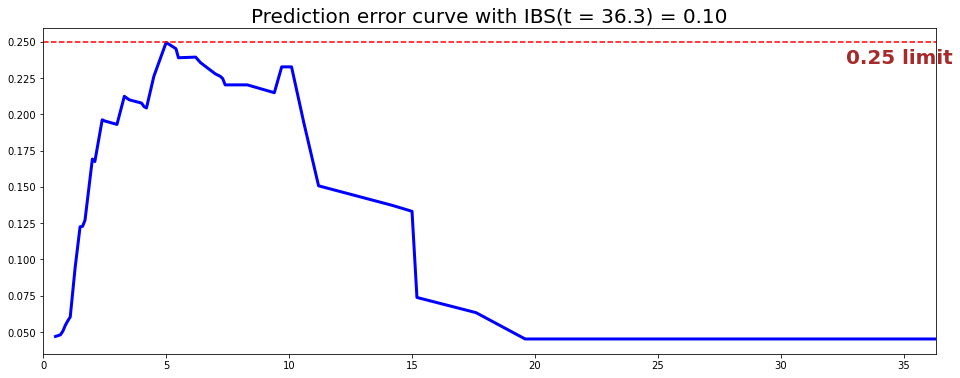

C-index: 0.62
IBS: 0.10
                                          Variable   Imp Avg   Imp Std  \
0                 original_glszm_SmallAreaEmphasis  1.657094  2.128619   
1                                 LiverLocation2Tx  0.553872  0.812555   
2                          original_ngtdm_Contrast  0.394258  1.257332   
3  original_glszm_GrayLevelNonUniformityNormalized  0.775989  1.201689   
4                                   RFAtoRTlesions  0.000000  0.000000   
5                                 SystemicBeforeRT  0.000000  0.000000   
6                        original_firstorder_Range  0.000000  0.000000   
7                                original_glcm_MCC -0.321323  0.912459   
8                original_shape_SurfaceVolumeRatio -1.058308  0.449780   
9     original_glszm_SmallAreaLowGrayLevelEmphasis -1.753905  1.112172   

    Pct Avg   Pct Std  
0  0.432188  0.329171  
1  0.200392  0.314930  
2  0.132681  0.129975  
3  0.150347  0.171567  
4  0.000000  0.000000  
5  0.000000  0.00

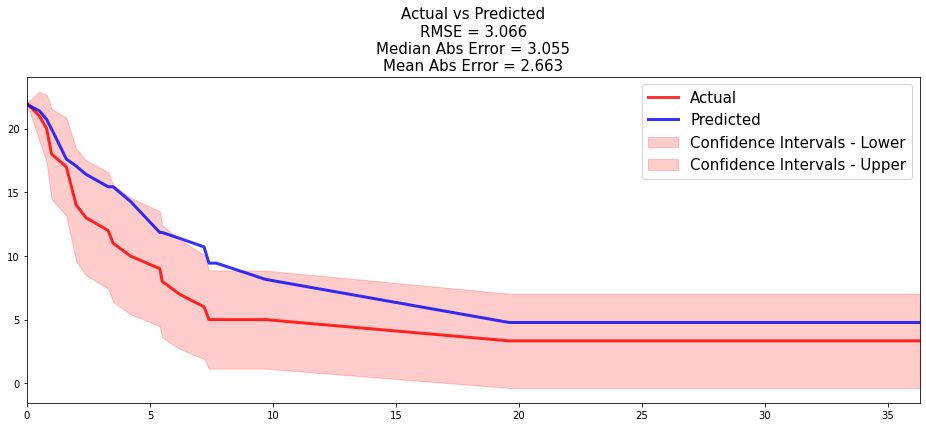

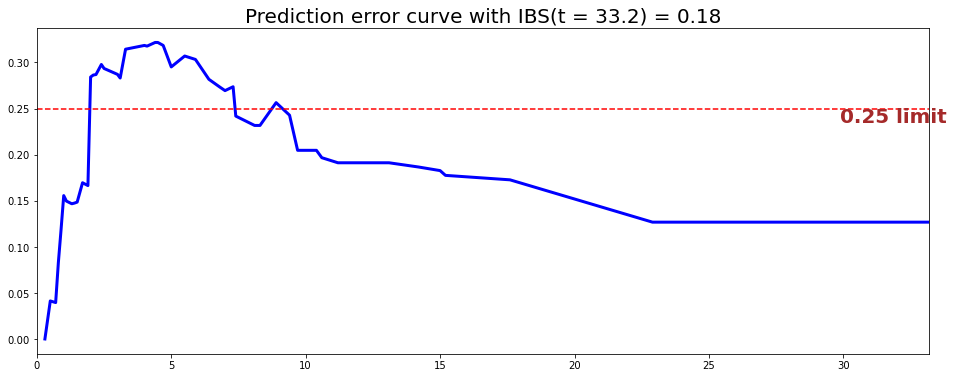

C-index: 0.53
IBS: 0.18


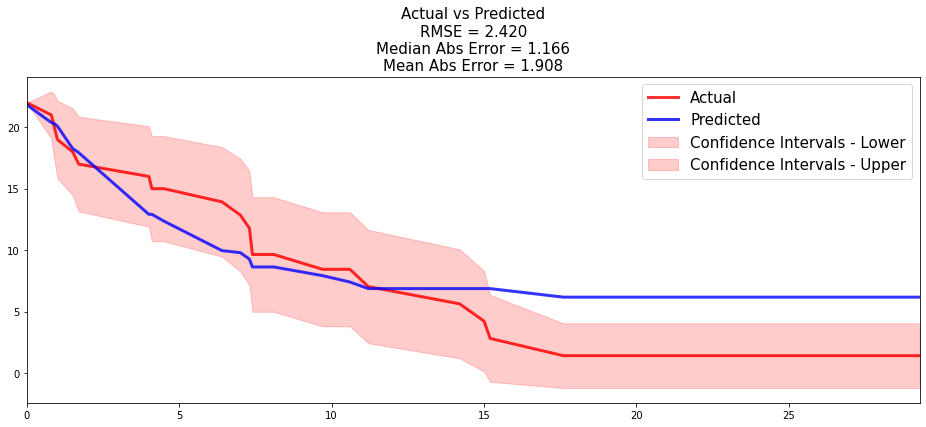

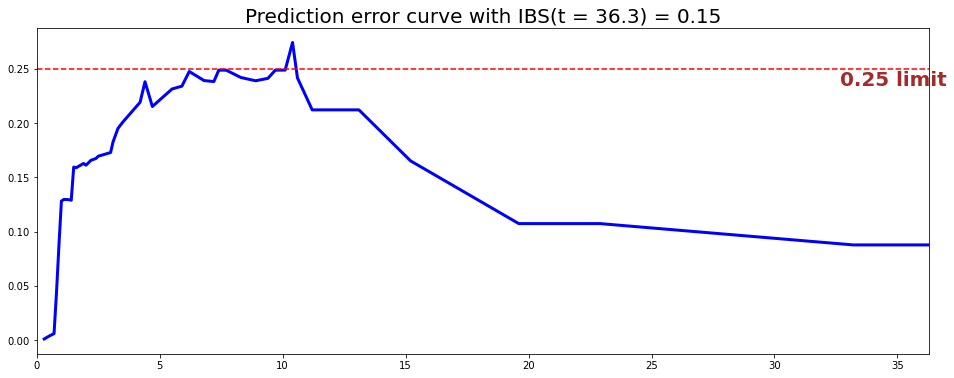

C-index: 0.61
IBS: 0.15


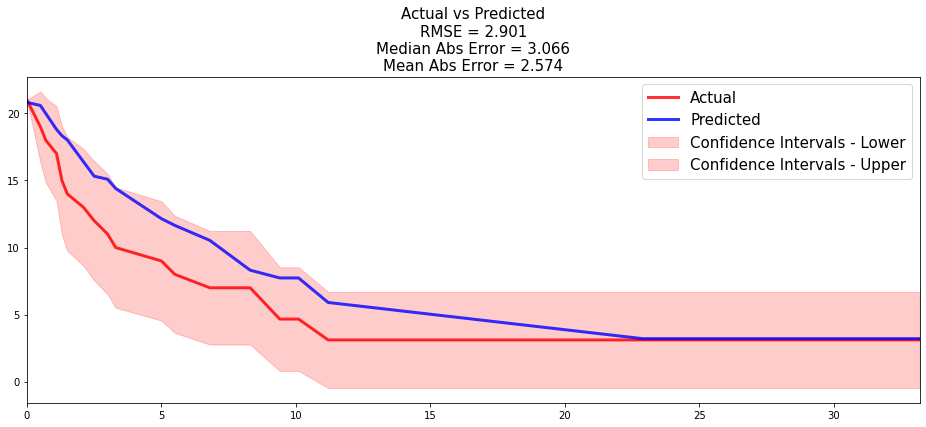

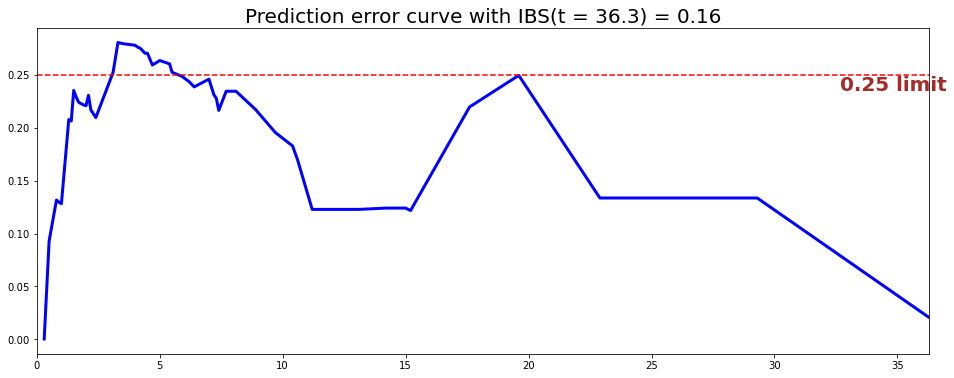

C-index: 0.61
IBS: 0.16


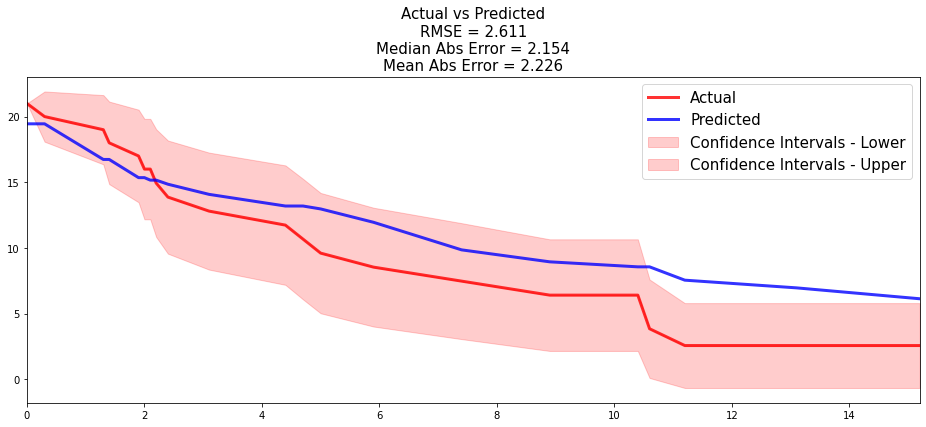

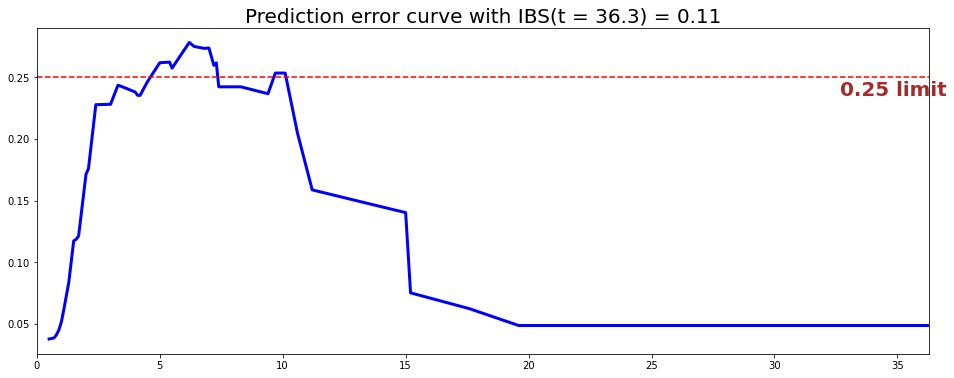

C-index: 0.57
IBS: 0.11
                                            Variable       Imp Avg   Imp Std  \
0                       original_firstorder_Skewness  5.418785e-01  0.388753   
1                                            CEAatRT  3.570094e-01  1.025322   
2                                       PumpBeforeRT -5.337294e-01  0.616394   
3       original_glszm_LargeAreaLowGrayLevelEmphasis -3.330812e-01  0.934281   
4               original_glszm_SizeZoneNonUniformity -1.803841e-01  0.963555   
5                                       KRASmutation  1.110223e-16  1.217161   
6                    original_glcm_ClusterProminence -1.071150e+00  0.532316   
7                                     Lines of chemo -9.027347e-01  1.209403   
8                                         Dmax (cGy) -5.638680e-01  0.846888   
9  original_gldm_LargeDependenceHighGrayLevelEmph... -2.781616e-02  1.995706   

    Pct Avg   Pct Std  
0  0.316597  0.326552  
1  0.137705  0.161196  
2  0.000000  0.000000  

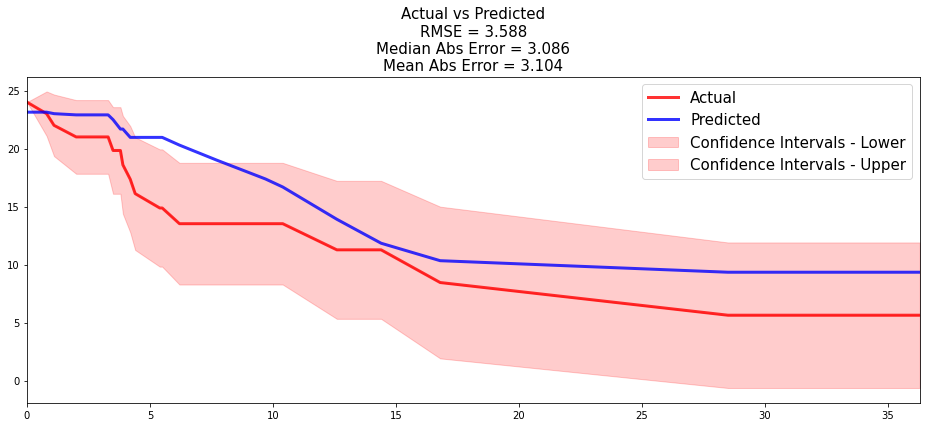

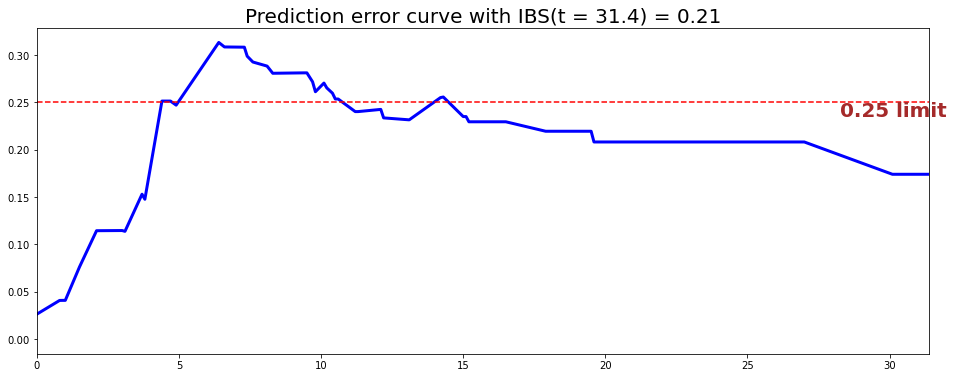

C-index: 0.62
IBS: 0.21


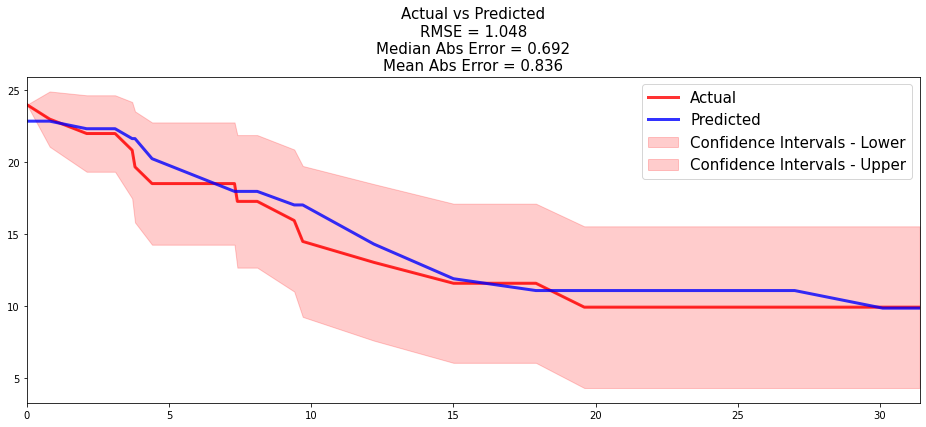

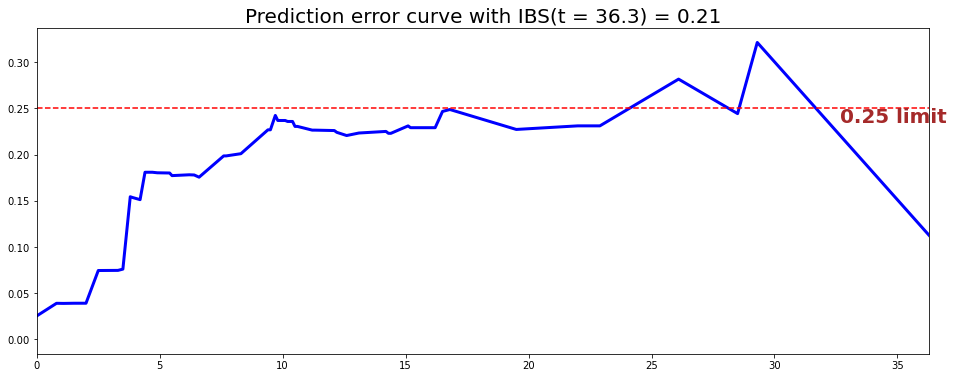

C-index: 0.66
IBS: 0.21


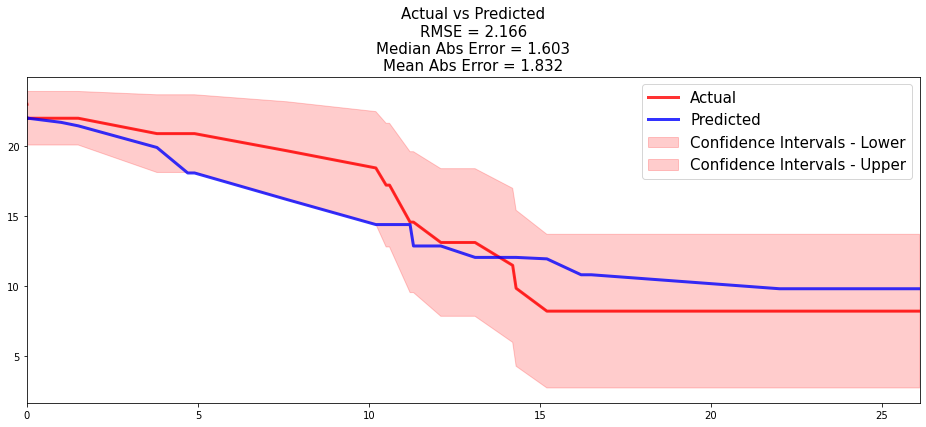

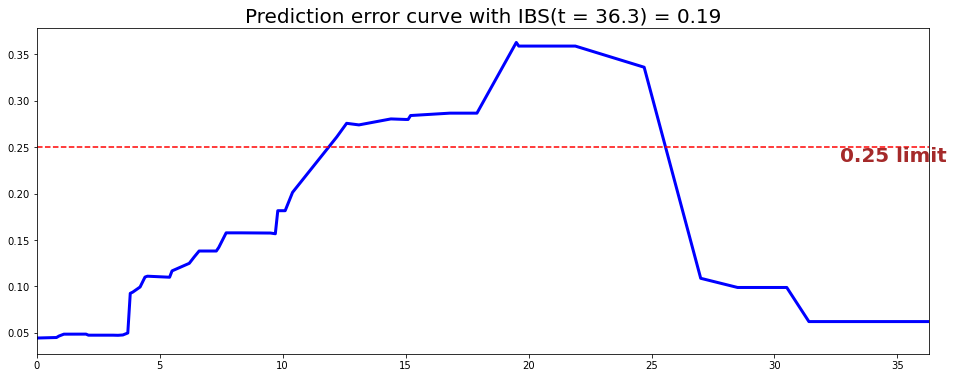

C-index: 0.55
IBS: 0.19


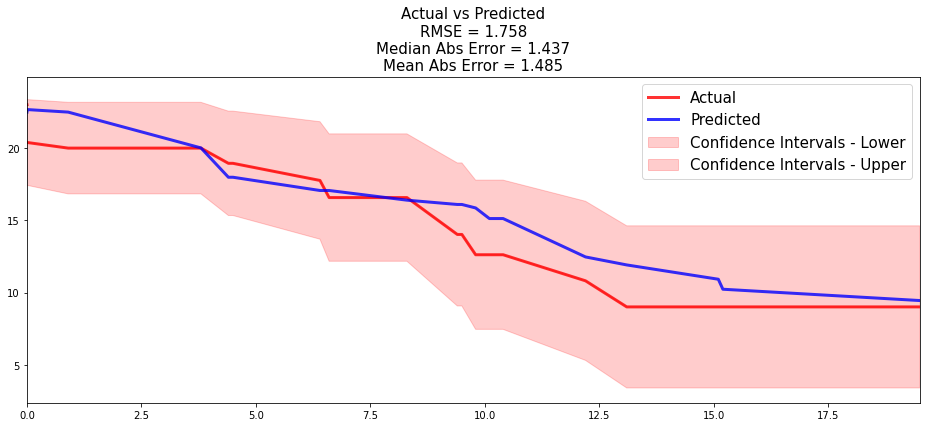

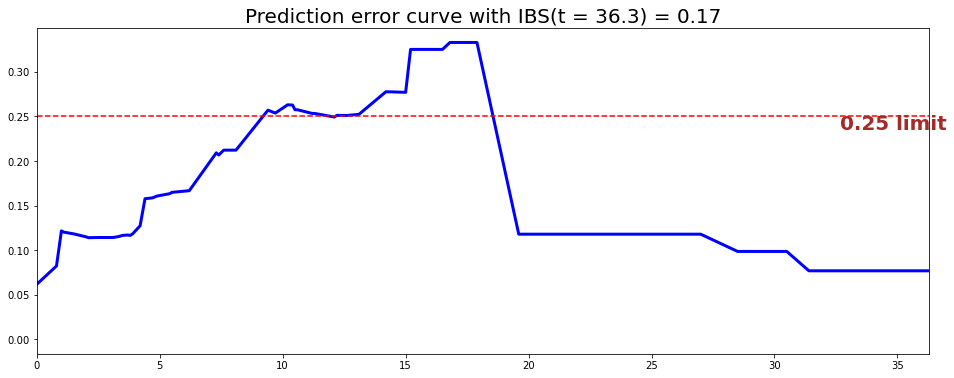

C-index: 0.51
IBS: 0.17
               Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0   NumLiverLesionsAtRT  0.763737  2.289631  0.242371  0.291333
1        RFAtoRTlesions  0.256495  0.512989  0.073391  0.146782
2        RTtoOtherSites  0.034605  1.583447  0.128237  0.148190
3          KRASmutation -0.291124  0.796764  0.077025  0.111616
4  EmbolizationBeforeRT  0.000000  0.000000  0.000000  0.000000
5           Y90BeforeRT  0.000000  0.000000  0.000000  0.000000
6          PumpBeforeRT -1.407363  0.788517  0.000000  0.000000
7           RFAbeforeRT -0.226307  1.424677  0.228975  0.363439
8      LiverLocation2Tx  0.109156  1.023747  0.250000  0.500000

 

Processing: clin_variables_all_hp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_all_hp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



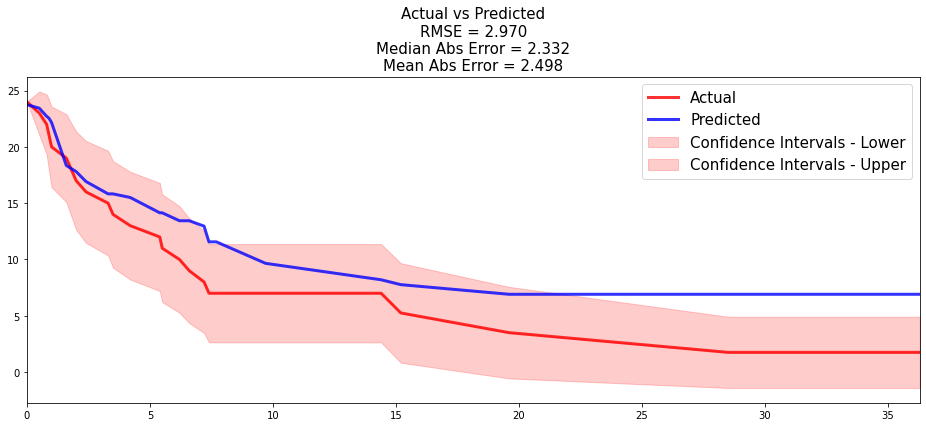

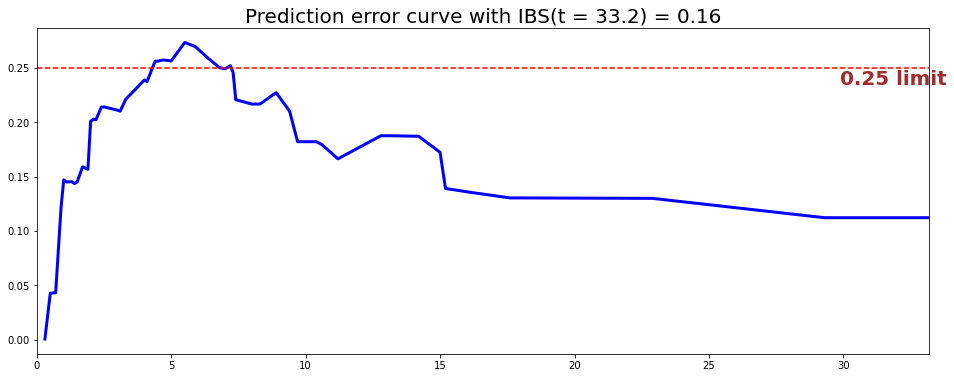

C-index: 0.62
IBS: 0.16


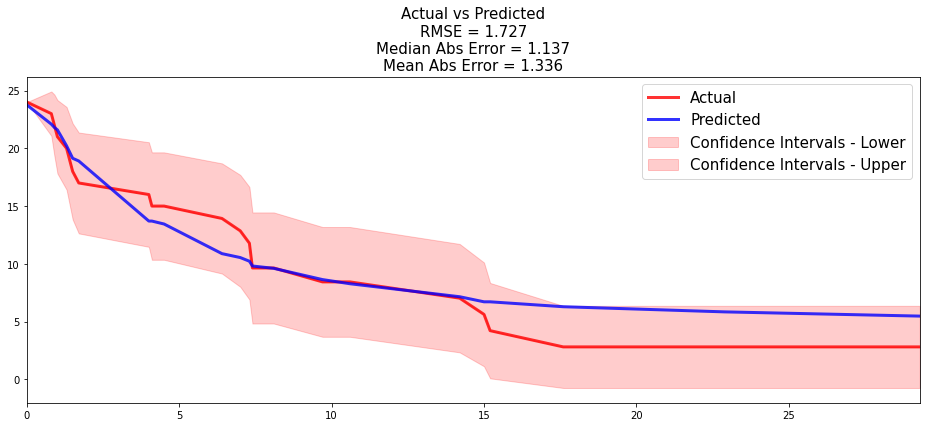

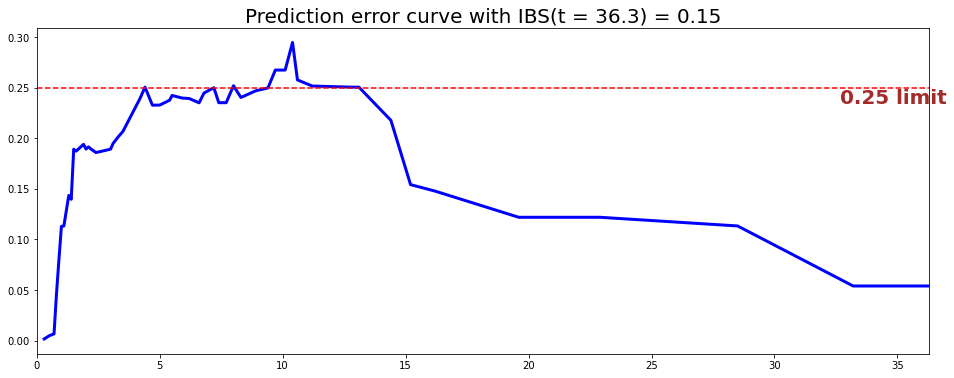

C-index: 0.57
IBS: 0.15


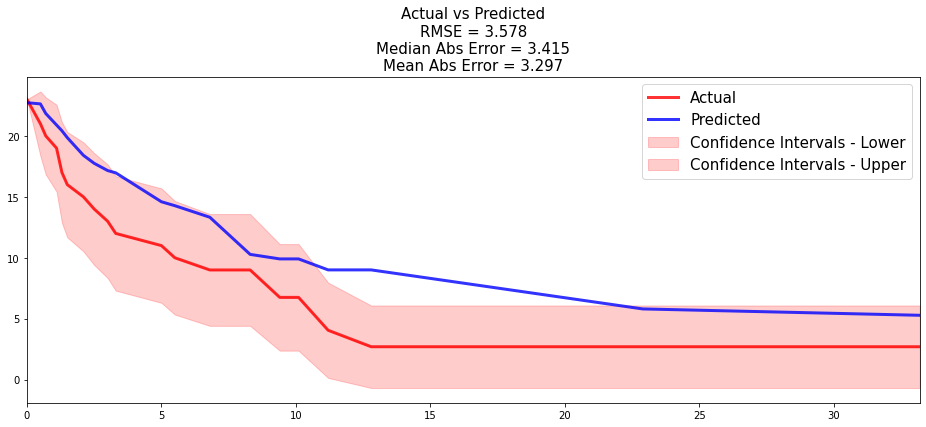

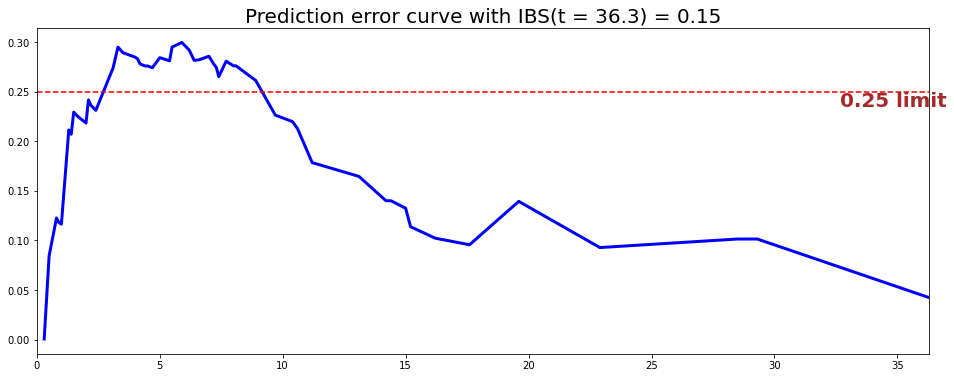

C-index: 0.59
IBS: 0.15


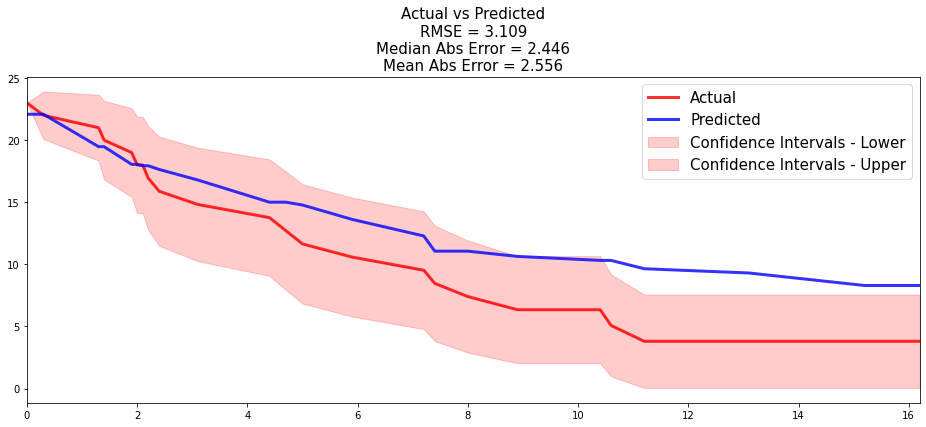

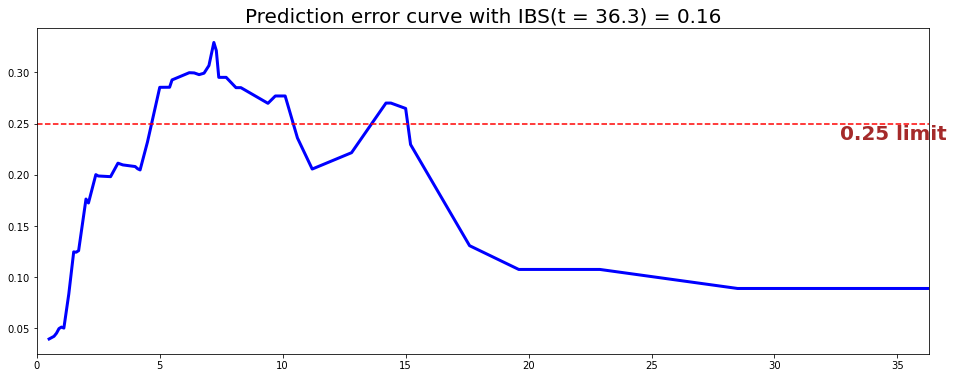

C-index: 0.55
IBS: 0.16
           Variable   Imp Avg   Imp Std   Pct Avg   Pct Std
0    Lines of chemo  7.594115  3.438558  0.522918  0.309265
1   cM at diagnosis  1.485135  2.214993  0.110466  0.120548
2  LiverLocation2Tx  1.457933  1.525557  0.101053  0.089494
3      PumpBeforeRT  0.524988  1.846634  0.066943  0.079544
4              ReTx -0.541835  1.853389  0.027451  0.054903
5       RFAbeforeRT -0.663318  1.947414  0.029333  0.058666
6   SurgeryBeforeRT  0.673737  1.647671  0.064964  0.057922
7      DosePainting -0.657325  3.653274  0.073398  0.146797
8    RFAtoRTlesions -1.424503  1.108467  0.003473  0.006946

 

Processing: all_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: all_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...



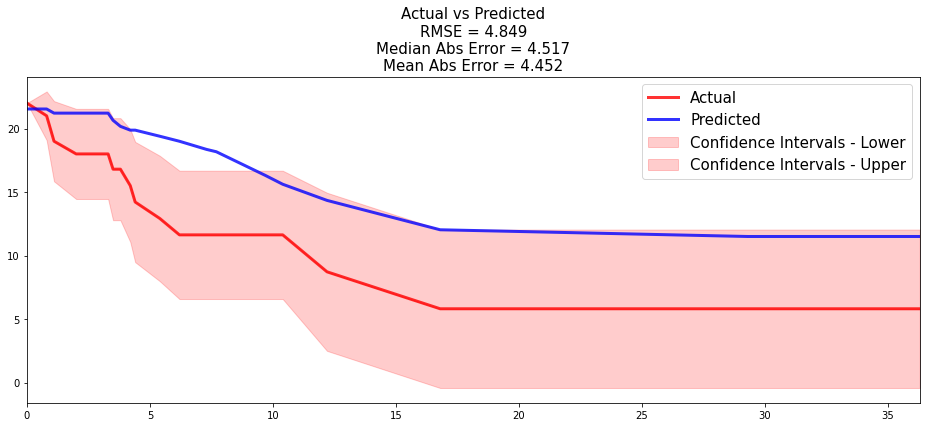

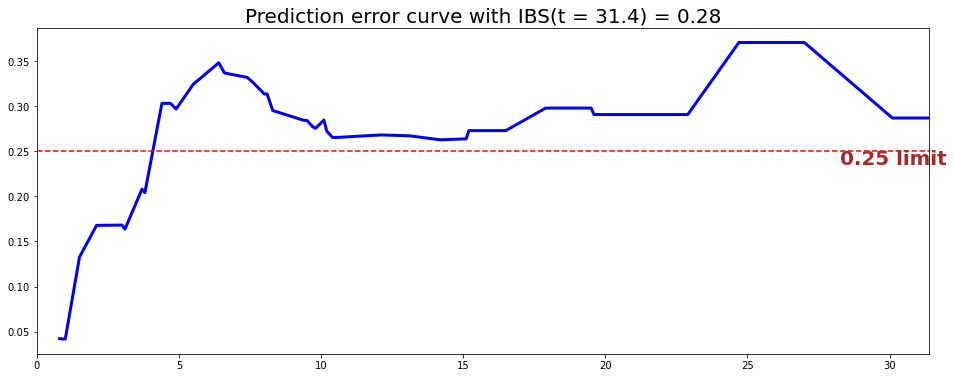

C-index: 0.58
IBS: 0.28


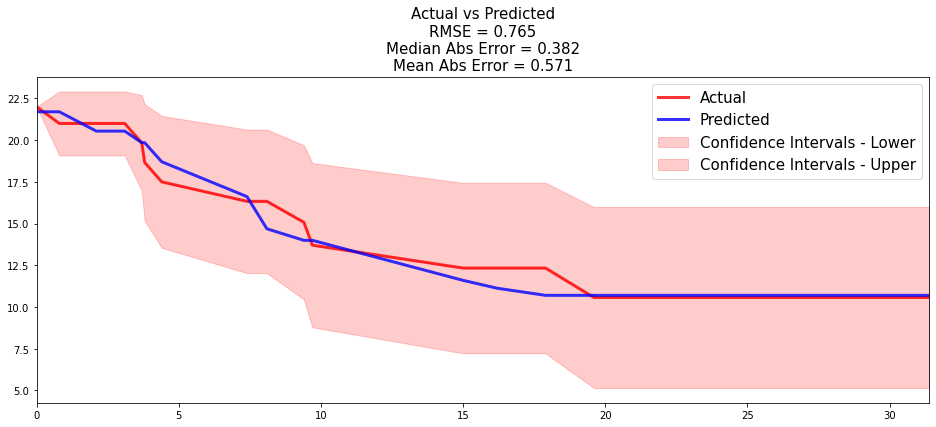

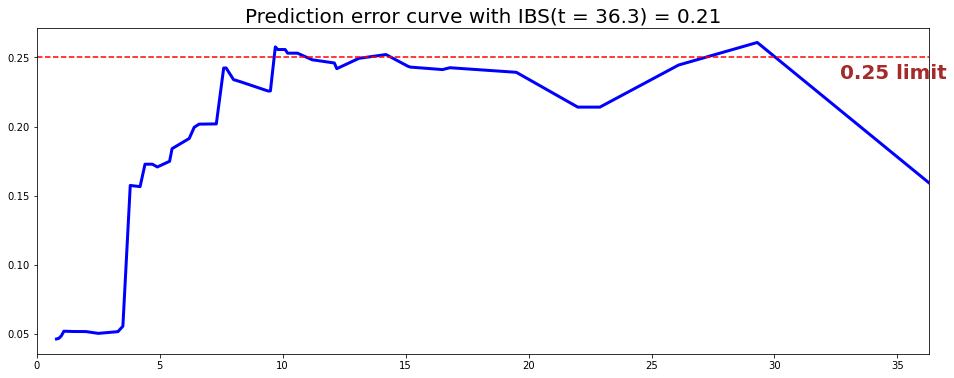

C-index: 0.50
IBS: 0.21


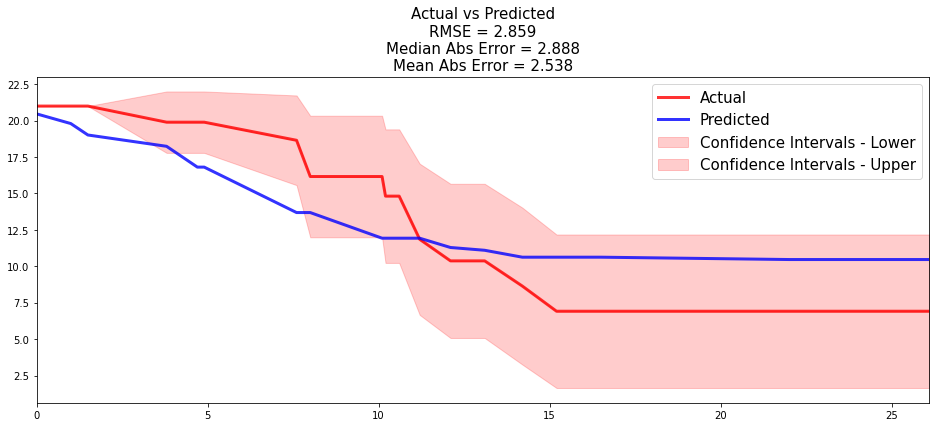

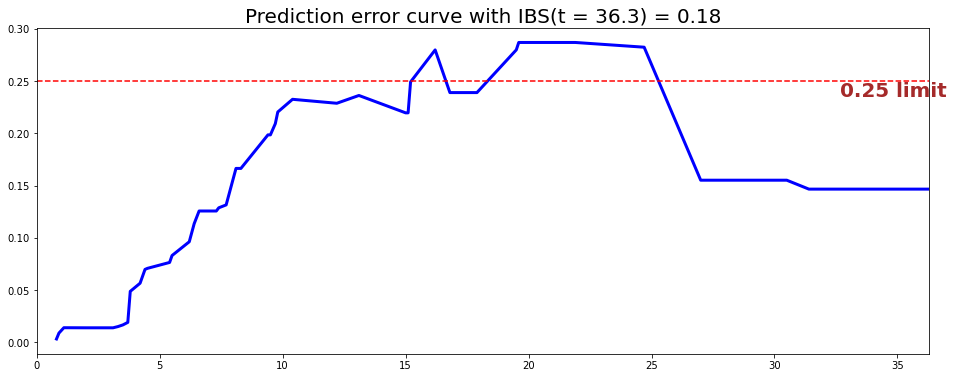

C-index: 0.59
IBS: 0.18


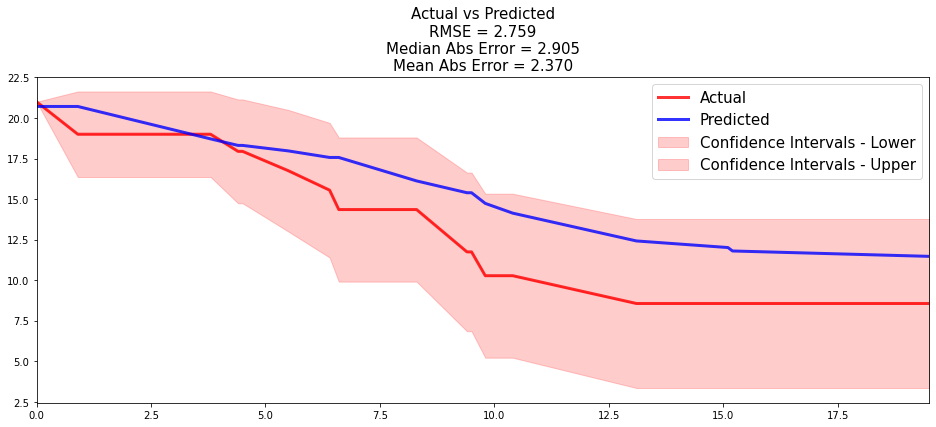

KeyboardInterrupt: 

In [32]:
#without feature selection

# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
    
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    filtered_data = feature_select(data_name, 0)

    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(filtered_data, num_tree_best, max_depth_best, 
                                                                                        min_node_best,display=1 , s = 10)
    
    
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd])
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD'])

print(results_DF)

In [ ]:
gtv_fflp, liver_sub_gtv_fflp, liver_plus_gtv_fflp,
                 clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, clin_variables_dosimetric_fflp,
                 rads_plus_imaging_fflp, rads_plus_dosimetric_fflp,
                 clin_variables_all_fflp, 

In [54]:
# testing with cox

results_cox = []

data_list_cox = list()
data_list_cox.extend((gtv_fflp, liver_sub_gtv_fflp, liver_plus_gtv_fflp,
                 clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, clin_variables_dosimetric_fflp,
                 rads_plus_imaging_fflp, rads_plus_dosimetric_fflp,
                 clin_variables_all_fflp))
for data_name in data_list_cox:
    
    #no feature selection
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    
    #print(filtered_data.columns)
    for p in np.linspace(0.01, 0.5, 20):
        cph = CoxPHFitter(penalizer=p)
        scores = k_fold_cross_validation(cph, filtered_data, 'time column', event_col='event column', k=4, scoring_method="concordance_index")
        ci_avg = mean(scores)
        ci_std = statistics.stdev(scores)
        print(ci_avg, ci_std)

    results_cox.append([data_name, ci_avg, ci_std])
    
results_DF_cox = pd.DataFrame(results_cox, columns = ['Data', 'CI Avg','CI STD'])

print(results_DF_cox)

Processing: gtv.csv

Feature Selecting... 

Loading existing selected features...


 

0.6526341490517757 0.1103391612920137
0.60443600351723 0.06562214703005484
0.6270788376768291 0.078905756105501
0.629899588755829 0.09569876597003124
0.584134644071312 0.01621407777336345
0.5982763184013763 0.05144254111464797
0.5830730394468018 0.08554511714264748
0.6233676046176047 0.07826420877310734
0.586496794115896 0.1124266752809621
0.6129362323663874 0.04237527394524678
0.5997188109748988 0.09130490562262283
0.6178744379603598 0.12555281110558456
0.5701186027285285 0.06355342759468122
0.579757777607618 0.1434610715674929
0.5513383152173913 0.0961717847217746
0.6459280777120422 0.08103551094798664
0.5659289611566476 0.09452983052390942
0.5657106409815388 0.1415607895411523
0.6176656299574184 0.11346864123937732
0.6053687250998201 0.08309111378431963
Processing: liver_sub_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

0.5804505103377903 0.07381743458106166
0.58239814

In [27]:
results_DF.to_csv('results_noFS.csv', index=False, header=False)
results_DF

Data  Best Gridsearch CI    CI Avg  \
0                               gtv.csv            0.675486  0.639708   
1                     liver_sub_gtv.csv            0.660133  0.609746   
2                    liver_plus_gtv.csv            0.675743  0.662248   
3                            gtv_hp.csv            0.614537  0.584840   
4                  liver_sub_gtv_hp.csv            0.586293  0.560278   
5                 liver_plus_gtv_hp.csv            0.597319  0.584341   
6       clin_variables_imaging_fflp.csv            0.667342  0.660035   
7   clin_variables_non_imaging_fflp.csv            0.662902  0.642186   
8    clin_variables_dosimetric_fflp.csv            0.717649  0.692763   
9         clin_variables_imaging_hp.csv            0.608929  0.585546   
10    clin_variables_non_imaging_hp.csv            0.603460  0.569247   
11     clin_variables_dosimetric_hp.csv            0.629773  0.555731   
12           rads_plus_imaging_fflp.csv            0.611448  0.610812   
13       rads_plus_non_imaging_fflp.csv            0.605703  0.650620   
14        rads_plus_dosimetric_fflp.csv            0.731730  0.661405   
15             rads_plus_imaging_hp.csv            0.620482  0.545493   
16         rads_plus_non_imaging_hp.csv            0.624740  0.605823   
17          rads_plus_dosimetric_hp.csv            0.652237  0.591565   
18          clin_variables_all_fflp.csv            0.624283  0.665786   
19            clin_variables_all_hp.csv            0.594437  0.574950   
20                         all_fflp.csv            0.594987  0.642113   
21                           all_hp.csv            0.587364  0.589942   

      CI STD   IBS Avg   IBS STD  
0   0.122164  0.179326  0.005559  
1   0.082343  0.208597  0.023169  
2   0.078095  0.195338  0.027300  
3   0.067334  0.167763  0.028812  
4   0.051805  0.143274  0.034707  
5   0.056882  0.156748  0.033634  
6   0.046956  0.169990  0.030427  
7   0.104155  0.181914  0.033543  
8   0.074244  0.173533  0.029470  
9   0.032782  0.172482  0.020646  
10  0.040398  0.158220  0.003493  
11  0.055910  0.139962  0.019965  
12  0.038173  0.192943  0.048648  
13  0.103912  0.180743  0.034772  
14  0.072970  0.193473  0.011923  
15  0.038838  0.144593  0.019859  
16  0.054408  0.135401  0.033110  
17  0.070745  0.147869  0.042379  
18  0.083415  0.163126  0.015160  
19  0.061870  0.151132  0.012726  
20  0.041495  0.188298  0.030213  
21  0.081762  0.136528  0.032400

In [38]:
#making figures
# iterating thought each dataset
# all results will be stored in a dataframe with columns "CI, CI STD, IBS, IBS"

results = []
  
data_list = list()
data_list.extend((liver_plus_gtv_fflp, clin_variables_all_fflp, clin_variables_imaging_fflp , clin_variables_non_imaging_fflp, 
                clin_variables_dosimetric_fflp, rads_plus_dosimetric_fflp, all_fflp, clin_variables_non_dosimetric_fflp,
                 rads_plus_non_dosimetric_fflp))
for data_name in data_list:

    # Running feature selection on the data
    
    print('Processing: ' + data_name + '\n')
    processed_file_name = 'filtered_' + data_name 
    
    print('Feature Selecting... \n')
    if(not(os.path.exists(processed_file_name))):
        print('Computing feature selection...\n')
        filtered_data = feature_select(data_name)
    else:
        filtered_data = pd.read_csv(processed_file_name)
        print('Loading existing selected features...\n')
    print('\n \n')

    # running gridsearch
    
    print('Running gridsearch on: ' + data_name + '\n')
    gridsearch_file_name = 'gridsearch_' + data_name 
    
    if(not(os.path.exists(gridsearch_file_name))):
        print('Computing gridsearch...\n')
        (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(filtered_data, data_name)
        print((c_index_best, num_tree_best,max_depth_best, min_node_best))
    else:
        gridsearch_df = pd.read_csv(gridsearch_file_name)
        
        c_index_best = gridsearch_df['Values'][0]
        num_tree_best = gridsearch_df['Values'][1]
        max_depth_best = gridsearch_df['Values'][2]
        min_node_best = gridsearch_df['Values'][3]
        
        #print(c_index_best)
        print('Loading existing gridsearch hyperparameters...\n')
        
    # generating model form best gridsearch combination

    print('Evaluating K-folds with best hyperparameter combination...\n')
    (CIAvg, CIStd, IBSAvg, IBSStd, var_imps_list, predictions) = generate_survival_model(data_name,filtered_data,
                                                                                         num_tree_best, max_depth_best, 
                                                                                         min_node_best,display=0)
    
    results.append([data_name, c_index_best, CIAvg, CIStd, IBSAvg, IBSStd])
    
    survName = data_name + '_preds.mat'
    impsName = data_name + '_imps.csv'
    scipy.io.savemat(survName, mdict={'data': predictions})
    impDF = pd.DataFrame(var_imps_list)
    impDF.to_csv(impsName, index=False, header=False)
    print('\n \n')

results_DF = pd.DataFrame(results, columns = ['Data', 'Best Gridsearch CI', 'CI Avg','CI STD','IBS Avg', 'IBS STD'])

print(results_DF)


Processing: liver_plus_gtv.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: liver_plus_gtv.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/liver_plus_gtv.csv.zip

 

Processing: clin_variables_all_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_all_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...

Saving the model to disk as C:\Users\rckyh\Desktop\repo\liver_mets/clin_variables_all_fflp.csv.zip

 

Processing: clin_variables_imaging_fflp.csv

Feature Selecting... 

Loading existing selected features...


 

Running gridsearch on: clin_variables_imaging_fflp.csv

Loading existing gridsearch hyperparameters...

Evaluating K-folds with best hyperparameter combination...

Saving the m

In [14]:
# SCRATCHPAD

# getting some figures for liver_plus_gtv


data_name = 'clin_variables_dosimetric_fflp.csv'
processed_file_name = 'filtered_' + data_name
if(not(os.path.exists(processed_file_name))):
    print('Computing feature selection...\n')
    filtered_data = feature_select(data_name)
else:
    filtered_data = pd.read_csv(processed_file_name)
    print('Loading existing selected features...\n')
print('\n \n')

        
# making survival model
time_column='time column'
event_column='event column'

features=np.setdiff1d(filtered_data.columns, [time_column, event_column]).tolist()
X = filtered_data[features]
newX=np.setdiff1d(filtered_data.columns, [event_column]).tolist()

X=filtered_data[newX]
E=filtered_data['event column']

CI = []
IBS = []

k_folds = 4
i=1
kf=StratifiedKFold(n_splits=k_folds, random_state=42, shuffle=False)

max_depth_best = 3
num_tree_best = 200
min_node_best = 1

for train_index, test_index in kf.split(X,E):

    # gridsearch within CV loop, takes a long while, comment if doing gridsearch outside of CV
    # gridsearch_data = pd.concat([X,E], axis=1)
    # (c_index_best, num_tree_best, max_depth_best, min_node_best) = gridsearch(gridsearch_data, "garbageFile")

    print('\n {} of kfold {}'.format(i,kf.n_splits)) 
    X1_train, X1_test=X.loc[train_index], X.loc[test_index]
    X_train, X_test=X1_train[features], X1_test[features]
    T_train, T_test=X1_train['time column'].values, X1_test['time column'].values
    E_train, E_test=E.loc[train_index].values, E.loc[test_index].values
    xst = RandomSurvivalForestModel(num_trees=num_tree_best) 

    xst.fit(X_train, T_train, E_train, max_features = 'all', max_depth = max_depth_best,
        min_node_size = min_node_best, num_threads = -1, 
        sample_size_pct = 0.63, importance_mode = 'impurity_corrected',
        seed = 42, save_memory=False )

    c_index = concordance_index(xst, X_test, T_test, E_test)
    #results = compare_to_actual(xst, X_test, T_test, E_test, is_at_risk = True,  figure_size=(16, 6), 
    #                        metrics = ['rmse', 'mean', 'median'])
    ibs = integrated_brier_score(xst, X_test, T_test, E_test, t_max=100)
    CI.append(c_index)
    IBS.append(ibs)
    print('C-index: {:.2f}'.format(c_index))
    print('IBS: {:.2f}'.format(ibs))           
    i=i+1
    
    #print(xst.variable_importance_table)
CIAvg = mean(CI)
CIStd = statistics.stdev(CI)
IBSAvg = mean(IBS)
IBSStd = statistics.stdev(IBS)

risk = xst.predict_risk(X_test).tolist()
test_preds = [risk, T_test.tolist(), E_test.tolist()]
preds_DF = pd.DataFrame(test_preds).transpose()
preds_DF.to_csv('preds.csv', index=False, header=False)


subprocess.run(cmd)
RResults = pd.read_csv(ciFileName)
CI = RResults['ci'][0]
std = RResults['std'][0]

print(CIAvg)
print(CI)
print(std)
print(X_test)

Loading existing selected features...


 


 1 of kfold 4
C-index: 0.55
IBS: 0.23

 2 of kfold 4
C-index: 0.78
IBS: 0.20

 3 of kfold 4
C-index: 0.73
IBS: 0.16

 4 of kfold 4
C-index: 0.72
IBS: 0.16
0.6947001481085672
0.687022900763359
0.07860322418722901
    CEAatRT  Dmax (cGy)  Lines of chemo  PumpBeforeRT
64     16.2      9554.7               2             1
67      4.7      7830.0               3             1
68      6.7      4328.7               2             0
69    206.4      5511.6               4             1
70     24.8      7803.3               4             0
74     70.1      6495.3               3             0
76     88.4      6592.2               4             1
78     48.6      7950.4               2             1
79      1.8      7680.0               1             1
80    231.6     10125.5               2             1
81      1.1      7629.5               3             1
82      2.6      9437.9               1             1
83     18.7      7613.1               2   